# 1D Diffusivity (Homogeneous) - Part I

## Imports

In [37]:
# Tensorflow
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Dense
from keras.models import Model
from keras import optimizers

# Scientific Libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.interpolate import BSpline
import pandas as pd
from sklearn import preprocessing 
from sklearn.metrics import mean_squared_error

# Graphing Libraries
import matplotlib.gridspec as gridspec
from scipy.interpolate import griddata
from mpl_toolkits import mplot3d
from mpl_toolkits.axes_grid1 import make_axes_locatable

# For Train - Validation - Test
from sklearn.model_selection import train_test_split

# For collocation points
from pyDOE import lhs
print(tf.__version__)

%matplotlib inline

1.13.1


## Load Data

In [38]:
data = pd.read_csv('./data/1D_Diffusivity')

In [39]:
X, T, psol = data['X'], data['T'], data['psol']

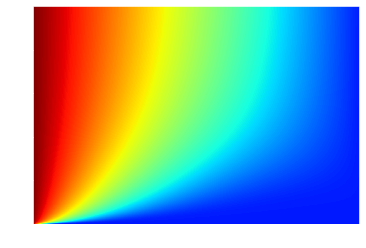

In [40]:
plt.imshow(np.array(psol).reshape(1000, 1500), cmap = 'jet', origin = {'lower'});

## Boundary Conditions

### At t = 0

In [41]:
initial_time_condition = data[['X', 'T', 'psol']][T == 0.0]

### At x = 0

In [42]:
at_start_position = data[['X', 'T', 'psol']][X == 0.0]

### At x = L

In [43]:
at_end_position = data[['X', 'T', 'psol']][X == X.max()]

## Training Data

In [44]:
df_train = pd.concat([initial_time_condition, at_start_position, at_end_position])

## Functions

In [45]:
def init_weights(shape):
    input_size, output_size = shape[0], shape[1]
    std = np.sqrt(2/(input_size + output_size))
    init_random_dist = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(init_random_dist, dtype = tf.float32)

def init_bias(shape):
    init_bias_vals = tf.constant(0.1, shape=shape)
    return tf.Variable(init_bias_vals)

def initial_nn(layers):
    weights = []
    biases = []
    
    for index in range(len(layers)-1):
        shape=(layers[index], layers[index + 1])
        W = init_weights(shape)
        b = init_bias((1, layers[index + 1]))
        weights.append(W)
        biases.append(b)
    return weights, biases

In [46]:
def stratify_sample(num_samples, X_data, num_factors = 2):
    '''
    Variables are sampled using a even sampling method, 
    and then randomly combined sets of those variables 
    are used for one calculation of the target function.   
    '''
    lower_bound = X_data.min(0)
    upper_bound = X_data.max(0)
    bound_range = upper_bound - lower_bound
    
    result = lower_bound + bound_range * lhs(num_factors, num_samples)
    return result

In [47]:
def callback(loss):
    print('Loss:', loss)

In [48]:
def joint_loss(u_u, u_predictions, f_predictions):
    u_loss = tf.reduce_mean(tf.square(u_u - u_predictions))
    f_loss = tf.reduce_mean(tf.square(f_predictions))
    total_loss = tf.add(u_loss, f_loss)
    return total_loss

In [49]:
def plot_history(num_steps, loss_history):
    plt.plot(range(num_steps), loss_history)
    plt.title('Loss v. Iterations');
    plt.ylabel('Loss');
    plt.xlabel('Iterations');

In [50]:
def display_PDEs(l1, l2, l1_noise = None, l2_noise = None,  noise = False):
    print('Correct PDE:')
    correct = 'u_t + u u_x - 0.0031831 u_{xx} = 0'
    print(correct)
    print('---------------------------------')
    print('Identified PDE (clean data)')
    identified = 'u_t + %.3f u u_x - %.3f u_{xx} = 0' % (l1, l2)
    print(identified)
    
    if noise:
        print('---------------------------------')
        print('Identified PDE (noisy data)')
        identified_noise = 'u_t + %.3f u u_x - %.3f u_{xx} = 0' % (l1_noise, l2_noise)
        print(identified_noise)

## Model Parameters

In [51]:
df_train.shape

(3500, 3)

In [52]:
N_f = 10000
N_u = 1000

In [53]:
XT_train = df_train[['X', 'T']]
p_train = df_train['psol']

In [54]:
X_f_data = stratify_sample(N_f, np.array(XT_train)); 

In [55]:
X_f_train = np.vstack((X_f_data, XT_train))
print(f'Stacked/Collocated Points: {X_f_train.shape}')

Stacked/Collocated Points: (13500, 2)


In [56]:
LAYERS = [2, 50, 50, 50, 50, 50, 50, 50, 50, 1]

In [57]:
random_idx = np.random.choice(XT_train.shape[0], N_u, replace = False)

In [58]:
XT_train = XT_train.iloc[random_idx, :]

In [59]:
p_train = p_train.iloc[random_idx]

## Model Initialization

In [60]:
class PhysicsInformedNN():
    
    def __init__(self, X_u, u, X_f, layers, num_iter, lower_bound, upper_bound):
        
        self.loss_history = []  
        self.num_iter, self.layers = num_iter, layers
        self.u = u
        self.lower_bound, self.upper_bound = lower_bound, upper_bound
       
        self.x_u, self.t_u = X_u[:, 0][:, None], X_u[:, 1][:, None]
        self.x_f, self.t_f = X_f[:, 0][:, None], X_f[:, 1][:, None]
        
        self.weights, self.biases = self.initial_nn(layers)
        
        self.x_u_tf, self.t_u_tf, self.u_tf, self.x_f_tf, self.t_f_tf = self.generate_placeholders()
        
        self.u_pred, self.f_pred = self.generate_predictions()
        
        self.loss = self.calc_loss()
        
        config = tf.ConfigProto(allow_soft_placement = True, 
                                log_device_placement = True)
        
        options = {
            'maxiter': num_iter,
            'maxfun': num_iter,
            'maxcor': 50,
            'maxls': 50,
            'ftol' : 1.0 * np.finfo(float).eps
        }

        self.sess = tf.Session(config = config)
        
        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss)
                                                                
        self.sess.run(tf.global_variables_initializer())
        
        
    def train(self):
        tf_dict = {
            self.x_u_tf: self.x_u, 
            self.t_u_tf: self.t_u, 
            self.u_tf: self.u, 
            self.x_f_tf: self.x_f, 
            self.t_f_tf: self.t_f
        }                                                                                                                 
        self.optimizer.minimize(self.sess, 
                                feed_dict = tf_dict, 
                                fetches = [self.loss], 
                                loss_callback = self.callback)
    
    def predict(self, X_data):
        predict_dict = {
            self.x_u_tf: X_data.iloc[:,0][:, None], 
            self.t_u_tf: X_data.iloc[:,1][:, None]
        }
        
        u_predictions = self.sess.run(self.u_pred, feed_dict = predict_dict)  
#         f_predictions = self.sess.run(self.f_pred, feed_dict = predict_dict)
        return u_predictions
        
    def callback(self, loss):
        print('Loss:', round(loss, 4))
        self.loss_history.append(loss)
        
    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1
        
        h = 2.0*(X - self.lower_bound)/(self.upper_bound - self.lower_bound) - 1.0
        
        for l in range(0,num_layers - 2):
            W = weights[l]
            b = biases[l]
            h = tf.tanh(tf.add(tf.matmul(h, W), b))   
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(h, W), b)
        return Y
    
    def net_u(self, x, t):
        u = self.neural_net(tf.concat([x,t], 1), self.weights, self.biases)
        return u
            
    def net_f(self, x, t):
        nu = 0.0016334081056890734
        u = self.net_u(x, t)
        u_t = tf.gradients(u, t)[0]
        u_x = tf.gradients(u, x)[0]
        u_xx = tf.gradients(u_x, x)[0]
        f = u_xx - (nu * u_t) 
        return f
    
    def calc_loss(self):
        u_loss = tf.reduce_mean(tf.square(self.u_tf - self.u_pred)) 
        f_loss = tf.reduce_mean(tf.square(self.f_pred))
        return tf.add(u_loss, f_loss)
               
    def generate_predictions(self):
        u_pred = self.net_u(self.x_u_tf, self.t_u_tf) 
        f_pred = self.net_f(self.x_f_tf, self.t_f_tf)
        return u_pred, f_pred
        
    def generate_placeholders(self):
        x_u_tf = tf.placeholder(tf.float32)
        t_u_tf = tf.placeholder(tf.float32)        
        
        u_tf = tf.placeholder(tf.float32)
        
        x_f_tf = tf.placeholder(tf.float32)
        t_f_tf = tf.placeholder(tf.float32)
        
        return x_u_tf, t_u_tf, u_tf, x_f_tf, t_f_tf
        
    def init_weights(self, shape):
        input_size, output_size = shape[0], shape[1]
        std = np.sqrt(2/(input_size + output_size))
        init_random_dist = tf.truncated_normal(shape, stddev = std)
        return tf.Variable(init_random_dist, dtype = tf.float32)

    def init_bias(self, shape):
        init_bias_vals = tf.constant(0.1, shape = shape)
        return tf.Variable(init_bias_vals)

    def initial_nn(self, layers):
        weights = []
        biases = []

        for index in range(len(layers)-1):
            shape = (layers[index], layers[index + 1])
            W = init_weights(shape)
            b = init_bias((1, layers[index + 1]))
            weights.append(W)
            biases.append(b)       
        return weights, biases

## Run Model

In [61]:
scaler = preprocessing.MinMaxScaler()

In [62]:
XT_norm = scaler.fit_transform(XT_train)
p_norm = scaler.fit_transform(p_train[:, None])
X_f_norm = scaler.fit_transform(X_f_train)

In [63]:
lower_bound = XT_norm.min(0)
upper_bound = XT_norm.max(0)

In [66]:
model = PhysicsInformedNN(XT_norm, p_norm, X_f_norm,
                          layers = LAYERS, 
                          num_iter = 10000, 
                          lower_bound = lower_bound, 
                          upper_bound = upper_bound)

In [67]:
model.train()

Loss: 0.1895
Loss: 2.5247
Loss: 0.1496
Loss: 0.1493
Loss: 0.1473
Loss: 0.1439
Loss: 0.134
Loss: 0.8455
Loss: 0.1186
Loss: 35.3918
Loss: 0.1356
Loss: 0.1118
Loss: 0.1086
Loss: 0.1
Loss: 0.077
Loss: 0.0662
Loss: 0.0623
Loss: 0.061
Loss: 0.06
Loss: 0.0582
Loss: 0.0539
Loss: 0.0491
Loss: 0.0535
Loss: 0.0479
Loss: 0.0472
Loss: 0.0463
Loss: 0.0455
Loss: 0.0448
Loss: 0.0656
Loss: 0.0435
Loss: 0.0449
Loss: 0.0429
Loss: 0.0425
Loss: 0.0427
Loss: 0.0422
Loss: 0.0427
Loss: 0.0421
Loss: 0.042
Loss: 0.0419
Loss: 0.0415
Loss: 0.0408
Loss: 0.04
Loss: 0.0426
Loss: 0.039
Loss: 0.0517
Loss: 0.0386
Loss: 0.0504
Loss: 0.0381
Loss: 0.2057
Loss: 0.036
Loss: 0.0359
Loss: 0.0357
Loss: 967498.94
Loss: 5.3565
Loss: 0.0504
Loss: 0.0352
Loss: 0.0365
Loss: 0.033
Loss: 0.1181
Loss: 0.0311
Loss: 0.0342
Loss: 0.0288
Loss: 0.0316
Loss: 0.0281
Loss: 0.028
Loss: 0.0278
Loss: 0.0274
Loss: 0.0264
Loss: 0.0261
Loss: 0.0261
Loss: 0.026
Loss: 0.026
Loss: 0.0257
Loss: 0.0253
Loss: 0.0245
Loss: 0.0238
Loss: 0.0236
Loss: 0.0236

Loss: 0.0149
Loss: 0.0149
Loss: 0.0154
Loss: 0.0149
Loss: 0.0149
Loss: 0.0148
Loss: 0.0148
Loss: 0.0148
Loss: 0.0148
Loss: 0.0148
Loss: 0.0148
Loss: 0.0148
Loss: 0.0148
Loss: 0.0148
Loss: 0.0148
Loss: 0.0148
Loss: 0.0148
Loss: 0.0148
Loss: 0.0148
Loss: 0.0148
Loss: 0.0148
Loss: 0.0148
Loss: 0.0148
Loss: 0.0148
Loss: 0.0148
Loss: 0.0148
Loss: 0.0148
Loss: 0.0148
Loss: 0.0148
Loss: 0.0148
Loss: 0.0148
Loss: 0.0148
Loss: 0.0148
Loss: 0.0148
Loss: 0.0148
Loss: 0.0147
Loss: 0.0147
Loss: 0.0147
Loss: 0.015
Loss: 0.0147
Loss: 0.0146
Loss: 0.0146
Loss: 0.0145
Loss: 0.0145
Loss: 0.0145
Loss: 0.0145
Loss: 0.0144
Loss: 0.0144
Loss: 0.0144
Loss: 0.0144
Loss: 0.0144
Loss: 0.0146
Loss: 0.0144
Loss: 0.0144
Loss: 0.0144
Loss: 0.0144
Loss: 0.0144
Loss: 0.0144
Loss: 0.0144
Loss: 0.0144
Loss: 0.0144
Loss: 0.0144
Loss: 0.0144
Loss: 0.0144
Loss: 0.0144
Loss: 0.0144
Loss: 0.0144
Loss: 0.0144
Loss: 0.0144
Loss: 0.0144
Loss: 0.0144
Loss: 0.0144
Loss: 0.0144
Loss: 0.0144
Loss: 0.0144
Loss: 0.0143
Loss: 0.0143


Loss: 0.0114
Loss: 0.0114
Loss: 0.0114
Loss: 0.0114
Loss: 0.0114
Loss: 0.0114
Loss: 0.0114
Loss: 0.0114
Loss: 0.0114
Loss: 0.0114
Loss: 0.0114
Loss: 0.0114
Loss: 0.0114
Loss: 0.0114
Loss: 0.0113
Loss: 0.0113
Loss: 0.0113
Loss: 0.0113
Loss: 0.0113
Loss: 0.0113
Loss: 0.0113
Loss: 0.0113
Loss: 0.0113
Loss: 0.0113
Loss: 0.0113
Loss: 0.0113
Loss: 0.0113
Loss: 0.0113
Loss: 0.0113
Loss: 0.0113
Loss: 0.0113
Loss: 0.0113
Loss: 0.0113
Loss: 0.0113
Loss: 0.0113
Loss: 0.0113
Loss: 0.0113
Loss: 0.0113
Loss: 0.0113
Loss: 0.0113
Loss: 0.0113
Loss: 0.0113
Loss: 0.0113
Loss: 0.0113
Loss: 0.0113
Loss: 0.0113
Loss: 0.0112
Loss: 0.0112
Loss: 0.0112
Loss: 0.0112
Loss: 0.0112
Loss: 0.0112
Loss: 0.0112
Loss: 0.0112
Loss: 0.0112
Loss: 0.0112
Loss: 0.0112
Loss: 0.0112
Loss: 0.0112
Loss: 0.0112
Loss: 0.0112
Loss: 0.0112
Loss: 0.0116
Loss: 0.0112
Loss: 0.0112
Loss: 0.0112
Loss: 0.0112
Loss: 0.0112
Loss: 0.0112
Loss: 0.0112
Loss: 0.0112
Loss: 0.0112
Loss: 0.0112
Loss: 0.0112
Loss: 0.0112
Loss: 0.0112
Loss: 0.0112

## Predictions

In [68]:
u_pred = model.predict(pd.DataFrame(scaler.fit_transform(data[['X', 'T']])));

In [69]:
MSE = mean_squared_error(scaler.fit_transform(data['psol'][:, None]), u_pred)

In [70]:
print(f'Mean Squared Error: {MSE}')

Mean Squared Error: 0.01810879328922418


## Plotting

### Inverse Transform

In [71]:
def plot_subplots(u_data, u_pred):
    extent = [0, 1, -1, 1]
    params = {"ytick.color" : "w",
          "xtick.color" : "w",
          "axes.labelcolor" : "w",
          "axes.edgecolor" : "w"}
    plt.rcParams.update(params)
    fig = plt.figure(figsize = (10, 10))
    fig.subplots_adjust(hspace = 0.5)
    gs = fig.add_gridspec(2, 1)
    
    ax1 = fig.add_subplot(gs[0, :], )
    ax1.set_title('Actual Data', color = 'white')
    ax1.set_xlabel('time')
    ax1.set_ylabel('x')
    h = ax1.imshow(u_data, 
                   interpolation ='gaussian', cmap ='jet', 
                   extent = extent, 
                   origin ='lower', aspect ='auto')
    plt.colorbar(h);


    ax2 = fig.add_subplot(gs[1, :])
    ax2.set_title('Predicted Data', color = 'white')
    ax2.set_xlabel('time')
    ax2.set_ylabel('x')
    h = ax2.imshow(u_pred, interpolation='gaussian', cmap='jet', 
                   extent = extent, 
                   origin='lower', aspect='auto')
    plt.colorbar(h);
    plt.savefig('./images/part_1_subplots', dpi = 1200, transparent = True)

In [ ]:
# U_pred = scaler.inverse_transform(u_pred)

In [ ]:
# data['p_pred'] = U_pred

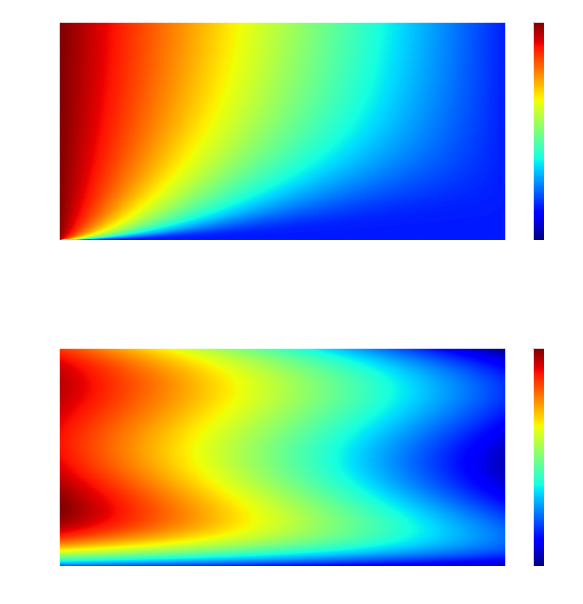

In [72]:
plot_subplots(np.array(psol).reshape(1000, 1500), u_pred.reshape(1000, -1))

# 1D Diffusivity (Homogeneous) - Part II

## Imports

In [105]:
import time

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Dense
from keras.models import Model
from keras import optimizers

# Scientific Libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.interpolate import BSpline
import pandas as pd

# Graphing Libraries
import matplotlib.gridspec as gridspec
from scipy.interpolate import griddata
from mpl_toolkits import mplot3d
from mpl_toolkits.axes_grid1 import make_axes_locatable

# For Train - Validation - Test
from sklearn.model_selection import train_test_split

# For collocation points
from pyDOE import lhs
print(tf.__version__)

%matplotlib inline
# %matplotlib notebook
# Tensorboard

1.13.1


In [73]:
data = pd.read_csv('./data/1D_Diffusivity')

In [74]:
X, T, psol = data['X'], data['T'], data['psol']

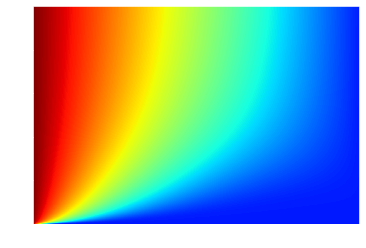

In [75]:
plt.imshow(np.array(psol).reshape(1000, 1500), cmap = 'jet', origin = {'lower'});

In [76]:
print(f'P shape: {psol.shape}')
print(f'X train shape: {X.shape}')
print(f'T train shape: {T.shape}')

P shape: (1500000,)
X train shape: (1500000,)
T train shape: (1500000,)


## Define Variables

In [77]:
phi = 0.2 
mu = 0.4 # cp
c_t = 3e-6 # psi-1
k = 2000 # millidarcy
L = 1000 #ft
ft = 3.28

In [78]:
def to_SI_units(mu, c_t, k):
    k = k / (1.01 * 10**15)
    c_t = c_t / 6897
    mu = mu / 1000
    return mu, c_t, k

In [79]:
mu, c_t, k = to_SI_units(mu, c_t, k)
nu = phi * mu* c_t / k;
nu = nu / (ft**2)
nu

0.0016334081056890736

## Boundary Conditions

### At t = 0

In [80]:
initial_time_condition = data[['X', 'T', 'psol']][T == 0.0]

### At x = 0

In [81]:
at_start_position = data[['X', 'T', 'psol']][X == 0.0]

### At x = L

In [82]:
at_end_position = data[['X', 'T', 'psol']][X == X.max()]

## Training Data

In [83]:
df_train = pd.concat([initial_time_condition, at_start_position, at_end_position])

## Functions

In [84]:
def init_weights(shape):
    input_size, output_size = shape[0], shape[1]
    std = np.sqrt(2/(input_size + output_size))
    init_random_dist = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(init_random_dist, dtype = tf.float32)

def init_bias(shape):
    init_bias_vals = tf.constant(0.1, shape=shape)
    return tf.Variable(init_bias_vals)

def initial_nn(layers):
    weights = []
    biases = []
    
    for index in range(len(layers)-1):
        shape=(layers[index], layers[index + 1])
        W = init_weights(shape)
        b = init_bias((1, layers[index + 1]))
        weights.append(W)
        biases.append(b)
    return weights, biases

In [85]:
def stratify_sample(num_samples, X_data, num_factors = 2):
    '''
    Variables are sampled using a even sampling method, 
    and then randomly combined sets of those variables 
    are used for one calculation of the target function.   
    '''
    lower_bound = X_data.min(0)
    upper_bound = X_data.max(0)
    bound_range = upper_bound - lower_bound
    
    result = lower_bound + bound_range * lhs(num_factors, num_samples)
    return result

In [86]:
def callback(loss):
    print('Loss:', loss)

In [87]:
def joint_loss(u_u, u_predictions, f_predictions):
    u_loss = tf.reduce_mean(tf.square(u_u - u_predictions))
    f_loss = tf.reduce_mean(tf.square(f_predictions))
    total_loss = tf.add(u_loss, f_loss)
    return total_loss

In [88]:
def plot_history(num_steps, loss_history):
    plt.plot(range(num_steps), loss_history)
    plt.title('Loss v. Iterations');
    plt.ylabel('Loss');
    plt.xlabel('Iterations');

In [89]:
def display_PDEs(l1, l2, l1_noise = None, l2_noise = None,  noise = False):
    print('Correct PDE:')
    correct = f'{nu} u_t - 1.0 u_xx = 0'
    print(correct)
    print('---------------------------------')
    print('Identified PDE (clean data)')
    identified = '%.3fu_t - %.3f u_{xx} = 0' % (l2, l1)
    print(identified)
    
    if noise:
        print('---------------------------------')
        print('Identified PDE (noisy data)')
        identified_noise = 'u_t + %.3f u u_x - %.3f u_{xx} = 0' % (l1_noise, l2_noise)
        print(identified_noise)

## Model Parameters

In [90]:
df_train.shape

(3500, 3)

In [91]:
N_f = 10000
N_u = 1000

In [92]:
XT_train = df_train[['X', 'T']]
p_train = df_train['psol']

In [93]:
X_f_data = stratify_sample(N_f, np.array(XT_train)); 

In [94]:
X_f_train = np.vstack((X_f_data, XT_train))
print(f'Stacked/Collocated Points: {X_f_train.shape}')

Stacked/Collocated Points: (13500, 2)


In [95]:
LAYERS = [2, 50, 50, 50, 50, 50, 50, 50, 50, 1]

In [96]:
random_idx = np.random.choice(XT_train.shape[0], N_u, replace = False)

In [97]:
XT_train = XT_train.iloc[random_idx, :]

In [98]:
p_train = p_train.iloc[random_idx]

## Model Initialization

In [134]:
class PhysicsInformedNN():
    
    def __init__(self, X_u, u, layers, num_iter, lower_bound, upper_bound):
        
        self.loss_history = []  
        self.num_iter, self.layers = num_iter, layers
        self.u = u
        self.lower_bound, self.upper_bound = lower_bound, upper_bound
        self.x_u, self.t_u = X_u.iloc[:, 0:1], X_u.iloc[:, 1:2]
#         self.x_f, self.t_f = X_f[:, 0][:, None], X_f[:, 1][:, None]
        
        self.weights, self.biases = self.initial_nn(layers)
         
            # Initialize parameters
        
        random_init_weights = np.random.randn(2)
        print(random_init_weights)
        self.lambda1 = tf.Variable(random_init_weights[0], dtype = tf.float32)
        self.lambda2 = tf.Variable(random_init_weights[1], dtype = tf.float32)
        
        self.x_u_tf, self.t_u_tf, self.u_tf = self.generate_placeholders()
        
        self.u_pred, self.f_pred = self.generate_predictions()
        
        self.loss = self.calc_loss()
        
       
        config = tf.ConfigProto(allow_soft_placement = True, 
                                log_device_placement = True)
        options = {
            'maxiter': num_iter,
            'maxfun':  num_iter,
            'maxcor': 50, 
            'maxls': 50,
            'ftol' : 1.0 * np.finfo(float).eps
        }
        
        self.sess = tf.Session(config = config)
        
        # For DiffEq?
        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss, 
                                                                method = 'L-BFGS-B',
                                                                options = options)
        # For Adam?
        self.optimizer_Adam = tf.train.AdamOptimizer()
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)
                                                                
        self.sess.run(tf.global_variables_initializer())
        
        
    def train(self, num_iterations, adam = False, both = False):
        tf_dict = {
            self.x_u_tf: self.x_u, 
            self.t_u_tf: self.t_u, 
            self.u_tf: self.u, 
#             self.x_f_tf: self.x_f, 
#             self.t_f_tf: self.t_f
        }
        
        if adam == True:
            start_time = time.time()
            for i in range(num_iterations):
                self.sess.run(self.train_op_Adam, tf_dict)
                self.print_stats(i, start_time, tf_dict)
        
        if both == True:
            start_time = time.time()
            self.optimizer.minimize(self.sess,
                                feed_dict = tf_dict,
                                fetches = [self.loss, self.lambda1, self.lambda2], 
                                loss_callback = self.callback)
    
    def print_stats(self, i, start_time, tf_dict):
        if i % 10 == 0:
            elapsed = time.time() - start_time
            loss_value = self.sess.run(self.loss, tf_dict)
            lambda1_value = np.exp(self.sess.run(self.lambda1))
            lambda2_value = self.sess.run(self.lambda2)
            print('It: %d, Loss: %.3e, Lambda_1: %.3f, Lambda_2: %.6f, Time: %.2f' % 
                  (i, loss_value, lambda1_value, lambda2_value, elapsed))
            start_time = time.time()
    
    def predict(self, X_data):
        predict_dict = {
            self.x_u_tf: X_data.iloc[:,0][:, None], 
            self.t_u_tf: X_data.iloc[:,1][:, None]
        }
        
        u_predictions = self.sess.run(self.u_pred, feed_dict = predict_dict)  
#         f_predictions = self.sess.run(self.f_pred, feed_dict = predict_dict)
        return u_predictions

    def callback(self, loss, lambda1, lambda2):
        print('Loss: %e, l1: %.5f, l2: %.5f' % (loss, np.exp(lambda1), lambda2))
        self.loss_history.append(loss)
    
        
    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1
        
        h = 2.0*(X - self.lower_bound)/(self.upper_bound - self.lower_bound) - 1.0
        for l in range(0,num_layers - 2):
            W = weights[l]
            b = biases[l]
            h = tf.tanh(tf.add(tf.matmul(h, W), b))   
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(h, W), b)
        return Y
    
    def net_u(self, x, t):
        u = self.neural_net(tf.concat([x,t], 1, name='00_concat_op'), self.weights, self.biases)
        return u
            
    def net_f(self, x, t):
#         nu = 0.01 / np.pi
        lambda1 = tf.exp(self.lambda1)
        lambda2 = self.lambda2
        u = self.net_u(x, t)
        u_t = tf.gradients(u, t)[0]
        u_x = tf.gradients(u, x)[0]
        u_xx = tf.gradients(u_x, x)[0]
        f = (lambda1 * u_xx) - (lambda2 * u_t)
        return f
    
    def calc_loss(self):
        u_loss = tf.reduce_mean(tf.square(self.u_tf - self.u_pred)) 
        f_loss = tf.reduce_mean(tf.square(self.f_pred))
        return u_loss + f_loss
               
    def generate_predictions(self):
        u_pred = self.net_u(self.x_u_tf, self.t_u_tf) 
        f_pred = self.net_f(self.x_u_tf, self.t_u_tf)
        return u_pred, f_pred
        
    def generate_placeholders(self):
        x_u_tf = tf.placeholder(tf.float32)
        t_u_tf = tf.placeholder(tf.float32)        
        
        u_tf = tf.placeholder(tf.float32)
        
#         x_f_tf = tf.placeholder(tf.float32)
#         t_f_tf = tf.placeholder(tf.float32)
        
        return x_u_tf, t_u_tf, u_tf
        
    def init_weights(self, shape):
        input_size, output_size = shape[0], shape[1]
        std = np.sqrt(2/(input_size + output_size))
        init_random_dist = tf.truncated_normal(shape, stddev = std)
        return tf.Variable(init_random_dist, dtype = tf.float32)

    def init_bias(self, shape):
        init_bias_vals = tf.constant(1, shape = shape)
        return tf.Variable(init_bias_vals)

    def initial_nn(self, layers):
        weights = []
        biases = []

        for index in range(len(layers)-1):
            shape = (layers[index], layers[index + 1])
            W = init_weights(shape)
            b = init_bias((1, layers[index + 1]))
            weights.append(W)
            biases.append(b)       
        return weights, biases


## Model Run

In [135]:
scaler = preprocessing.MinMaxScaler()

In [136]:
XT_norm = scaler.fit_transform(XT_train)
p_norm = scaler.fit_transform(p_train[:, None])
X_f_norm = scaler.fit_transform(X_f_train)

In [137]:
lower_bound = XT_norm.min(0)
upper_bound = XT_norm.max(0)

In [138]:
model = PhysicsInformedNN(pd.DataFrame(XT_norm), p_norm,
                          layers = LAYERS, 
                          num_iter = 1000, 
                          lower_bound = lower_bound, 
                          upper_bound = upper_bound)

[0.50215708 0.23992987]


In [139]:
model.train(500, True, True)

It: 0, Loss: 1.739e-01, Lambda_1: 1.651, Lambda_2: 0.239009, Time: 3.74
It: 10, Loss: 1.252e-01, Lambda_1: 1.638, Lambda_2: 0.239171, Time: 6.07
It: 20, Loss: 9.890e-02, Lambda_1: 1.624, Lambda_2: 0.229900, Time: 6.51
It: 30, Loss: 7.945e-02, Lambda_1: 1.608, Lambda_2: 0.218057, Time: 6.95
It: 40, Loss: 6.529e-02, Lambda_1: 1.593, Lambda_2: 0.205015, Time: 7.39
It: 50, Loss: 5.422e-02, Lambda_1: 1.578, Lambda_2: 0.198882, Time: 7.99
It: 60, Loss: 4.735e-02, Lambda_1: 1.564, Lambda_2: 0.196261, Time: 8.43
It: 70, Loss: 4.373e-02, Lambda_1: 1.554, Lambda_2: 0.195306, Time: 8.87
It: 80, Loss: 3.941e-02, Lambda_1: 1.548, Lambda_2: 0.195774, Time: 9.32
It: 90, Loss: 3.973e-02, Lambda_1: 1.545, Lambda_2: 0.197663, Time: 9.94
It: 100, Loss: 3.884e-02, Lambda_1: 1.544, Lambda_2: 0.199519, Time: 10.38
It: 110, Loss: 3.866e-02, Lambda_1: 1.542, Lambda_2: 0.201524, Time: 10.83
It: 120, Loss: 3.837e-02, Lambda_1: 1.541, Lambda_2: 0.203981, Time: 11.26
It: 130, Loss: 3.813e-02, Lambda_1: 1.540, Lam

Loss: 7.520963e-03, l1: 1.09179, l2: 0.01129
Loss: 7.445110e-03, l1: 1.08171, l2: 0.01178
Loss: 7.363026e-03, l1: 1.07148, l2: 0.00901
Loss: 7.333335e-03, l1: 1.06636, l2: 0.00678
Loss: 7.312227e-03, l1: 1.06254, l2: 0.00652
Loss: 7.330786e-03, l1: 1.04617, l2: 0.00562
Loss: 7.292989e-03, l1: 1.05532, l2: 0.00613
Loss: 7.273607e-03, l1: 1.05084, l2: 0.00589
Loss: 7.253118e-03, l1: 1.04234, l2: 0.00648
Loss: 7.222047e-03, l1: 1.03000, l2: 0.00578
Loss: 7.200260e-03, l1: 1.01955, l2: 0.00640
Loss: 7.180588e-03, l1: 1.00517, l2: 0.00394
Loss: 7.132913e-03, l1: 1.01305, l2: 0.00529
Loss: 8.711134e-03, l1: 0.97465, l2: 0.00242
Loss: 7.090003e-03, l1: 1.00623, l2: 0.00479
Loss: 7.497876e-03, l1: 1.00642, l2: 0.00346
Loss: 7.036692e-03, l1: 1.00628, l2: 0.00445
Loss: 6.958975e-03, l1: 0.99709, l2: 0.00459
Loss: 6.905015e-03, l1: 0.98802, l2: 0.00383
Loss: 7.263484e-03, l1: 0.99910, l2: 0.00228
Loss: 6.861533e-03, l1: 0.99063, l2: 0.00346
Loss: 6.820855e-03, l1: 0.99361, l2: 0.00262
Loss: 6.75

Loss: 4.912328e-03, l1: 0.86090, l2: 0.00104
Loss: 4.912081e-03, l1: 0.85966, l2: 0.00084
Loss: 4.909086e-03, l1: 0.86029, l2: 0.00094
Loss: 4.904440e-03, l1: 0.85880, l2: 0.00091
Loss: 4.896106e-03, l1: 0.85836, l2: 0.00105
Loss: 4.876757e-03, l1: 0.85667, l2: 0.00133
Loss: 4.876029e-03, l1: 0.85715, l2: 0.00210
Loss: 4.867880e-03, l1: 0.85692, l2: 0.00172
Loss: 4.858938e-03, l1: 0.85486, l2: 0.00176
Loss: 4.853312e-03, l1: 0.85524, l2: 0.00158
Loss: 4.847878e-03, l1: 0.85471, l2: 0.00127
Loss: 4.841379e-03, l1: 0.85377, l2: 0.00108
Loss: 4.831033e-03, l1: 0.85160, l2: 0.00084
Loss: 4.815208e-03, l1: 0.84970, l2: 0.00093
Loss: 4.796283e-03, l1: 0.84868, l2: 0.00117
Loss: 4.808012e-03, l1: 0.84415, l2: 0.00166
Loss: 4.779730e-03, l1: 0.84663, l2: 0.00139
Loss: 4.754963e-03, l1: 0.84474, l2: 0.00093
Loss: 4.738124e-03, l1: 0.84515, l2: 0.00054
Loss: 4.705837e-03, l1: 0.84186, l2: -0.00004
Loss: 4.686002e-03, l1: 0.84132, l2: -0.00006
Loss: 4.667076e-03, l1: 0.84032, l2: 0.00070
Loss: 4.

Loss: 3.574515e-03, l1: 0.67752, l2: 0.02313
Loss: 3.570965e-03, l1: 0.67653, l2: 0.02293
Loss: 3.564836e-03, l1: 0.67497, l2: 0.02274
Loss: 3.560427e-03, l1: 0.67379, l2: 0.02206
Loss: 3.553868e-03, l1: 0.67233, l2: 0.02190
Loss: 3.547351e-03, l1: 0.67334, l2: 0.02220
Loss: 3.538318e-03, l1: 0.67414, l2: 0.02212
Loss: 3.533853e-03, l1: 0.67502, l2: 0.02194
Loss: 3.526228e-03, l1: 0.67807, l2: 0.02163
Loss: 3.523428e-03, l1: 0.68038, l2: 0.02105
Loss: 3.513411e-03, l1: 0.68550, l2: 0.02146
Loss: 3.507758e-03, l1: 0.68598, l2: 0.02131
Loss: 3.504717e-03, l1: 0.68514, l2: 0.02125
Loss: 3.501075e-03, l1: 0.68746, l2: 0.02130
Loss: 3.499236e-03, l1: 0.68987, l2: 0.02131
Loss: 3.495895e-03, l1: 0.68964, l2: 0.02121
Loss: 3.494964e-03, l1: 0.69027, l2: 0.02091
Loss: 3.493435e-03, l1: 0.68993, l2: 0.02107
Loss: 3.489702e-03, l1: 0.68940, l2: 0.02091
Loss: 3.485743e-03, l1: 0.68756, l2: 0.02060
Loss: 3.482420e-03, l1: 0.68700, l2: 0.01972
Loss: 3.480189e-03, l1: 0.68572, l2: 0.01947
Loss: 3.47

Loss: 2.895130e-03, l1: 0.58456, l2: 0.00823
Loss: 2.894223e-03, l1: 0.58490, l2: 0.00831
Loss: 2.892374e-03, l1: 0.58559, l2: 0.00846
Loss: 2.889826e-03, l1: 0.58552, l2: 0.00856
Loss: 2.887250e-03, l1: 0.58572, l2: 0.00864
Loss: 2.883795e-03, l1: 0.58547, l2: 0.00877
Loss: 2.877284e-03, l1: 0.58503, l2: 0.00884
Loss: 2.871462e-03, l1: 0.58278, l2: 0.00931
Loss: 2.869433e-03, l1: 0.58388, l2: 0.00908
Loss: 2.852627e-03, l1: 0.58191, l2: 0.00909
Loss: 2.842043e-03, l1: 0.58243, l2: 0.00919
Loss: 3.043675e-03, l1: 0.58780, l2: 0.01099
Loss: 2.831642e-03, l1: 0.58347, l2: 0.00954
Loss: 2.888616e-03, l1: 0.58295, l2: 0.01162
Loss: 2.822791e-03, l1: 0.58332, l2: 0.01014
Loss: 2.818834e-03, l1: 0.58204, l2: 0.01009
Loss: 2.811053e-03, l1: 0.58134, l2: 0.00989
Loss: 2.806112e-03, l1: 0.58075, l2: 0.00996
Loss: 2.793675e-03, l1: 0.57668, l2: 0.00997
Loss: 2.805228e-03, l1: 0.56786, l2: 0.01051
Loss: 2.787002e-03, l1: 0.57313, l2: 0.01019
Loss: 2.788825e-03, l1: 0.56902, l2: 0.01039
Loss: 2.78

Loss: 2.512821e-03, l1: 0.50903, l2: 0.00678
Loss: 2.519381e-03, l1: 0.51049, l2: 0.00670
Loss: 2.510715e-03, l1: 0.50950, l2: 0.00675
Loss: 2.510752e-03, l1: 0.50879, l2: 0.00663
Loss: 2.509974e-03, l1: 0.50914, l2: 0.00669
Loss: 2.509096e-03, l1: 0.50904, l2: 0.00668
Loss: 2.507919e-03, l1: 0.50830, l2: 0.00663
Loss: 2.506989e-03, l1: 0.50732, l2: 0.00658
Loss: 2.505786e-03, l1: 0.50590, l2: 0.00651
Loss: 2.503755e-03, l1: 0.50337, l2: 0.00635
Loss: 2.502270e-03, l1: 0.50153, l2: 0.00622
Loss: 2.500798e-03, l1: 0.50029, l2: 0.00614
Loss: 2.501740e-03, l1: 0.49865, l2: 0.00585
Loss: 2.498823e-03, l1: 0.49957, l2: 0.00601
Loss: 2.497316e-03, l1: 0.49826, l2: 0.00587
Loss: 2.493723e-03, l1: 0.49789, l2: 0.00584
Loss: 2.493951e-03, l1: 0.49973, l2: 0.00581
Loss: 2.491106e-03, l1: 0.49881, l2: 0.00583
Loss: 2.488798e-03, l1: 0.49743, l2: 0.00556
Loss: 2.486871e-03, l1: 0.49716, l2: 0.00546
Loss: 2.484750e-03, l1: 0.49586, l2: 0.00529
Loss: 2.484580e-03, l1: 0.49549, l2: 0.00525
Loss: 2.48

## Predictions

In [140]:
u_pred = model.predict(pd.DataFrame(scaler.fit_transform(data[['X', 'T']])));

In [141]:
psol_norm = scaler.fit_transform(data['psol'][:, None])

In [142]:
MSE = mean_squared_error(psol_norm, u_pred)

In [143]:
print(f'Mean Squared Error: {MSE}')

Mean Squared Error: 0.027657902833717617


In [144]:
nu = 0.001633

lambda_1_value = model.sess.run(model.lambda1)
lambda_1_value = np.exp(lambda_1_value)

lambda_2_value = model.sess.run(model.lambda2)
# 

error_lambda_1 = np.sqrt((lambda_1_value - 1.0)**2) * 100

error_lambda_2 = np.sqrt((lambda_2_value - nu)**2) * 100
print('Error l1: %.3f%%' % (error_lambda_1))                             
print('Error l2: %.3f%%' % (error_lambda_2))  

print(f'l1: {lambda_1_value}')
print(f'l2: {lambda_2_value}')

Error l1: 52.117%
Error l2: 0.403%
l1: 0.4788302481174469
l2: 0.005666289944201708


In [145]:
display_PDEs(lambda_1_value, lambda_2_value, l1_noise = None, l2_noise = None,  noise = False)

Correct PDE:
0.001633 u_t - 1.0 u_xx = 0
---------------------------------
Identified PDE (clean data)
0.006u_t - 0.479 u_{xx} = 0


## Plotting

In [146]:
def plot_subplots(u_data, u_pred):
    extent = [0, 1, -1, 1]

    fig = plt.figure(figsize = (10, 10))
    fig.subplots_adjust(hspace = 0.5)
    gs = fig.add_gridspec(2, 1)
    
    ax1 = fig.add_subplot(gs[0, :], )
    ax1.set_title('Actual Data')
    ax1.set_xlabel('time')
    ax1.set_ylabel('x')
    h = ax1.imshow(u_data, 
                   interpolation ='gaussian', cmap ='jet', 
                   extent = extent, 
                   origin ='lower', aspect ='auto')
    plt.colorbar(h);


    ax2 = fig.add_subplot(gs[1, :])
    ax2.set_title('Predicted Data')
    ax2.set_xlabel('time')
    ax2.set_ylabel('x')
    h = ax2.imshow(u_pred, interpolation='gaussian', cmap='jet', 
                   extent = extent, 
                   origin='lower', aspect='auto')
    plt.colorbar(h);
    plt.savefig('./images/part_2_subplots', dpi = 1200)

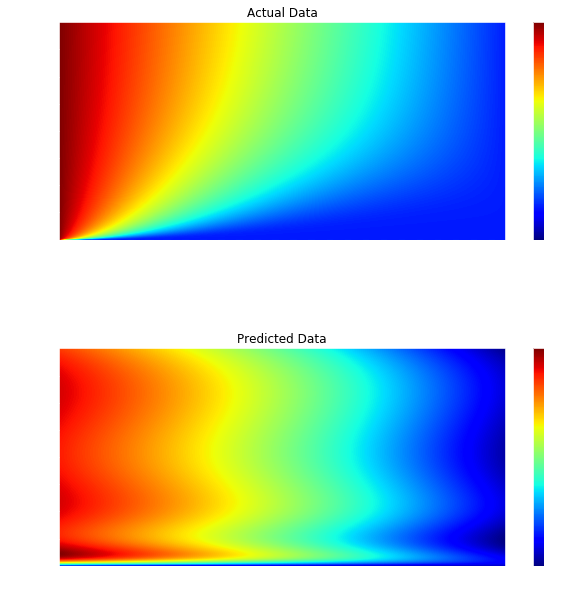

In [147]:
plot_subplots(np.array(psol_norm).reshape(1000, 1500), u_pred.reshape(1000, -1))

In [150]:
XT_norm = scaler.fit_transform(data[['X', 'T']])

In [151]:
X = XT_norm[:, 0].reshape(1000, 1500)
T = XT_norm[:, 1].reshape(1000, 1500)
u_pred = u_pred[:, None].reshape(1000, 1500)
psol_norm = psol_norm[:, None].reshape(1000, 1500)

In [154]:
def plot_actual_vs_predicted(x, u_data, u_preds, time_intervals):
    
    fig = plt.figure(figsize = (15, 15))
    fig.subplots_adjust(hspace = 0.75)
    gs = fig.add_gridspec(1 , len(time_intervals))

    
    for index, time in enumerate(time_intervals):
        ax = fig.add_subplot(gs[:, index], )
        ax.plot(x, u_data[time,:], 'b-', linewidth = 2, label = 'Exact')       
        ax.plot(x, u_preds[time,:], 'r--', linewidth = 2, label = 'Prediction')
        
        ax.set_xlabel('$x$')
        ax.set_ylabel('$u(t,x)$')    
        ax.set_title(f'$t = 0.{time}$', fontsize = 10, color ='white')
        ax.axis('square')
#         ax.set_xlim([-1.1, 1.1])
#         ax.set_ylim([-1.1, 1.1])
    legend = ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.35), ncol=5, frameon=False)
    plt.setp(legend.get_texts(), color='w')
    plt.savefig('./images/part_2_actualvspredicted', dpi = 1200, transparent = True)

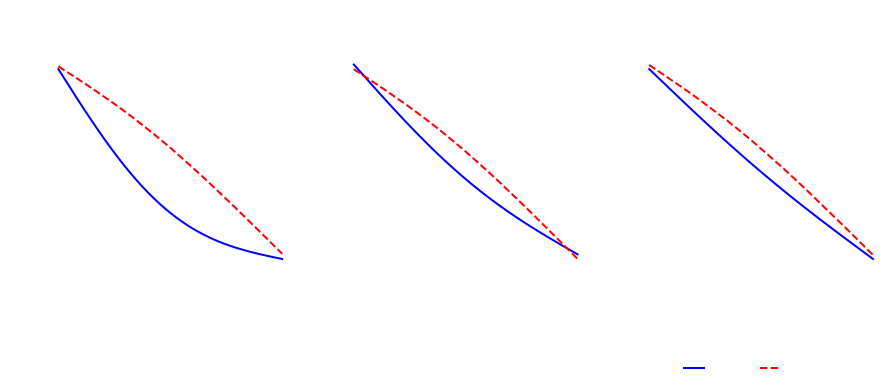

In [155]:
plot_actual_vs_predicted(X[0, :], psol_norm, u_pred, [250, 500, 750])

# 1D Diffusivity (Homogeneous) - Part III

## Imports

In [156]:
import time

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Dense
from keras.models import Model
from keras import optimizers

# Scientific Libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.interpolate import BSpline
import pandas as pd

# Graphing Libraries
import matplotlib.gridspec as gridspec
from scipy.interpolate import griddata
from mpl_toolkits import mplot3d
from mpl_toolkits.axes_grid1 import make_axes_locatable

# For Train - Validation - Test
from sklearn.model_selection import train_test_split
from sklearn import preprocessing 
from sklearn.metrics import mean_squared_error

# For collocation points
from pyDOE import lhs
print(tf.__version__)

%matplotlib inline
# %matplotlib notebook
# Tensorboard

1.13.1


In [157]:
data = pd.read_csv('./data/1D_Diffusivity')

In [158]:
LAYERS = [2, 50, 50, 50, 50, 50, 50, 50, 50, 1]

## Resample Actual Data

In [159]:
from sklearn.utils import resample

In [160]:
def resample_and_run(n_samples, true_data, train_data, N_u, layers,
                     num_iter_adam, num_iter_op, adam = False, both = False):
    
    true_solution_sample = resample(true_data, n_samples = n_samples)
    train_data = pd.concat((train_data, true_solution_sample), axis=0, 
                           ignore_index = True, sort = False)

    XT_train = train_data[['X', 'T']]
    p_train = train_data['psol']

    random_idx = np.random.choice(XT_train.shape[0], N_u, replace = False)
    XT_train = XT_train.iloc[random_idx, :]
    p_train = p_train.iloc[random_idx]
    
    scaler = preprocessing.MinMaxScaler()

    XT_norm = scaler.fit_transform(XT_train)
    p_norm = scaler.fit_transform(p_train[:, None])

    lower_bound = XT_norm.min(0)
    upper_bound = XT_norm.max(0)

    model = PhysicsInformedNN(pd.DataFrame(XT_norm), p_norm,
                          layers = layers, 
                          num_iter = num_iter_op, 
                          lower_bound = lower_bound, 
                          upper_bound = upper_bound)

    model.train(num_iter_adam, adam, both)
    
    u_pred = model.predict(pd.DataFrame(scaler.fit_transform(true_data[['X', 'T']])));
    
    return u_pred, model

In [167]:
n_resample = [500, 1000, 1500]
preds = []
models = []

for n in n_resample:
    p_preds, model = resample_and_run(n_samples = n, true_data = data, train_data = df_train, 
                               N_u = 1000, layers = LAYERS, num_iter_adam = 1000, 
                               num_iter_op = 1000, adam = True, both = True)
    preds.append(p_preds)
    models.append(model)

[-0.48176384  0.87064011]
It: 0, Loss: 1.928e-01, Lambda_1: 0.617, Lambda_2: 0.869694, Time: 4.30
It: 10, Loss: 1.312e-01, Lambda_1: 0.618, Lambda_2: 0.860717, Time: 7.55
It: 20, Loss: 9.199e-02, Lambda_1: 0.612, Lambda_2: 0.851725, Time: 8.02
It: 30, Loss: 7.673e-02, Lambda_1: 0.607, Lambda_2: 0.841036, Time: 8.48
It: 40, Loss: 6.475e-02, Lambda_1: 0.601, Lambda_2: 0.831240, Time: 9.11
It: 50, Loss: 5.612e-02, Lambda_1: 0.596, Lambda_2: 0.820164, Time: 9.59
It: 60, Loss: 4.716e-02, Lambda_1: 0.593, Lambda_2: 0.808900, Time: 10.07
It: 70, Loss: 3.432e-02, Lambda_1: 0.591, Lambda_2: 0.797476, Time: 10.54
It: 80, Loss: 3.166e-02, Lambda_1: 0.589, Lambda_2: 0.789260, Time: 11.18
It: 90, Loss: 3.023e-02, Lambda_1: 0.587, Lambda_2: 0.785933, Time: 11.69
It: 100, Loss: 2.917e-02, Lambda_1: 0.585, Lambda_2: 0.784375, Time: 12.14
It: 110, Loss: 2.873e-02, Lambda_1: 0.584, Lambda_2: 0.784287, Time: 12.75
It: 120, Loss: 2.841e-02, Lambda_1: 0.582, Lambda_2: 0.785386, Time: 13.20
It: 130, Loss: 2

Loss: 7.363205e-03, l1: 0.48595, l2: 0.85971
Loss: 7.317510e-03, l1: 0.48545, l2: 0.85757
Loss: 7.302599e-03, l1: 0.48541, l2: 0.85710
Loss: 7.296575e-03, l1: 0.48522, l2: 0.85647
Loss: 7.289345e-03, l1: 0.48523, l2: 0.85645
Loss: 7.268572e-03, l1: 0.48515, l2: 0.85579
Loss: 7.249638e-03, l1: 0.48472, l2: 0.85389
Loss: 7.237774e-03, l1: 0.48442, l2: 0.85252
Loss: 7.232791e-03, l1: 0.48419, l2: 0.85158
Loss: 7.229771e-03, l1: 0.48405, l2: 0.85104
Loss: 7.222814e-03, l1: 0.48381, l2: 0.85008
Loss: 7.211548e-03, l1: 0.48354, l2: 0.84891
Loss: 7.190100e-03, l1: 0.48312, l2: 0.84718
Loss: 7.159138e-03, l1: 0.48243, l2: 0.84493
Loss: 7.132057e-03, l1: 0.48202, l2: 0.84414
Loss: 7.114470e-03, l1: 0.48138, l2: 0.84278
Loss: 7.097948e-03, l1: 0.48099, l2: 0.84260
Loss: 7.059625e-03, l1: 0.47962, l2: 0.83968
Loss: 6.955088e-03, l1: 0.47500, l2: 0.82961
Loss: 6.852752e-03, l1: 0.47168, l2: 0.82223
Loss: 6.770228e-03, l1: 0.46503, l2: 0.80556
Loss: 6.881666e-03, l1: 0.46334, l2: 0.80308
Loss: 6.71

Loss: 2.330165e-03, l1: 0.19611, l2: 0.51563
Loss: 2.311301e-03, l1: 0.19146, l2: 0.50368
Loss: 2.291245e-03, l1: 0.19168, l2: 0.50690
Loss: 2.260666e-03, l1: 0.19061, l2: 0.50333
Loss: 2.248925e-03, l1: 0.18874, l2: 0.49924
Loss: 2.235522e-03, l1: 0.18824, l2: 0.49866
Loss: 2.232515e-03, l1: 0.18569, l2: 0.49322
Loss: 2.223333e-03, l1: 0.18579, l2: 0.49382
Loss: 2.218647e-03, l1: 0.18418, l2: 0.49059
Loss: 2.215387e-03, l1: 0.18304, l2: 0.48827
Loss: 2.212875e-03, l1: 0.18237, l2: 0.48705
Loss: 2.209543e-03, l1: 0.18190, l2: 0.48623
Loss: 2.206957e-03, l1: 0.18170, l2: 0.48595
Loss: 2.204190e-03, l1: 0.18136, l2: 0.48474
Loss: 2.201169e-03, l1: 0.18121, l2: 0.48420
Loss: 2.196153e-03, l1: 0.17872, l2: 0.47846
Loss: 2.191534e-03, l1: 0.17890, l2: 0.47851
Loss: 2.188132e-03, l1: 0.17775, l2: 0.47597
Loss: 2.184460e-03, l1: 0.17621, l2: 0.47288
Loss: 2.180590e-03, l1: 0.17506, l2: 0.47043
Loss: 2.173566e-03, l1: 0.17323, l2: 0.46642
Loss: 2.162308e-03, l1: 0.17033, l2: 0.45985
Loss: 2.18

Loss: 1.365042e-03, l1: 0.10953, l2: 0.32664
Loss: 1.362366e-03, l1: 0.10996, l2: 0.32771
Loss: 1.381252e-03, l1: 0.11139, l2: 0.33065
Loss: 1.360977e-03, l1: 0.11025, l2: 0.32833
Loss: 1.357548e-03, l1: 0.11098, l2: 0.32951
Loss: 1.353746e-03, l1: 0.11153, l2: 0.33070
Loss: 1.348867e-03, l1: 0.11245, l2: 0.33310
Loss: 1.343450e-03, l1: 0.11265, l2: 0.33307
Loss: 1.336246e-03, l1: 0.11274, l2: 0.33286
Loss: 1.331902e-03, l1: 0.11272, l2: 0.33228
Loss: 1.328374e-03, l1: 0.11214, l2: 0.33084
Loss: 1.325235e-03, l1: 0.11237, l2: 0.33172
Loss: 1.321551e-03, l1: 0.11201, l2: 0.33141
Loss: 1.315463e-03, l1: 0.11131, l2: 0.32919
Loss: 1.396031e-03, l1: 0.10779, l2: 0.31982
Loss: 1.311478e-03, l1: 0.11052, l2: 0.32711
Loss: 1.305991e-03, l1: 0.10924, l2: 0.32174
Loss: 1.306826e-03, l1: 0.11022, l2: 0.32293
Loss: 1.301433e-03, l1: 0.10971, l2: 0.32231
Loss: 1.297877e-03, l1: 0.10934, l2: 0.31980
Loss: 1.294638e-03, l1: 0.10920, l2: 0.31936
Loss: 1.289444e-03, l1: 0.10890, l2: 0.31824
Loss: 1.28

Loss: 1.100040e-03, l1: 0.08687, l2: 0.24314
Loss: 1.097348e-03, l1: 0.08642, l2: 0.24263
Loss: 1.095666e-03, l1: 0.08655, l2: 0.24283
Loss: 1.093673e-03, l1: 0.08629, l2: 0.24203
Loss: 1.091644e-03, l1: 0.08601, l2: 0.24169
Loss: 1.095915e-03, l1: 0.08504, l2: 0.23803
Loss: 1.091038e-03, l1: 0.08575, l2: 0.24071
Loss: 1.089711e-03, l1: 0.08553, l2: 0.24037
Loss: 1.089329e-03, l1: 0.08417, l2: 0.23676
Loss: 1.088336e-03, l1: 0.08490, l2: 0.23869
Loss: 1.085959e-03, l1: 0.08414, l2: 0.23727
Loss: 1.084268e-03, l1: 0.08312, l2: 0.23531
Loss: 1.084464e-03, l1: 0.08204, l2: 0.23393
Loss: 1.082417e-03, l1: 0.08256, l2: 0.23460
Loss: 1.081219e-03, l1: 0.08238, l2: 0.23478
Loss: 1.079093e-03, l1: 0.08145, l2: 0.23335
Loss: 1.077270e-03, l1: 0.08118, l2: 0.23231
Loss: 1.075424e-03, l1: 0.08089, l2: 0.23255
Loss: 1.071180e-03, l1: 0.07970, l2: 0.22978
Loss: 1.069284e-03, l1: 0.07670, l2: 0.22429
Loss: 1.066015e-03, l1: 0.07686, l2: 0.22487
Loss: 1.065480e-03, l1: 0.07661, l2: 0.22429
Loss: 1.06

Loss: 8.783006e-04, l1: 0.01714, l2: 0.06092
Loss: 8.775686e-04, l1: 0.01697, l2: 0.06034
Loss: 8.766857e-04, l1: 0.01687, l2: 0.05983
Loss: 8.752444e-04, l1: 0.01690, l2: 0.05985
Loss: 8.732486e-04, l1: 0.01674, l2: 0.05948
Loss: 8.712143e-04, l1: 0.01649, l2: 0.05875
Loss: 8.704941e-04, l1: 0.01644, l2: 0.05833
Loss: 8.690419e-04, l1: 0.01646, l2: 0.05841
Loss: 8.684805e-04, l1: 0.01646, l2: 0.05828
Loss: 8.679825e-04, l1: 0.01657, l2: 0.05850
Loss: 8.674820e-04, l1: 0.01662, l2: 0.05848
Loss: 8.666368e-04, l1: 0.01667, l2: 0.05850
Loss: 8.656726e-04, l1: 0.01673, l2: 0.05860
Loss: 8.642758e-04, l1: 0.01675, l2: 0.05884
Loss: 8.630996e-04, l1: 0.01668, l2: 0.05875
Loss: 8.625429e-04, l1: 0.01667, l2: 0.05918
Loss: 8.614717e-04, l1: 0.01655, l2: 0.05885
Loss: 8.607340e-04, l1: 0.01646, l2: 0.05862
Loss: 8.600777e-04, l1: 0.01631, l2: 0.05828
Loss: 8.597068e-04, l1: 0.01624, l2: 0.05831
Loss: 8.594478e-04, l1: 0.01623, l2: 0.05847
Loss: 8.590566e-04, l1: 0.01621, l2: 0.05873
Loss: 8.58

Loss: 7.090914e-04, l1: 0.00997, l2: 0.03705
Loss: 7.081862e-04, l1: 0.00995, l2: 0.03692
Loss: 7.076124e-04, l1: 0.01000, l2: 0.03717
Loss: 7.060365e-04, l1: 0.00990, l2: 0.03677
Loss: 7.049317e-04, l1: 0.00978, l2: 0.03660
Loss: 7.033920e-04, l1: 0.00968, l2: 0.03655
Loss: 7.025868e-04, l1: 0.00962, l2: 0.03661
Loss: 7.014049e-04, l1: 0.00961, l2: 0.03669
Loss: 7.002190e-04, l1: 0.00960, l2: 0.03668
Loss: 6.985140e-04, l1: 0.00948, l2: 0.03648
Loss: 6.978543e-04, l1: 0.00954, l2: 0.03658
Loss: 6.953154e-04, l1: 0.00947, l2: 0.03639
Loss: 6.947503e-04, l1: 0.00943, l2: 0.03627
Loss: 6.933636e-04, l1: 0.00946, l2: 0.03628
Loss: 6.927976e-04, l1: 0.00936, l2: 0.03612
Loss: 7.036754e-04, l1: 0.00939, l2: 0.03643
Loss: 6.926086e-04, l1: 0.00936, l2: 0.03615
Loss: 6.919404e-04, l1: 0.00934, l2: 0.03605
Loss: 6.900536e-04, l1: 0.00917, l2: 0.03545
Loss: 6.873464e-04, l1: 0.00896, l2: 0.03497
Loss: 7.366292e-04, l1: 0.00836, l2: 0.03291
Loss: 6.864077e-04, l1: 0.00885, l2: 0.03461
Loss: 7.66

It: 650, Loss: 7.012e-03, Lambda_1: 0.228, Lambda_2: 0.477600, Time: 41.44
It: 660, Loss: 5.585e-03, Lambda_1: 0.228, Lambda_2: 0.476084, Time: 41.91
It: 670, Loss: 5.319e-03, Lambda_1: 0.228, Lambda_2: 0.475377, Time: 42.39
It: 680, Loss: 5.253e-03, Lambda_1: 0.228, Lambda_2: 0.475082, Time: 43.04
It: 690, Loss: 5.103e-03, Lambda_1: 0.227, Lambda_2: 0.474901, Time: 43.50
It: 700, Loss: 5.028e-03, Lambda_1: 0.227, Lambda_2: 0.474596, Time: 43.98
It: 710, Loss: 4.955e-03, Lambda_1: 0.227, Lambda_2: 0.474209, Time: 44.46
It: 720, Loss: 4.887e-03, Lambda_1: 0.227, Lambda_2: 0.473759, Time: 45.09
It: 730, Loss: 4.821e-03, Lambda_1: 0.227, Lambda_2: 0.473307, Time: 45.56
It: 740, Loss: 4.755e-03, Lambda_1: 0.227, Lambda_2: 0.472858, Time: 46.04
It: 750, Loss: 4.690e-03, Lambda_1: 0.227, Lambda_2: 0.472419, Time: 46.70
It: 760, Loss: 4.912e-03, Lambda_1: 0.227, Lambda_2: 0.472012, Time: 47.16
It: 770, Loss: 8.576e-03, Lambda_1: 0.227, Lambda_2: 0.470252, Time: 47.64
It: 780, Loss: 6.904e-03,

Loss: 1.663954e-03, l1: 0.13259, l2: 0.33144
Loss: 1.649433e-03, l1: 0.13159, l2: 0.32849
Loss: 1.633499e-03, l1: 0.13069, l2: 0.32463
Loss: 1.619344e-03, l1: 0.12976, l2: 0.32127
Loss: 1.607885e-03, l1: 0.13047, l2: 0.32011
Loss: 1.601402e-03, l1: 0.13055, l2: 0.31999
Loss: 1.598518e-03, l1: 0.13152, l2: 0.32189
Loss: 1.600549e-03, l1: 0.13110, l2: 0.32187
Loss: 1.596915e-03, l1: 0.13135, l2: 0.32188
Loss: 1.594521e-03, l1: 0.13165, l2: 0.32228
Loss: 1.592120e-03, l1: 0.13186, l2: 0.32246
Loss: 1.588076e-03, l1: 0.13201, l2: 0.32215
Loss: 1.581819e-03, l1: 0.13175, l2: 0.32129
Loss: 1.566467e-03, l1: 0.13030, l2: 0.31783
Loss: 1.551238e-03, l1: 0.12825, l2: 0.31337
Loss: 1.543710e-03, l1: 0.12581, l2: 0.30815
Loss: 1.532803e-03, l1: 0.12616, l2: 0.30801
Loss: 1.518479e-03, l1: 0.12574, l2: 0.30674
Loss: 1.502464e-03, l1: 0.12175, l2: 0.29802
Loss: 1.487170e-03, l1: 0.12214, l2: 0.29939
Loss: 1.468897e-03, l1: 0.11996, l2: 0.29470
Loss: 1.504918e-03, l1: 0.11256, l2: 0.27790
Loss: 1.45

Loss: 8.563618e-04, l1: 0.04893, l2: 0.09879
Loss: 8.535283e-04, l1: 0.04838, l2: 0.09640
Loss: 8.508935e-04, l1: 0.04853, l2: 0.09697
Loss: 8.468943e-04, l1: 0.04804, l2: 0.09611
Loss: 8.448595e-04, l1: 0.04759, l2: 0.09477
Loss: 8.424650e-04, l1: 0.04730, l2: 0.09393
Loss: 8.379528e-04, l1: 0.04684, l2: 0.09242
Loss: 8.342697e-04, l1: 0.04634, l2: 0.09079
Loss: 8.920128e-04, l1: 0.04593, l2: 0.08875
Loss: 8.335686e-04, l1: 0.04630, l2: 0.09058
Loss: 8.320835e-04, l1: 0.04541, l2: 0.08745
Loss: 8.320736e-04, l1: 0.04550, l2: 0.08765
Loss: 8.286511e-04, l1: 0.04545, l2: 0.08755
Loss: 8.266974e-04, l1: 0.04524, l2: 0.08735
Loss: 8.236069e-04, l1: 0.04510, l2: 0.08702
Loss: 8.198314e-04, l1: 0.04462, l2: 0.08560
Loss: 8.156800e-04, l1: 0.04390, l2: 0.08381
Loss: 8.082816e-04, l1: 0.04275, l2: 0.08134
Loss: 8.022574e-04, l1: 0.04158, l2: 0.07949
Loss: 1.188279e-03, l1: 0.03682, l2: 0.06760
Loss: 7.985673e-04, l1: 0.04080, l2: 0.07764
Loss: 7.950176e-04, l1: 0.04043, l2: 0.07724
Loss: 7.90

Loss: 5.445678e-04, l1: 0.01808, l2: 0.02284
Loss: 1.235590e-03, l1: 0.01694, l2: 0.02254
Loss: 5.447408e-04, l1: 0.01797, l2: 0.02281
Loss: 5.440227e-04, l1: 0.01803, l2: 0.02282
Loss: 5.922186e-04, l1: 0.01415, l2: 0.01320
Loss: 5.320715e-04, l1: 0.01649, l2: 0.01929
Loss: 5.312872e-04, l1: 0.01564, l2: 0.01778
Loss: 5.294646e-04, l1: 0.01608, l2: 0.01857
Loss: 5.562116e-04, l1: 0.01517, l2: 0.01821
Loss: 5.273840e-04, l1: 0.01588, l2: 0.01849
Loss: 5.246400e-04, l1: 0.01513, l2: 0.01696
Loss: 5.231459e-04, l1: 0.01521, l2: 0.01715
Loss: 5.229300e-04, l1: 0.01542, l2: 0.01821
Loss: 5.213142e-04, l1: 0.01532, l2: 0.01770
Loss: 5.199141e-04, l1: 0.01514, l2: 0.01737
Loss: 5.248464e-04, l1: 0.01548, l2: 0.01880
Loss: 5.196034e-04, l1: 0.01520, l2: 0.01765
Loss: 5.294649e-04, l1: 0.01473, l2: 0.01693
Loss: 5.187413e-04, l1: 0.01510, l2: 0.01749
Loss: 5.172270e-04, l1: 0.01506, l2: 0.01751
Loss: 5.183046e-04, l1: 0.01475, l2: 0.01709
Loss: 5.167859e-04, l1: 0.01495, l2: 0.01736
Loss: 5.15

Loss: 2.965031e-04, l1: 0.00578, l2: 0.00254
Loss: 2.962689e-04, l1: 0.00576, l2: 0.00246
Loss: 2.961342e-04, l1: 0.00572, l2: 0.00250
Loss: 2.958695e-04, l1: 0.00570, l2: 0.00241
Loss: 2.954457e-04, l1: 0.00563, l2: 0.00231
Loss: 2.951068e-04, l1: 0.00558, l2: 0.00233
Loss: 2.948751e-04, l1: 0.00550, l2: 0.00238
Loss: 2.947095e-04, l1: 0.00548, l2: 0.00243
Loss: 2.945433e-04, l1: 0.00548, l2: 0.00238
Loss: 2.945140e-04, l1: 0.00547, l2: 0.00233
Loss: 2.944368e-04, l1: 0.00547, l2: 0.00237
Loss: 2.944086e-04, l1: 0.00547, l2: 0.00236
Loss: 2.943529e-04, l1: 0.00546, l2: 0.00238
Loss: 2.942980e-04, l1: 0.00545, l2: 0.00235
Loss: 2.942799e-04, l1: 0.00545, l2: 0.00239
Loss: 2.941497e-04, l1: 0.00544, l2: 0.00236
Loss: 2.940830e-04, l1: 0.00545, l2: 0.00235
Loss: 2.939816e-04, l1: 0.00546, l2: 0.00238
Loss: 2.937516e-04, l1: 0.00548, l2: 0.00245
Loss: 2.933096e-04, l1: 0.00550, l2: 0.00255
Loss: 2.924516e-04, l1: 0.00551, l2: 0.00269
Loss: 3.088287e-04, l1: 0.00549, l2: 0.00237
Loss: 2.92

Loss: 2.289896e-04, l1: 0.00356, l2: 0.00154
Loss: 2.288958e-04, l1: 0.00357, l2: 0.00155
Loss: 2.288035e-04, l1: 0.00358, l2: 0.00155
Loss: 2.287172e-04, l1: 0.00360, l2: 0.00155
Loss: 2.286225e-04, l1: 0.00361, l2: 0.00153
Loss: 2.284832e-04, l1: 0.00365, l2: 0.00158
Loss: 2.283889e-04, l1: 0.00365, l2: 0.00161
Loss: 2.283039e-04, l1: 0.00366, l2: 0.00162
Loss: 2.281740e-04, l1: 0.00364, l2: 0.00164
Loss: 2.280026e-04, l1: 0.00367, l2: 0.00166
Loss: 2.277970e-04, l1: 0.00366, l2: 0.00162
Loss: 2.275664e-04, l1: 0.00366, l2: 0.00159
Loss: 2.283359e-04, l1: 0.00365, l2: 0.00157
Loss: 2.274479e-04, l1: 0.00366, l2: 0.00158
Loss: 2.271451e-04, l1: 0.00365, l2: 0.00157
Loss: 2.266808e-04, l1: 0.00361, l2: 0.00154
Loss: 2.263372e-04, l1: 0.00356, l2: 0.00149
Loss: 2.275412e-04, l1: 0.00347, l2: 0.00130
Loss: 2.259694e-04, l1: 0.00353, l2: 0.00142
Loss: 2.256343e-04, l1: 0.00350, l2: 0.00129
Loss: 2.250643e-04, l1: 0.00341, l2: 0.00111
Loss: 2.249414e-04, l1: 0.00339, l2: 0.00110
Loss: 2.24

It: 230, Loss: 2.706e-02, Lambda_1: 0.419, Lambda_2: 0.101089, Time: 19.23
It: 240, Loss: 2.670e-02, Lambda_1: 0.418, Lambda_2: 0.106409, Time: 19.72
It: 250, Loss: 2.639e-02, Lambda_1: 0.416, Lambda_2: 0.111984, Time: 20.22
It: 260, Loss: 2.742e-02, Lambda_1: 0.415, Lambda_2: 0.117903, Time: 20.87
It: 270, Loss: 2.612e-02, Lambda_1: 0.414, Lambda_2: 0.124279, Time: 21.37
It: 280, Loss: 2.489e-02, Lambda_1: 0.413, Lambda_2: 0.130761, Time: 21.87
It: 290, Loss: 2.396e-02, Lambda_1: 0.412, Lambda_2: 0.136872, Time: 22.53
It: 300, Loss: 2.259e-02, Lambda_1: 0.411, Lambda_2: 0.142546, Time: 23.02
It: 310, Loss: 2.193e-02, Lambda_1: 0.411, Lambda_2: 0.147015, Time: 23.54
It: 320, Loss: 2.061e-02, Lambda_1: 0.410, Lambda_2: 0.149764, Time: 24.02
It: 330, Loss: 2.030e-02, Lambda_1: 0.409, Lambda_2: 0.150782, Time: 24.69
It: 340, Loss: 1.858e-02, Lambda_1: 0.408, Lambda_2: 0.148870, Time: 25.18
It: 350, Loss: 1.779e-02, Lambda_1: 0.407, Lambda_2: 0.144633, Time: 25.66
It: 360, Loss: 1.710e-02,

Loss: 7.714328e-03, l1: 0.21997, l2: 0.14161
Loss: 7.670076e-03, l1: 0.21716, l2: 0.13865
Loss: 7.602599e-03, l1: 0.21211, l2: 0.13470
Loss: 7.532112e-03, l1: 0.20783, l2: 0.13331
Loss: 7.488419e-03, l1: 0.20284, l2: 0.13084
Loss: 7.475281e-03, l1: 0.20400, l2: 0.13378
Loss: 7.463468e-03, l1: 0.20291, l2: 0.13164
Loss: 7.457638e-03, l1: 0.20294, l2: 0.13211
Loss: 7.447084e-03, l1: 0.20277, l2: 0.13336
Loss: 7.433072e-03, l1: 0.20242, l2: 0.13630
Loss: 7.424946e-03, l1: 0.20234, l2: 0.13764
Loss: 7.412042e-03, l1: 0.20262, l2: 0.14057
Loss: 7.403742e-03, l1: 0.20338, l2: 0.14149
Loss: 7.392223e-03, l1: 0.20407, l2: 0.14214
Loss: 7.380005e-03, l1: 0.20490, l2: 0.14181
Loss: 7.364548e-03, l1: 0.20478, l2: 0.14019
Loss: 7.327015e-03, l1: 0.20378, l2: 0.13641
Loss: 7.237092e-03, l1: 0.19912, l2: 0.12589
Loss: 7.066480e-03, l1: 0.18753, l2: 0.10467
Loss: 6.872875e-03, l1: 0.17359, l2: 0.09022
Loss: 7.713375e-03, l1: 0.15146, l2: 0.05277
Loss: 6.760849e-03, l1: 0.16687, l2: 0.07937
Loss: 6.55

Loss: 1.815289e-03, l1: 0.00179, l2: 0.00047
Loss: 1.588404e-03, l1: 0.00222, l2: 0.00090
Loss: 1.570475e-03, l1: 0.00187, l2: 0.00105
Loss: 1.535903e-03, l1: 0.00205, l2: 0.00097
Loss: 1.580772e-03, l1: 0.00173, l2: 0.00111
Loss: 1.510117e-03, l1: 0.00192, l2: 0.00102
Loss: 1.509883e-03, l1: 0.00179, l2: 0.00096
Loss: 1.501600e-03, l1: 0.00186, l2: 0.00099
Loss: 1.501538e-03, l1: 0.00186, l2: 0.00106
Loss: 1.495142e-03, l1: 0.00186, l2: 0.00102
Loss: 1.488564e-03, l1: 0.00180, l2: 0.00097
Loss: 1.480193e-03, l1: 0.00179, l2: 0.00089
Loss: 1.474700e-03, l1: 0.00177, l2: 0.00094
Loss: 1.476759e-03, l1: 0.00169, l2: 0.00099
Loss: 1.471749e-03, l1: 0.00173, l2: 0.00096
Loss: 1.466471e-03, l1: 0.00172, l2: 0.00096
Loss: 1.446053e-03, l1: 0.00163, l2: 0.00087
Loss: 1.432552e-03, l1: 0.00165, l2: 0.00087
Loss: 1.417749e-03, l1: 0.00157, l2: 0.00078
Loss: 1.406112e-03, l1: 0.00151, l2: 0.00074
Loss: 1.395997e-03, l1: 0.00141, l2: 0.00069
Loss: 1.384555e-03, l1: 0.00133, l2: 0.00066
Loss: 1.38

Loss: 6.538195e-04, l1: 0.00011, l2: 0.00014
Loss: 6.476038e-04, l1: 0.00011, l2: 0.00014
Loss: 6.439490e-04, l1: 0.00011, l2: 0.00013
Loss: 6.381320e-04, l1: 0.00011, l2: 0.00013
Loss: 6.318020e-04, l1: 0.00012, l2: 0.00015
Loss: 6.226121e-04, l1: 0.00012, l2: 0.00018
Loss: 6.512899e-04, l1: 0.00013, l2: 0.00017
Loss: 6.206607e-04, l1: 0.00012, l2: 0.00017
Loss: 6.141538e-04, l1: 0.00013, l2: 0.00020
Loss: 6.118497e-04, l1: 0.00013, l2: 0.00022
Loss: 6.097403e-04, l1: 0.00013, l2: 0.00022
Loss: 6.090034e-04, l1: 0.00013, l2: 0.00022
Loss: 6.088231e-04, l1: 0.00013, l2: 0.00022
Loss: 6.075207e-04, l1: 0.00013, l2: 0.00022
Loss: 6.070234e-04, l1: 0.00013, l2: 0.00022
Loss: 6.064083e-04, l1: 0.00012, l2: 0.00021
Loss: 6.118456e-04, l1: 0.00012, l2: 0.00028
Loss: 6.062083e-04, l1: 0.00012, l2: 0.00022
Loss: 6.055469e-04, l1: 0.00012, l2: 0.00022
Loss: 6.029216e-04, l1: 0.00012, l2: 0.00020
Loss: 5.979080e-04, l1: 0.00012, l2: 0.00019
Loss: 5.896135e-04, l1: 0.00011, l2: 0.00018
Loss: 5.80

Loss: 1.500675e-04, l1: 0.00001, l2: 0.00013
Loss: 1.498462e-04, l1: 0.00001, l2: 0.00013
Loss: 1.496182e-04, l1: 0.00001, l2: 0.00013
Loss: 1.492427e-04, l1: 0.00001, l2: 0.00013
Loss: 1.487881e-04, l1: 0.00001, l2: 0.00014
Loss: 1.476608e-04, l1: 0.00001, l2: 0.00013
Loss: 1.460285e-04, l1: 0.00001, l2: 0.00013
Loss: 1.654687e-04, l1: 0.00001, l2: 0.00011
Loss: 1.455164e-04, l1: 0.00001, l2: 0.00013
Loss: 1.449956e-04, l1: 0.00001, l2: 0.00012
Loss: 1.446377e-04, l1: 0.00001, l2: 0.00011
Loss: 1.444474e-04, l1: 0.00001, l2: 0.00012
Loss: 1.443527e-04, l1: 0.00001, l2: 0.00011
Loss: 1.442707e-04, l1: 0.00001, l2: 0.00011
Loss: 1.441829e-04, l1: 0.00001, l2: 0.00012
Loss: 1.440964e-04, l1: 0.00001, l2: 0.00012
Loss: 1.440145e-04, l1: 0.00001, l2: 0.00012
Loss: 1.437904e-04, l1: 0.00001, l2: 0.00011
Loss: 1.435589e-04, l1: 0.00001, l2: 0.00012
Loss: 1.469072e-04, l1: 0.00001, l2: -0.00000
Loss: 1.434738e-04, l1: 0.00001, l2: 0.00010
Loss: 1.431203e-04, l1: 0.00001, l2: 0.00011
Loss: 1.4

Loss: 8.993470e-05, l1: 0.00000, l2: 0.00006
Loss: 8.956865e-05, l1: 0.00000, l2: 0.00006
Loss: 8.918895e-05, l1: 0.00000, l2: 0.00007
Loss: 8.885213e-05, l1: 0.00000, l2: 0.00008
Loss: 8.866627e-05, l1: 0.00000, l2: 0.00009
Loss: 8.839453e-05, l1: 0.00000, l2: 0.00008
Loss: 8.788081e-05, l1: 0.00000, l2: 0.00007
Loss: 8.735320e-05, l1: 0.00000, l2: 0.00007
Loss: 8.692455e-05, l1: 0.00000, l2: 0.00007
Loss: 8.670522e-05, l1: 0.00000, l2: 0.00008
Loss: 8.613281e-05, l1: 0.00000, l2: 0.00009
Loss: 8.590244e-05, l1: 0.00000, l2: 0.00009
Loss: 8.559895e-05, l1: 0.00000, l2: 0.00009
Loss: 8.546073e-05, l1: 0.00000, l2: 0.00009
Loss: 8.524413e-05, l1: 0.00000, l2: 0.00008
Loss: 8.478387e-05, l1: 0.00000, l2: 0.00007
Loss: 8.438381e-05, l1: 0.00000, l2: 0.00007
Loss: 8.602721e-05, l1: 0.00000, l2: 0.00009
Loss: 8.410438e-05, l1: 0.00000, l2: 0.00008
Loss: 8.387159e-05, l1: 0.00000, l2: 0.00008
Loss: 8.424476e-05, l1: 0.00000, l2: 0.00009
Loss: 8.379510e-05, l1: 0.00000, l2: 0.00009
Loss: 8.37

Loss: 6.959528e-05, l1: 0.00000, l2: 0.00005
Loss: 6.956112e-05, l1: 0.00000, l2: 0.00006
Loss: 6.954243e-05, l1: 0.00000, l2: 0.00006
Loss: 6.952399e-05, l1: 0.00000, l2: 0.00006
Loss: 6.951854e-05, l1: 0.00000, l2: 0.00006
Loss: 6.949577e-05, l1: 0.00000, l2: 0.00006
Loss: 6.948355e-05, l1: 0.00000, l2: 0.00006
Loss: 6.947223e-05, l1: 0.00000, l2: 0.00006
Loss: 6.946710e-05, l1: 0.00000, l2: 0.00006
Loss: 6.946155e-05, l1: 0.00000, l2: 0.00006
Loss: 6.945395e-05, l1: 0.00000, l2: 0.00006
Loss: 6.944911e-05, l1: 0.00000, l2: 0.00006
Loss: 6.944493e-05, l1: 0.00000, l2: 0.00006
Loss: 6.944107e-05, l1: 0.00000, l2: 0.00006
Loss: 6.943555e-05, l1: 0.00000, l2: 0.00006
Loss: 6.942801e-05, l1: 0.00000, l2: 0.00006
Loss: 6.942208e-05, l1: 0.00000, l2: 0.00006
Loss: 6.940945e-05, l1: 0.00000, l2: 0.00006
Loss: 6.939098e-05, l1: 0.00000, l2: 0.00006
Loss: 6.935895e-05, l1: 0.00000, l2: 0.00006
Loss: 6.936894e-05, l1: 0.00000, l2: 0.00007
Loss: 6.932378e-05, l1: 0.00000, l2: 0.00007
Loss: 6.92

## Evaluate

In [169]:
nu = 0.00163
scaler = preprocessing.MinMaxScaler()
psol_norm = scaler.fit_transform(data['psol'][:, None])

In [170]:
for index in range(len(preds)):
    print('---------------------------------------------------')
    print(f'Iteration # {index} / Resample Size: {n_resample[index]}')
    print('\n')
#     evaluate(preds[index], psol_norm, nu, models[index])

---------------------------------------------------
Iteration # 0 / Resample Size: 500


---------------------------------------------------
Iteration # 1 / Resample Size: 1000


---------------------------------------------------
Iteration # 2 / Resample Size: 1500




## Plotting

In [171]:
def plot_all_subplots(u_data, u_pred_data, n_resample):
    
    extent = [0, 1, -1, 1]
    params = {"ytick.color" : "w",
          "xtick.color" : "w",
          "axes.labelcolor" : "w",
          "axes.edgecolor" : "w"}
    plt.rcParams.update(params)

    fig = plt.figure(figsize = (15, 10))
    fig.subplots_adjust(hspace = 0.5)
    gs = fig.add_gridspec(3, 2)
    
    for i in range(len(u_pred_data)):
        
        ax1 = fig.add_subplot(gs[i, 0])
        ax1.set_title(f'Actual Data', color = 'white')
        ax1.set_xlabel('time')
        ax1.set_ylabel('x')
        h = ax1.imshow(u_data, 
                   interpolation ='gaussian', cmap ='jet', 
                   extent = extent, 
                   origin ='lower', aspect ='auto')
        plt.colorbar(h);

        u_pred = u_pred_data[i].reshape(1000, -1)
        ax2 = fig.add_subplot(gs[i, 1])
        ax2.set_title(f'Predicted Data - Resample size n: {n_resample[i]}', color = 'white')
        ax2.set_xlabel('time')
        ax2.set_ylabel('x')
        h = ax2.imshow(u_pred, interpolation='gaussian', cmap='jet', 
                       extent = extent, 
                       origin='lower', aspect='auto')
        plt.colorbar(h);
        plt.savefig('./images/part_3_subplots', dpi = 1200, transparent = True)

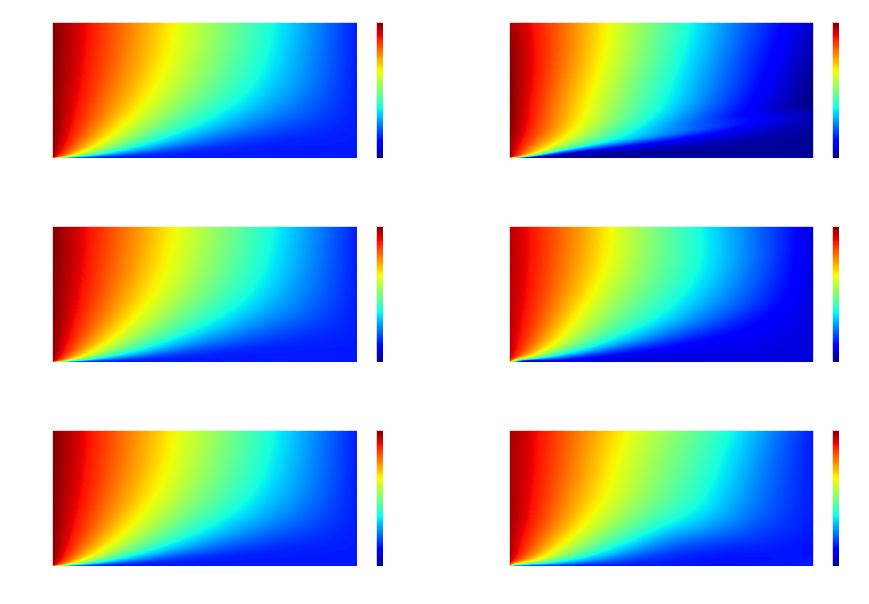

In [172]:
plot_all_subplots(np.array(psol_norm).reshape(1000, 1500), preds, n_resample)

In [173]:
XT_norm = scaler.fit_transform(data[['X', 'T']])
X = XT_norm[:, 0].reshape(1000, 1500)
psol_norm = psol_norm[:, None].reshape(1000, 1500)

In [174]:
def plot_all_actual_vs_predicted(x, u_data, u_pred_data, time_intervals, n_resample):
    fig = plt.figure(figsize = (15, 15))
    fig.subplots_adjust(hspace = 0.75)
    gs = fig.add_gridspec(3 , len(time_intervals))

    for i, u_preds in enumerate(u_pred_data):
        u_preds = u_preds.reshape(1000, 1500)
        
        for index, time in enumerate(time_intervals):
            ax = fig.add_subplot(gs[i, index], )
            ax.plot(x, u_data[time,:], 'b-', linewidth = 2, label = 'Exact')       
            ax.plot(x, u_preds[time,:], 'r--', linewidth = 2, label = 'Prediction')

            ax.set_xlabel('$x$')
            ax.set_ylabel('$u(t,x)$')    
            ax.set_title(f'$t = 0.{time}$ @ N={n_resample[i]}', fontsize = 10, color = 'white')
            ax.axis('square')
    #         ax.set_xlim([-1.1, 1.1])
    #         ax.set_ylim([-1.1, 1.1])
    legend = ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.35), ncol=5, frameon=False)
    plt.setp(legend.get_texts(), color='w')
    plt.savefig('./images/part_3_actualvspredicted', dpi = 1200, transparent = True)

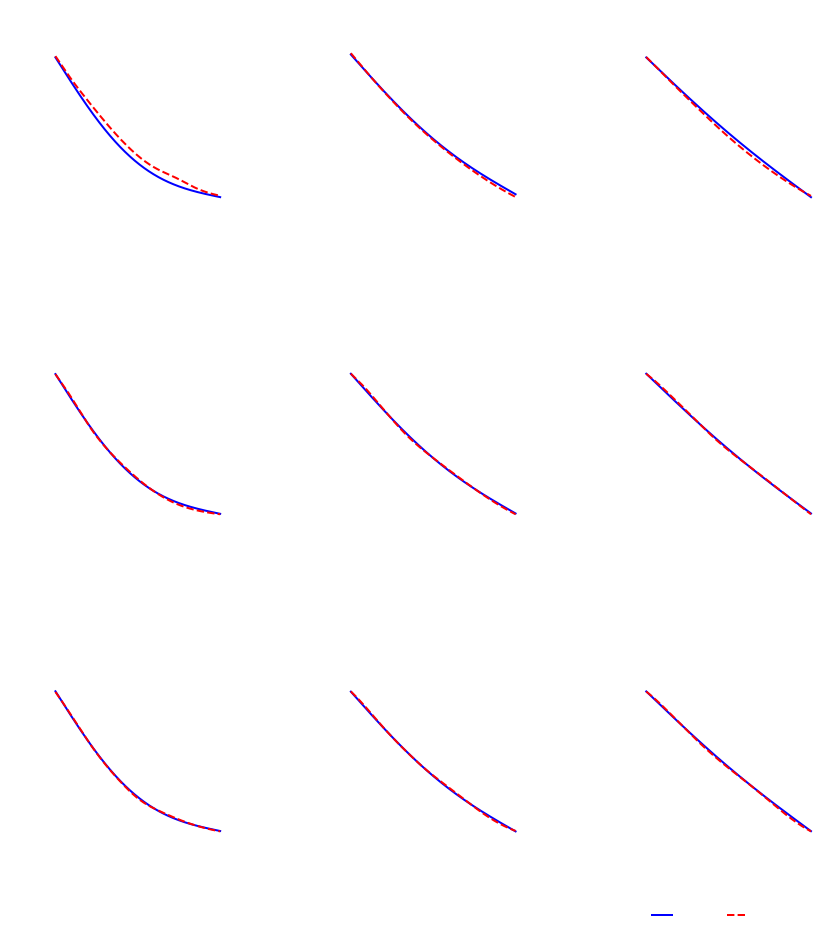

In [175]:
plot_all_actual_vs_predicted(X[0, :], psol_norm, preds, [250, 500, 750], n_resample)

In [1031]:
def plot_actual_vs_predicted(x, u_data, u_preds, time_intervals):
    
    fig = plt.figure(figsize = (15, 15))
    fig.subplots_adjust(hspace = 0.75)
    gs = fig.add_gridspec(1 , len(time_intervals))

    
    for index, time in enumerate(time_intervals):
        ax = fig.add_subplot(gs[:, index], )
        ax.plot(x, u_data[time,:], 'b-', linewidth = 2, label = 'Exact')       
        ax.plot(x, u_preds[time,:], 'r--', linewidth = 2, label = 'Prediction')
        
        ax.set_xlabel('$x$')
        ax.set_ylabel('$u(t,x)$')    
        ax.set_title(f'$t = 0.{time}$', fontsize = 10)
        ax.axis('square')
#         ax.set_xlim([-1.1, 1.1])
#         ax.set_ylim([-1.1, 1.1])
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.35), ncol=5, frameon=False)


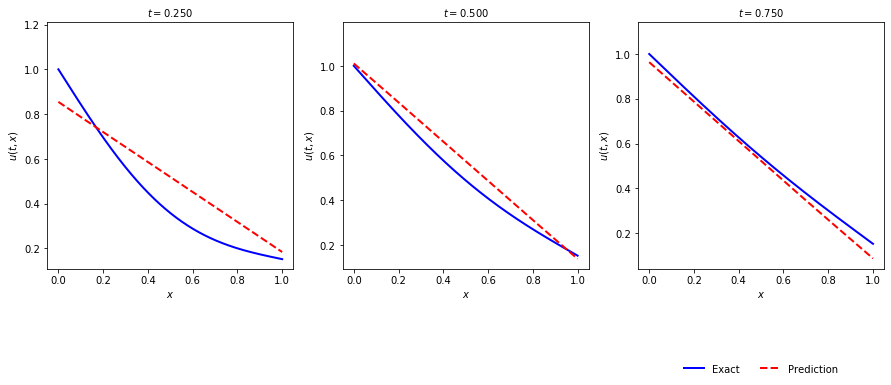

In [1032]:
plot_actual_vs_predicted(X[0, :], psol_norm, u_pred, [250, 500, 750])

# 1D Diffusivity (Homogeneous) - Part IV

## Imports

In [147]:
# Tensorflow
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Dense
from keras.models import Model
from keras import optimizers

# Scientific Libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.interpolate import BSpline
import pandas as pd
from sklearn import preprocessing 
from sklearn.metrics import mean_squared_error
from sklearn.utils import resample

# Graphing Libraries
import matplotlib.gridspec as gridspec
from scipy.interpolate import griddata
from mpl_toolkits import mplot3d
from mpl_toolkits.axes_grid1 import make_axes_locatable

# For Train - Validation - Test
from sklearn.model_selection import train_test_split

# For collocation points
from pyDOE import lhs
print(tf.__version__)

%matplotlib inline

1.13.1


## Load Data

In [170]:
data = pd.read_csv('./data/1D_Diffusivity')

## Modules

### Reservoir

In [171]:
class Reservoir():
    def __init__(self, phi, mu, c_t, k, L, P_L, P_R):
        self.phi, self.mu, self.c_t, self.k, self.L = phi, mu, c_t, k, L
        self.P_L, self.P_R = P_L, P_R
        self.diff_constant = k / (phi * mu * c_t)
        self.nu = 1/self.diff_constant
    
    def convert_to_SI(self):
        k = self.k / (1.01 * 10**15)
        c_t = self.c_t / 6897
        mu = self.mu / 1000
        self.diff_constant = k / (phi * mu * c_t) *(3.28)**2
        self.nu = 1/self.diff_constant
        return self.diff_constant
    
    def set_num_terms_for_fourier(self, num_terms = 50):
        self.num_terms = num_terms
        print(f'Setting number of expansion terms to: {num_terms}')
    
    def pressure_profile(self, x, t):    
        fourierSum = 0  
        for n in range(1, self.num_terms):
            exp_term = (n**2 * np.pi**2 * self.diff_constant * t) / self.L**2
            series_term = 1/n * np.exp(-exp_term) * np.sin(n * np.pi * x / self.L)
            fourierSum += series_term
                
        total = (x / self.L) + (2 / np.pi) * fourierSum
        result = self.P_L + (self.P_R - self.P_L)* total
        return result
    
    def plot_pressure_profile(self, num_time_steps, num_x, num_t): 
        X = np.linspace(0, self.L, num_x)

        plt.figure(figsize= (10, 10))
        plt.title("Pressure Profile w.r.t X")
        plt.xlabel('X')
        plt.ylabel('P')
        plt.ylim([1800, 5200])
        for t in range(1, num_time_steps, 79):
            T = np.linspace(t, t, num_t)
            p = self.pressure_profile(X, T)
            sns.lineplot(X, p, dashes=True, label = f't = {t}')

        plt.legend()
        plt.text(500, 3500, "Steady State")
        plt.text(50, 3000, "Transient State")
        plt.plot([0, self.L], [self.P_L, self.P_L], '--', c = 'k', linewidth=2.0)
        plt.plot([0, self.L], [self.P_R, self.P_R], '--', c = 'r', linewidth=2.0)
    
    def summary(self):
        print('GEOPHYSICAL PROPERTIES:')
        print('---------------------')
        print(f'  Porosity: {self.phi}')
        print(f'  Permeability: {self.k}')
        print(f'  Viscosity: {self.mu}')
        print(f'  Compressibility: {self.c_t}')
        
        print('\n')
        
        print('RESERVOIR PROPERTIES:')
        print('---------------------')
        print(f'  Pressure_Left: {self.P_L}')
        print(f'  Pressure_Right: {self.P_R}')
        print(f'  Length: {self.L}')
        print('\n')
        print(f'DIFFUSIVITY CONSTANT: {self.diff_constant}')
        print(f'Nu: {self.nu}')
        
        
        

### Model

#### Training

In [172]:
class TrainingDataFrame():
    
    def __init__(self, data):
        self.X, self.T, self.psol = data['X'], data['T'], data['psol']
        
        initial_time_condition = data[['X', 'T', 'psol']][self.T == 0.0]
        at_start_position = data[['X', 'T', 'psol']][self.X == 0.0]
        at_end_position = data[['X', 'T', 'psol']][self.X == self.X.max()]
        
        self.df_train = pd.concat([initial_time_condition, at_start_position, at_end_position])
        self.XT_train, self.p_train = self.df_train[['X', 'T']], self.df_train['psol']
    
    def stratify_sample(self, num_samples, num_factors = 2):
        '''
            Variables are sampled using a even sampling method, 
            and then randomly combined sets of those variables 
            are used for one calculation of the target function.   
        '''
        lower_bound = self.XT_train.min(0)
        upper_bound = self.XT_train.max(0)
        bound_range = upper_bound - lower_bound

        self.X_f = lower_bound + bound_range * lhs(num_factors, num_samples)
        self.X_f_train = np.vstack((self.X_f, np.array(self.XT_train)))
        return self.X_f, self.X_f_train 
    
    def sample_training_data(self, data, num_samples):
        random_idx = np.random.choice(data.shape[0], num_samples, replace = False) 
        return data.iloc[random_idx, :]
    
    def normalize(self, data):
        scaler = preprocessing.MinMaxScaler()
        normalized = scaler.fit_transform(data)
        return normalized, scaler
    
    def resample_from_dataset(self, data, train, n_samples):
        true_solution_sample = resample(data, n_samples = n_samples)
        new_train_data = pd.concat((train, true_solution_sample), axis=0, 
                           ignore_index = True, sort = False)
        return new_train_data

#### Physics Informed Neural Net

In [187]:
class PhysicsInformedNN():
    def __init__(self, X_u, u, layers, num_iter, lower_bound, upper_bound):
        
        self.loss_history = []  
        self.num_iter, self.layers = num_iter, layers
        self.u = u
        self.lower_bound, self.upper_bound = lower_bound, upper_bound
        self.x_u, self.t_u = X_u.iloc[:, 0:1], X_u.iloc[:, 1:2]
#         self.x_f, self.t_f = X_f[:, 0][:, None], X_f[:, 1][:, None]
        
        self.weights, self.biases = self.initial_nn(layers)
         
        # Initialize parameters
        random_init_weights = np.random.randn(2)
#         print(random_init_weights)
        self.lambda1 = tf.Variable(random_init_weights[0], dtype = tf.float32)
        self.lambda2 = tf.Variable(random_init_weights[1], dtype = tf.float32)
        
        self.x_u_tf, self.t_u_tf, self.u_tf = self.generate_placeholders()
        
        self.u_pred, self.f_pred = self.generate_predictions()
        
        self.loss = self.calc_loss()
        
       
        config = tf.ConfigProto(allow_soft_placement = True, 
                                log_device_placement = True)
        options = {
            'maxiter': num_iter,
            'maxfun':  num_iter,
            'maxcor': 50, 
            'maxls': 50,
            'ftol' : 1.0 * np.finfo(float).eps
        }
        
        self.sess = tf.Session(config = config)
        
        # For DiffEq
        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss, 
                                                                method = 'L-BFGS-B',
                                                                options = options)
        # For Adam
        self.optimizer_Adam = tf.train.AdamOptimizer()
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)
                                                                
        self.sess.run(tf.global_variables_initializer())
        
        
    def train(self, num_iterations, adam = False, both = False):
        tf_dict = {
            self.x_u_tf: self.x_u, 
            self.t_u_tf: self.t_u, 
            self.u_tf: self.u, 
#             self.x_f_tf: self.x_f, 
#             self.t_f_tf: self.t_f
        }
        
        if adam == True:
            start_time = time.time()
            for i in range(num_iterations):
                self.sess.run(self.train_op_Adam, tf_dict)
                self.print_stats(i, start_time, tf_dict)
        
        if both == True:
            start_time = time.time()
            self.optimizer.minimize(self.sess,
                                feed_dict = tf_dict,
                                fetches = [self.loss, self.lambda1, self.lambda2], 
                                loss_callback = self.callback)
    
    def print_stats(self, i, start_time, tf_dict):
        if i % 10 == 0:
            elapsed = time.time() - start_time
            loss_value = self.sess.run(self.loss, tf_dict)
            lambda1_value = np.exp(self.sess.run(self.lambda1))
            lambda2_value = self.sess.run(self.lambda2)
            print('It: %d, Loss: %.3e, Lambda_1: %.3f, Lambda_2: %.6f, Time: %.2f' % 
                  (i, loss_value, lambda1_value, lambda2_value, elapsed))
            start_time = time.time()
    
    def predict(self, X_data):
        predict_dict = {
            self.x_u_tf: X_data.iloc[:,0][:, None], 
            self.t_u_tf: X_data.iloc[:,1][:, None]
        }
        
        u_predictions = self.sess.run(self.u_pred, feed_dict = predict_dict)  
#         f_predictions = self.sess.run(self.f_pred, feed_dict = predict_dict)
        return u_predictions

    def callback(self, loss, lambda1, lambda2):
        print('Loss: %e, l1: %.5f, l2: %.5f' % (loss, np.exp(lambda1), lambda2))
        self.loss_history.append(loss)
    
        
    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1
        
        h = 2.0*(X - self.lower_bound)/(self.upper_bound - self.lower_bound) - 1.0
        for l in range(0,num_layers - 2):
            W = weights[l]
            b = biases[l]
            h = tf.tanh(tf.add(tf.matmul(h, W), b))   
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(h, W), b)
        return Y
    
    def net_u(self, x, t):
        u = self.neural_net(tf.concat([x,t], 1, name='00_concat_op'), self.weights, self.biases)
        return u
            
    def net_f(self, x, t):
#         nu = 0.01 / np.pi
        lambda1 = tf.exp(self.lambda1)
        lambda2 = self.lambda2
        u = self.net_u(x, t)
        u_t = tf.gradients(u, t)[0]
        u_x = tf.gradients(u, x)[0]
        u_xx = tf.gradients(u_x, x)[0]
        f = (lambda1 * u_xx) - (lambda2 * u_t)
        return f
    
    def calc_loss(self):
        u_loss = tf.reduce_mean(tf.square(self.u_tf - self.u_pred)) 
        f_loss = tf.reduce_mean(tf.square(self.f_pred))
        return u_loss + f_loss
               
    def generate_predictions(self):
        u_pred = self.net_u(self.x_u_tf, self.t_u_tf) 
        f_pred = self.net_f(self.x_u_tf, self.t_u_tf)
        return u_pred, f_pred
        
    def generate_placeholders(self):
        x_u_tf = tf.placeholder(tf.float32)
        t_u_tf = tf.placeholder(tf.float32)        
        
        u_tf = tf.placeholder(tf.float32)
        
#         x_f_tf = tf.placeholder(tf.float32)
#         t_f_tf = tf.placeholder(tf.float32)
        
        return x_u_tf, t_u_tf, u_tf
        
    def init_weights(self, shape):
        initializer = tf.contrib.layers.xavier_initializer()
        W = tf.get_variable('W', shape, initializer)
        
#         input_size, output_size = shape[0], shape[1]
#         std = np.sqrt(2/(input_size + output_size))
#         init_random_dist = tf.truncated_normal(shape, stddev = std)
#         return tf.Variable(init_random_dist, dtype = tf.float32)
        return W

    def init_bias(self, shape):
        init_bias_vals = tf.constant(0.1, shape = shape)
        return tf.Variable(init_bias_vals)

    def initial_nn(self, layers):
        weights = []
        biases = []

        for index in range(len(layers)-1):
            shape = (layers[index], layers[index + 1])
            W = init_weights(shape)
            b = init_bias((1, layers[index + 1]))
            weights.append(W)
            biases.append(b)       
        return weights, biases
    
    @classmethod
    def evaluate(self, preds, solutions):
        MSE = mean_squared_error(preds, solutions)
        print(f'Mean Squared Error: {MSE}')
        return MSE
    
    def evaluate_lambdas(self, lambda1, lambda2, expected_l1, expected_l2):
        root_sq_l1 = (np.exp(lambda1) - expected_l1)**2
        root_sq_l2 = (lambda2 - expected_l2)**2
        print(f'Expected / Predicted Lambda1: {expected_l1} / {np.exp(lambda1)}')
        print(f'Root Square Error: {root_sq_l1 * 100}% \n')
        print('------------------------------------------------')
        print(f'Expected / Predicted Lambda2: {expected_l2} / {lambda2}')
        print(f'Root Square Error: {root_sq_l2 * 100}%')
        return root_sq_l1, root_sq_l2

In [212]:
class Visualization():
    
    def __init__(self, x, u_data, u_preds, time_intervals):
        self.x, self.u_data, self.u_preds = x, u_data, u_preds
        self.time_intervals = time_intervals
    
    def plot_actual_vs_predicted(self):
        fig = plt.figure(figsize = (15, 15))
        fig.subplots_adjust(hspace = 0.75)
        gs = fig.add_gridspec(1 , len(self.time_intervals))

        for index, time in enumerate(self.time_intervals):
            ax = fig.add_subplot(gs[:, index], )
            ax.plot(self.x, self.u_data[time,:], 'b-', linewidth = 2, label = 'Exact')       
            ax.plot(self.x, self.u_preds[time,:], 'r--', linewidth = 2, label = 'Prediction')
        
            ax.set_xlabel('$x$')
            ax.set_ylabel('$u(t,x)$')    
            ax.set_title(f'$t = 0.{time}$', fontsize = 10)
            ax.axis('square')
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.35), ncol=5, frameon=False)
        
    def plot_all_actual_vs_predicted(self, u_pred_list, n_resample, filename):
        fig = plt.figure(figsize = (15, 15))
        fig.subplots_adjust(hspace = 0.75)
        gs = fig.add_gridspec(len(u_pred_list) , len(self.time_intervals))

        for i, preds in enumerate(u_pred_list):
            preds = preds.reshape(1000, -1)
            for index, time in enumerate(self.time_intervals):
                ax = fig.add_subplot(gs[i, index], )
                ax.plot(self.x, self.u_data[time,:], 'b-', linewidth = 2, label = 'Exact')       
                ax.plot(self.x, preds[time,:], 'r--', linewidth = 2, label = 'Prediction')

                ax.set_xlabel('$x$')
                ax.set_ylabel('$u(t,x)$')    
                ax.set_title(f'$t = 0.{time}$ @ N={n_resample[i]}', fontsize = 10)
                ax.axis('square')
                ax.set_xlim([0, 1.0])
                ax.set_ylim([0, 1.0])
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.35), ncol=5, frameon=False)
        plt.savefig(f'./images/part_4_{filename}', dpi = 1200, transparent = True)
    
    def plot_all_subplots(self, u_pred_list, n_resample, filename):
        extent = [0, 1, -1, 1]

        fig = plt.figure(figsize = (15, 10))
        fig.subplots_adjust(hspace = 0.5)
        gs = fig.add_gridspec(len(u_pred_list), 2)

        for i in range(len(u_pred_list)):

            ax1 = fig.add_subplot(gs[i, 0])
            ax1.set_title(f'Actual Data')
            ax1.set_xlabel('time')
            ax1.set_ylabel('x')
            h = ax1.imshow(self.u_data, 
                   interpolation ='gaussian', cmap ='jet', 
                   extent = extent, 
                   origin ='lower', aspect ='auto')
            plt.colorbar(h);

            u_pred = u_pred_list[i].reshape(1000, -1)
            ax2 = fig.add_subplot(gs[i, 1])
            ax2.set_title(f'Predicted Data - Resample size n: {n_resample[i]}')
            ax2.set_xlabel('time')
            ax2.set_ylabel('x')
            h = ax2.imshow(u_pred, interpolation='gaussian', cmap='jet', 
                       extent = extent, 
                       origin='lower', aspect='auto')
            plt.colorbar(h);
            plt.savefig(f'./images/part_4_{filename}', dpi = 1200, transparent = True)

    def plot_subplots(self):
        extent = [0, 1, -1, 1]

        fig = plt.figure(figsize = (10, 10))
        fig.subplots_adjust(hspace = 0.5)
        gs = fig.add_gridspec(2, 1)

        ax1 = fig.add_subplot(gs[0, :], )
        ax1.set_title('Actual Data')
        ax1.set_xlabel('time')
        ax1.set_ylabel('x')
        h = ax1.imshow(self.u_data, 
                       interpolation ='gaussian', cmap ='jet', 
                       extent = extent, 
                       origin ='lower', aspect ='auto')
        plt.colorbar(h);


        ax2 = fig.add_subplot(gs[1, :])
        ax2.set_title('Predicted Data')
        ax2.set_xlabel('time')
        ax2.set_ylabel('x')
        h = ax2.imshow(self.u_preds, interpolation='gaussian', cmap='jet', 
                       extent = extent, 
                       origin='lower', aspect='auto')
        plt.colorbar(h);

## Implementation

### Reservoir

In [188]:
reservoir = Reservoir(0.2, 0.4, 3e-6, 2000, 1000, 5000, 2000)
reservoir.convert_to_SI()
reservoir.summary()

GEOPHYSICAL PROPERTIES:
---------------------
  Porosity: 0.2
  Permeability: 2000
  Viscosity: 0.4
  Compressibility: 3e-06


RESERVOIR PROPERTIES:
---------------------
  Pressure_Left: 5000
  Pressure_Right: 2000
  Length: 1000


DIFFUSIVITY CONSTANT: 612.2168712871286
Nu: 0.0016334081056890734


### Training Data

In [189]:
train = TrainingDataFrame(data)

In [190]:
sample_data = train.sample_training_data(data, 1000)
XT_norm, scaler = train.normalize(sample_data[['X', 'T']])
p_norm,_ = train.normalize(p_train[:, None])

### Model

In [191]:
LAYERS = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]

In [192]:
model = PhysicsInformedNN(pd.DataFrame(XT_norm), p_norm, 
                          layers = LAYERS, 
                          num_iter = 1000, 
                          lower_bound = XT_norm.min(0), 
                          upper_bound = XT_norm.max(0))

In [193]:
model.train(1000, adam = True, both = True)

It: 0, Loss: 2.460e-01, Lambda_1: 0.294, Lambda_2: -2.177407, Time: 4.32
It: 10, Loss: 1.871e-01, Lambda_1: 0.294, Lambda_2: -2.173155, Time: 7.34
It: 20, Loss: 1.534e-01, Lambda_1: 0.294, Lambda_2: -2.163764, Time: 7.71
It: 30, Loss: 1.504e-01, Lambda_1: 0.297, Lambda_2: -2.151867, Time: 8.08
It: 40, Loss: 1.489e-01, Lambda_1: 0.300, Lambda_2: -2.141211, Time: 8.43
It: 50, Loss: 1.487e-01, Lambda_1: 0.302, Lambda_2: -2.136502, Time: 8.79
It: 60, Loss: 1.485e-01, Lambda_1: 0.302, Lambda_2: -2.134578, Time: 9.13
It: 70, Loss: 1.484e-01, Lambda_1: 0.302, Lambda_2: -2.133574, Time: 9.50
It: 80, Loss: 1.484e-01, Lambda_1: 0.302, Lambda_2: -2.132769, Time: 9.86
It: 90, Loss: 1.484e-01, Lambda_1: 0.301, Lambda_2: -2.132063, Time: 10.23
It: 100, Loss: 1.484e-01, Lambda_1: 0.300, Lambda_2: -2.131468, Time: 10.60
It: 110, Loss: 1.484e-01, Lambda_1: 0.300, Lambda_2: -2.130943, Time: 11.00
It: 120, Loss: 1.484e-01, Lambda_1: 0.299, Lambda_2: -2.130466, Time: 11.38
It: 130, Loss: 1.484e-01, Lambda

Loss: 1.480083e-01, l1: 0.04146, l2: -2.74072
Loss: 1.480024e-01, l1: 0.04081, l2: -2.74200
Loss: 1.480002e-01, l1: 0.04053, l2: -2.74249
Loss: 1.479948e-01, l1: 0.04031, l2: -2.74298
Loss: 1.479914e-01, l1: 0.04004, l2: -2.74355
Loss: 1.479853e-01, l1: 0.03920, l2: -2.74535
Loss: 1.479788e-01, l1: 0.03855, l2: -2.74677
Loss: 1.479769e-01, l1: 0.03692, l2: -2.75035
Loss: 1.479730e-01, l1: 0.03794, l2: -2.74809
Loss: 1.479715e-01, l1: 0.03651, l2: -2.75124
Loss: 1.479669e-01, l1: 0.03730, l2: -2.74949
Loss: 1.479650e-01, l1: 0.03712, l2: -2.74985
Loss: 1.479637e-01, l1: 0.03679, l2: -2.75061
Loss: 1.479624e-01, l1: 0.03673, l2: -2.75075
Loss: 1.479609e-01, l1: 0.03653, l2: -2.75112
Loss: 1.479598e-01, l1: 0.03668, l2: -2.75079
Loss: 1.479593e-01, l1: 0.03676, l2: -2.75060
Loss: 1.479579e-01, l1: 0.03691, l2: -2.75021
Loss: 1.479553e-01, l1: 0.03706, l2: -2.74978
Loss: 1.479531e-01, l1: 0.03706, l2: -2.74969
Loss: 1.479512e-01, l1: 0.03686, l2: -2.75007
Loss: 1.479500e-01, l1: 0.03675, l

### Predictions

In [194]:
X_data = scaler.fit_transform(data[['X', 'T']])
p_data = scaler.fit_transform(data['psol'][:, None])

In [195]:
preds = model.predict(pd.DataFrame(X_data));

### Evaluate

In [196]:
model.evaluate(preds, p_data)

Mean Squared Error: 0.0730077697067103


0.0730077697067103

In [197]:
model.evaluate_lambdas(model.sess.run(model.lambda1), model.sess.run(model.lambda2), 1.0, reservoir.nu)

Expected / Predicted Lambda1: 1.0 / 0.02824764885008335
Root Square Error: 94.43026319653909% 

------------------------------------------------
Expected / Predicted Lambda2: 0.0016334081056890734 / -2.7725911140441895
Root Square Error: 769.6321699297723%


(0.9443026319653909, 7.696321699297723)

In [198]:
x = X_data[:, 0].reshape(1000, 1500)[0, :]
vis = Visualization(x, p_data.reshape(1000, 1500), preds.reshape(1000, 1500), [250, 500, 750])

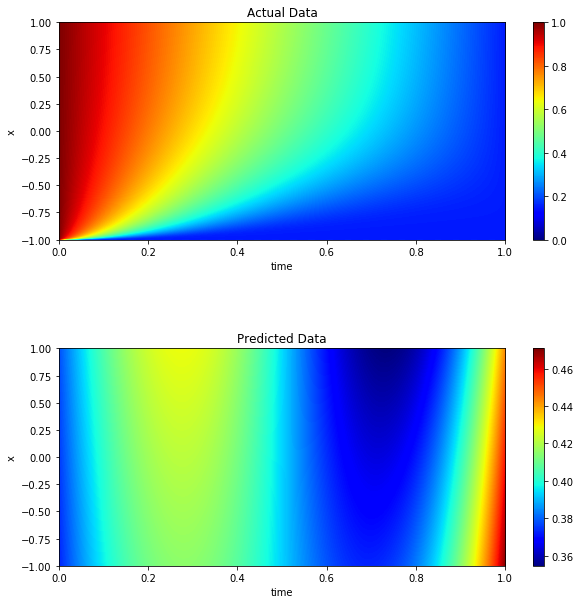

In [199]:
vis.plot_subplots()

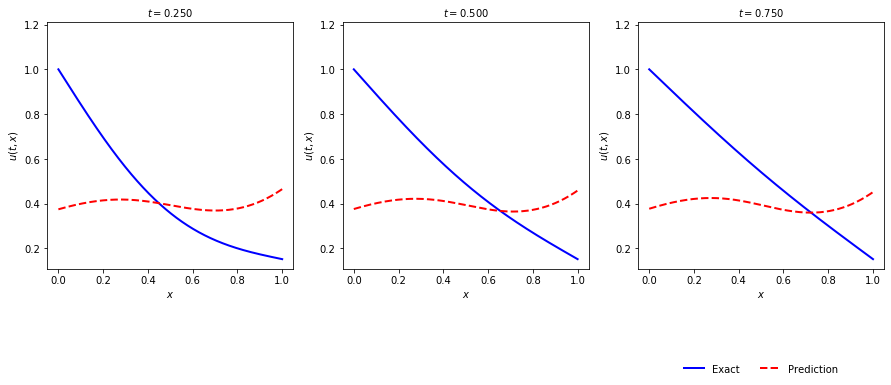

In [200]:
vis.plot_actual_vs_predicted()

### Resample From Solution

In [201]:
LAYERS = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]

In [202]:
train_obj = TrainingDataFrame(data)

In [203]:
def run_resample(num_iter, train_obj, data, num_resample, num_sample):
    sample_data = train_obj.sample_training_data(data, num_sample)
    new_training_data = train_obj.resample_from_dataset(data, sample_data, num_resample)
    XT_train, p_train = new_training_data[['X', 'T']], new_training_data['psol']

    XT_norm, scaler = train_obj.normalize(XT_train)
    p_norm,_ = train_obj.normalize(p_train[:, None])

    

    model = PhysicsInformedNN(pd.DataFrame(XT_norm), p_norm, 
                          layers = LAYERS, 
                          num_iter = 1000, 
                          lower_bound = XT_norm.min(0), 
                          upper_bound = XT_norm.max(0))

    model.train(num_iter, adam = True, both = True)

    X_data = scaler.fit_transform(data[['X', 'T']])
    p_data = scaler.fit_transform(data['psol'][:, None])

    preds = model.predict(pd.DataFrame(X_data));
    
    lambda1, lambda2 = model.sess.run(model.lambda1), model.sess.run(model.lambda2)
    return preds, [lambda1, lambda2]

In [204]:
pred_list = []
lambdas_list = []
for n in [500, 1000, 2000]:
    preds, lambdas = run_resample(100, train_obj, data, n, 100)
    pred_list.append(preds)
    lambdas_list.append(lambdas)

It: 0, Loss: 1.495e-01, Lambda_1: 0.976, Lambda_2: 0.689958, Time: 3.87
It: 10, Loss: 1.108e-01, Lambda_1: 0.976, Lambda_2: 0.689449, Time: 6.87
It: 20, Loss: 8.875e-02, Lambda_1: 0.975, Lambda_2: 0.686968, Time: 7.14
It: 30, Loss: 8.723e-02, Lambda_1: 0.968, Lambda_2: 0.677585, Time: 7.40
It: 40, Loss: 8.501e-02, Lambda_1: 0.956, Lambda_2: 0.664513, Time: 7.67
It: 50, Loss: 8.203e-02, Lambda_1: 0.942, Lambda_2: 0.649330, Time: 7.93
It: 60, Loss: 7.572e-02, Lambda_1: 0.928, Lambda_2: 0.634189, Time: 8.19
It: 70, Loss: 6.774e-02, Lambda_1: 0.913, Lambda_2: 0.617338, Time: 8.46
It: 80, Loss: 5.569e-02, Lambda_1: 0.897, Lambda_2: 0.603408, Time: 8.72
It: 90, Loss: 4.331e-02, Lambda_1: 0.882, Lambda_2: 0.588000, Time: 9.00
Loss: 3.411534e-02, l1: 0.86874, l2: 0.57404
Loss: 8.658101e+00, l1: 0.77164, l2: 0.53543
Loss: 3.342054e-02, l1: 0.86786, l2: 0.57371
Loss: 3.248934e-02, l1: 0.86555, l2: 0.57261
Loss: 2.968736e-02, l1: 0.85703, l2: 0.56857
Loss: 1.924587e-02, l1: 0.82500, l2: 0.55381
L

Loss: 4.497003e-03, l1: 0.22449, l2: 0.71942
Loss: 4.479317e-03, l1: 0.22969, l2: 0.70690
Loss: 4.472841e-03, l1: 0.23624, l2: 0.69098
Loss: 4.458692e-03, l1: 0.23544, l2: 0.69386
Loss: 4.455356e-03, l1: 0.23822, l2: 0.68822
Loss: 4.447628e-03, l1: 0.23955, l2: 0.68553
Loss: 4.440442e-03, l1: 0.24161, l2: 0.68124
Loss: 4.439351e-03, l1: 0.24420, l2: 0.67543
Loss: 4.437153e-03, l1: 0.24310, l2: 0.67787
Loss: 4.436487e-03, l1: 0.24345, l2: 0.67723
Loss: 4.435710e-03, l1: 0.24504, l2: 0.67467
Loss: 4.434981e-03, l1: 0.24516, l2: 0.67437
Loss: 4.431731e-03, l1: 0.24528, l2: 0.67466
Loss: 4.419856e-03, l1: 0.24449, l2: 0.67896
Loss: 4.406492e-03, l1: 0.24290, l2: 0.68591
Loss: 4.387591e-03, l1: 0.24253, l2: 0.69510
Loss: 4.427176e-03, l1: 0.23749, l2: 0.70908
Loss: 4.383070e-03, l1: 0.24126, l2: 0.69860
Loss: 4.368177e-03, l1: 0.24203, l2: 0.69785
Loss: 4.360292e-03, l1: 0.24180, l2: 0.70185
Loss: 4.343556e-03, l1: 0.24152, l2: 0.69991
Loss: 4.331962e-03, l1: 0.24213, l2: 0.70064
Loss: 4.35

Loss: 2.022729e-03, l1: 0.15551, l2: 0.50333
Loss: 2.020488e-03, l1: 0.15503, l2: 0.50250
Loss: 2.019684e-03, l1: 0.15504, l2: 0.50204
Loss: 2.019484e-03, l1: 0.15524, l2: 0.50180
Loss: 2.019419e-03, l1: 0.15520, l2: 0.50148
Loss: 2.019225e-03, l1: 0.15524, l2: 0.50090
Loss: 2.018949e-03, l1: 0.15527, l2: 0.49994
Loss: 2.018730e-03, l1: 0.15529, l2: 0.49939
Loss: 2.018553e-03, l1: 0.15534, l2: 0.49914
Loss: 2.018431e-03, l1: 0.15544, l2: 0.49925
Loss: 2.018280e-03, l1: 0.15557, l2: 0.49938
Loss: 2.018068e-03, l1: 0.15577, l2: 0.49955
Loss: 2.017803e-03, l1: 0.15592, l2: 0.49961
Loss: 2.017292e-03, l1: 0.15614, l2: 0.49952
Loss: 2.016334e-03, l1: 0.15632, l2: 0.49927
Loss: 2.014545e-03, l1: 0.15685, l2: 0.49882
Loss: 2.011272e-03, l1: 0.15672, l2: 0.49842
Loss: 2.006320e-03, l1: 0.15639, l2: 0.49675
Loss: 1.996934e-03, l1: 0.15596, l2: 0.49615
Loss: 1.998895e-03, l1: 0.15642, l2: 0.49376
Loss: 1.993608e-03, l1: 0.15618, l2: 0.49502
Loss: 1.991842e-03, l1: 0.15667, l2: 0.49508
Loss: 1.98

Loss: 1.827894e-03, l1: 0.14602, l2: 0.42182
Loss: 1.827877e-03, l1: 0.14597, l2: 0.42169
Loss: 1.827743e-03, l1: 0.14601, l2: 0.42151
Loss: 1.827694e-03, l1: 0.14594, l2: 0.42100
Loss: 1.827614e-03, l1: 0.14599, l2: 0.42113
Loss: 1.827500e-03, l1: 0.14595, l2: 0.42091
Loss: 1.827750e-03, l1: 0.14569, l2: 0.41982
Loss: 1.827319e-03, l1: 0.14584, l2: 0.42044
Loss: 1.827289e-03, l1: 0.14560, l2: 0.41990
Loss: 1.827195e-03, l1: 0.14574, l2: 0.42023
Loss: 1.826830e-03, l1: 0.14551, l2: 0.42013
Loss: 1.826538e-03, l1: 0.14530, l2: 0.42001
Loss: 1.825878e-03, l1: 0.14460, l2: 0.42028
Loss: 3.864482e-03, l1: 0.13945, l2: 0.41997
Loss: 1.827182e-03, l1: 0.14383, l2: 0.42024
Loss: 1.825572e-03, l1: 0.14434, l2: 0.42027
Loss: 1.825524e-03, l1: 0.14399, l2: 0.41998
Loss: 1.825462e-03, l1: 0.14417, l2: 0.42013
Loss: 1.825328e-03, l1: 0.14404, l2: 0.41978
Loss: 1.825311e-03, l1: 0.14407, l2: 0.41947
Loss: 1.825139e-03, l1: 0.14393, l2: 0.41887
Loss: 1.824957e-03, l1: 0.14385, l2: 0.41848
Loss: 1.82

Loss: 1.739573e-03, l1: 0.12520, l2: 0.35924
Loss: 1.739537e-03, l1: 0.12472, l2: 0.35905
Loss: 1.739358e-03, l1: 0.12499, l2: 0.35916
Loss: 1.739230e-03, l1: 0.12472, l2: 0.35910
Loss: 1.739175e-03, l1: 0.12471, l2: 0.35920
Loss: 1.739123e-03, l1: 0.12459, l2: 0.35897
Loss: 1.739092e-03, l1: 0.12458, l2: 0.35880
Loss: 1.738986e-03, l1: 0.12448, l2: 0.35834
Loss: 1.738857e-03, l1: 0.12443, l2: 0.35782
Loss: 1.738681e-03, l1: 0.12426, l2: 0.35706
Loss: 1.738326e-03, l1: 0.12421, l2: 0.35610
Loss: 1.738051e-03, l1: 0.12404, l2: 0.35632
Loss: 1.737884e-03, l1: 0.12432, l2: 0.35692
Loss: 1.737200e-03, l1: 0.12434, l2: 0.35524
Loss: 1.737056e-03, l1: 0.12424, l2: 0.35612
Loss: 1.736850e-03, l1: 0.12422, l2: 0.35631
Loss: 1.736823e-03, l1: 0.12426, l2: 0.35633
Loss: 1.736770e-03, l1: 0.12424, l2: 0.35632
Loss: 1.736708e-03, l1: 0.12427, l2: 0.35642
Loss: 1.736562e-03, l1: 0.12428, l2: 0.35657
Loss: 1.736421e-03, l1: 0.12429, l2: 0.35652
Loss: 1.736353e-03, l1: 0.12422, l2: 0.35629
Loss: 1.73

Loss: 1.691759e-03, l1: 0.10357, l2: 0.31178
Loss: 1.689039e-03, l1: 0.10397, l2: 0.31291
Loss: 1.688491e-03, l1: 0.10387, l2: 0.31301
Loss: 1.687364e-03, l1: 0.10310, l2: 0.31145
Loss: 1.686646e-03, l1: 0.10283, l2: 0.31065
Loss: 1.689076e-03, l1: 0.10197, l2: 0.30799
Loss: 1.686334e-03, l1: 0.10259, l2: 0.30991
Loss: 1.686338e-03, l1: 0.10228, l2: 0.30841
Loss: 1.685754e-03, l1: 0.10243, l2: 0.30913
Loss: 1.685442e-03, l1: 0.10211, l2: 0.30805
Loss: 1.685160e-03, l1: 0.10189, l2: 0.30714
Loss: 1.686493e-03, l1: 0.10133, l2: 0.30466
Loss: 1.685075e-03, l1: 0.10177, l2: 0.30661
Loss: 1.684937e-03, l1: 0.10174, l2: 0.30577
Loss: 1.684862e-03, l1: 0.10126, l2: 0.30325
Loss: 1.684760e-03, l1: 0.10149, l2: 0.30446
Loss: 1.684459e-03, l1: 0.10136, l2: 0.30397
Loss: 1.683937e-03, l1: 0.10115, l2: 0.30308
Loss: 1.697306e-03, l1: 0.10031, l2: 0.30001
Loss: 1.683502e-03, l1: 0.10098, l2: 0.30245
Loss: 1.682398e-03, l1: 0.10071, l2: 0.30222
Loss: 1.680074e-03, l1: 0.10036, l2: 0.30240
Loss: 1.67

Loss: 7.807464e-03, l1: 0.18383, l2: 1.57237
Loss: 7.791915e-03, l1: 0.18399, l2: 1.57138
Loss: 7.756243e-03, l1: 0.18508, l2: 1.57021
Loss: 7.707365e-03, l1: 0.18722, l2: 1.56827
Loss: 7.621471e-03, l1: 0.19147, l2: 1.56383
Loss: 7.507465e-03, l1: 0.19691, l2: 1.55516
Loss: 7.391921e-03, l1: 0.20274, l2: 1.54062
Loss: 7.320758e-03, l1: 0.21025, l2: 1.52767
Loss: 7.214137e-03, l1: 0.22267, l2: 1.50826
Loss: 7.371896e-03, l1: 0.24159, l2: 1.46128
Loss: 7.144072e-03, l1: 0.22985, l2: 1.48999
Loss: 7.296308e-03, l1: 0.24722, l2: 1.42898
Loss: 7.002889e-03, l1: 0.23747, l2: 1.46266
Loss: 6.923067e-03, l1: 0.23432, l2: 1.44736
Loss: 6.864382e-03, l1: 0.24161, l2: 1.42726
Loss: 6.806385e-03, l1: 0.23750, l2: 1.43851
Loss: 6.791828e-03, l1: 0.23994, l2: 1.43044
Loss: 6.772053e-03, l1: 0.23811, l2: 1.43869
Loss: 6.764406e-03, l1: 0.23852, l2: 1.43787
Loss: 6.701140e-03, l1: 0.24482, l2: 1.42390
Loss: 6.658386e-03, l1: 0.24948, l2: 1.40910
Loss: 6.533574e-03, l1: 0.27093, l2: 1.35162
Loss: 6.43

Loss: 2.408781e-03, l1: 0.15408, l2: 0.60759
Loss: 2.373884e-03, l1: 0.15698, l2: 0.62075
Loss: 2.369793e-03, l1: 0.14593, l2: 0.58173
Loss: 2.363426e-03, l1: 0.15258, l2: 0.60554
Loss: 2.518367e-03, l1: 0.13355, l2: 0.54026
Loss: 2.353058e-03, l1: 0.14767, l2: 0.58953
Loss: 2.332480e-03, l1: 0.14021, l2: 0.56489
Loss: 2.293291e-03, l1: 0.13550, l2: 0.54544
Loss: 2.275971e-03, l1: 0.12820, l2: 0.50229
Loss: 2.255633e-03, l1: 0.12477, l2: 0.48744
Loss: 2.240313e-03, l1: 0.11701, l2: 0.46382
Loss: 2.256746e-03, l1: 0.11054, l2: 0.44660
Loss: 2.232897e-03, l1: 0.11462, l2: 0.45757
Loss: 2.220256e-03, l1: 0.11239, l2: 0.44998
Loss: 2.193913e-03, l1: 0.10076, l2: 0.39974
Loss: 2.258703e-03, l1: 0.08341, l2: 0.33869
Loss: 2.178584e-03, l1: 0.09503, l2: 0.38085
Loss: 2.237917e-03, l1: 0.07782, l2: 0.29948
Loss: 2.160847e-03, l1: 0.08864, l2: 0.35247
Loss: 2.206753e-03, l1: 0.07674, l2: 0.30026
Loss: 2.136849e-03, l1: 0.08396, l2: 0.33282
Loss: 2.121063e-03, l1: 0.08181, l2: 0.32145
Loss: 2.10

Loss: 1.025255e-03, l1: 0.00052, l2: 0.00043
Loss: 9.985591e-04, l1: 0.00053, l2: -0.00012
Loss: 9.941005e-04, l1: 0.00053, l2: 0.00131
Loss: 9.885215e-04, l1: 0.00052, l2: 0.00173
Loss: 9.835418e-04, l1: 0.00050, l2: 0.00159
Loss: 9.784914e-04, l1: 0.00047, l2: 0.00128
Loss: 9.726189e-04, l1: 0.00044, l2: 0.00097
Loss: 9.703031e-04, l1: 0.00042, l2: 0.00115
Loss: 9.672731e-04, l1: 0.00041, l2: 0.00119
Loss: 9.656173e-04, l1: 0.00039, l2: 0.00088
Loss: 9.649074e-04, l1: 0.00040, l2: 0.00105
Loss: 9.641098e-04, l1: 0.00038, l2: 0.00065
Loss: 9.628999e-04, l1: 0.00039, l2: 0.00088
Loss: 9.587304e-04, l1: 0.00039, l2: 0.00053
Loss: 9.537442e-04, l1: 0.00039, l2: 0.00064
Loss: 9.537068e-04, l1: 0.00038, l2: 0.00135
Loss: 9.495927e-04, l1: 0.00038, l2: 0.00087
Loss: 9.507023e-04, l1: 0.00039, l2: 0.00229
Loss: 9.414293e-04, l1: 0.00039, l2: 0.00161
Loss: 9.332154e-04, l1: 0.00039, l2: 0.00246
Loss: 9.300390e-04, l1: 0.00039, l2: 0.00236
Loss: 9.287211e-04, l1: 0.00039, l2: 0.00241
Loss: 9.2

Loss: 5.523174e-04, l1: 0.00009, l2: -0.00084
Loss: 6.068463e-04, l1: 0.00011, l2: -0.00096
Loss: 5.503949e-04, l1: 0.00009, l2: -0.00087
Loss: 5.478871e-04, l1: 0.00011, l2: -0.00026
Loss: 5.423510e-04, l1: 0.00010, l2: 0.00032
Loss: 5.404804e-04, l1: 0.00010, l2: 0.00040
Loss: 5.357668e-04, l1: 0.00011, l2: 0.00033
Loss: 5.309443e-04, l1: 0.00012, l2: 0.00019
Loss: 5.310158e-04, l1: 0.00012, l2: -0.00001
Loss: 5.284115e-04, l1: 0.00012, l2: 0.00009
Loss: 5.263856e-04, l1: 0.00012, l2: 0.00026
Loss: 5.253791e-04, l1: 0.00012, l2: 0.00015
Loss: 5.813534e-04, l1: 0.00012, l2: 0.00048
Loss: 5.233157e-04, l1: 0.00012, l2: 0.00022
Loss: 5.207140e-04, l1: 0.00011, l2: 0.00048
Loss: 5.183136e-04, l1: 0.00011, l2: 0.00065
Loss: 5.155194e-04, l1: 0.00011, l2: 0.00036
Loss: 5.128380e-04, l1: 0.00011, l2: 0.00003
Loss: 5.103002e-04, l1: 0.00011, l2: 0.00003
Loss: 5.097481e-04, l1: 0.00011, l2: 0.00017
Loss: 5.089050e-04, l1: 0.00011, l2: 0.00009
Loss: 5.055868e-04, l1: 0.00011, l2: 0.00011
Loss:

Loss: 2.551646e-04, l1: 0.00005, l2: 0.00014
Loss: 2.550249e-04, l1: 0.00005, l2: 0.00019
Loss: 2.547456e-04, l1: 0.00004, l2: 0.00032
Loss: 2.544757e-04, l1: 0.00004, l2: 0.00029
Loss: 2.542342e-04, l1: 0.00004, l2: 0.00022
Loss: 2.541220e-04, l1: 0.00004, l2: 0.00014
Loss: 2.557457e-04, l1: 0.00004, l2: 0.00010
Loss: 2.538178e-04, l1: 0.00004, l2: 0.00013
Loss: 2.537355e-04, l1: 0.00004, l2: 0.00018
Loss: 2.536556e-04, l1: 0.00004, l2: 0.00015
Loss: 2.535381e-04, l1: 0.00004, l2: 0.00026
Loss: 2.534475e-04, l1: 0.00004, l2: 0.00025
Loss: 2.533700e-04, l1: 0.00004, l2: 0.00022
Loss: 2.532489e-04, l1: 0.00004, l2: 0.00019
Loss: 2.530556e-04, l1: 0.00004, l2: 0.00011
Loss: 2.548489e-04, l1: 0.00004, l2: -0.00082
Loss: 2.530238e-04, l1: 0.00004, l2: 0.00000
Loss: 2.528523e-04, l1: 0.00004, l2: 0.00001
Loss: 2.536867e-04, l1: 0.00004, l2: -0.00004
Loss: 2.527625e-04, l1: 0.00004, l2: -0.00000
Loss: 2.524926e-04, l1: 0.00004, l2: 0.00008
Loss: 2.521574e-04, l1: 0.00004, l2: 0.00023
Loss: 2

Loss: 2.075114e-04, l1: 0.00001, l2: 0.00002
Loss: 2.074907e-04, l1: 0.00001, l2: 0.00001
Loss: 2.074417e-04, l1: 0.00001, l2: 0.00002
Loss: 2.073920e-04, l1: 0.00001, l2: -0.00009
Loss: 2.073809e-04, l1: 0.00001, l2: -0.00011
Loss: 2.073337e-04, l1: 0.00001, l2: -0.00010
Loss: 2.072763e-04, l1: 0.00001, l2: -0.00007
Loss: 2.071598e-04, l1: 0.00001, l2: -0.00003
Loss: 2.071127e-04, l1: 0.00001, l2: 0.00003
Loss: 2.070814e-04, l1: 0.00001, l2: -0.00000
Loss: 2.068638e-04, l1: 0.00001, l2: 0.00008
Loss: 2.067438e-04, l1: 0.00001, l2: 0.00009
Loss: 2.072223e-04, l1: 0.00001, l2: 0.00007
Loss: 2.066424e-04, l1: 0.00001, l2: 0.00008
Loss: 2.065293e-04, l1: 0.00001, l2: 0.00010
Loss: 2.064260e-04, l1: 0.00001, l2: 0.00010
Loss: 2.062828e-04, l1: 0.00001, l2: 0.00004
Loss: 2.061922e-04, l1: 0.00001, l2: 0.00002
Loss: 2.061443e-04, l1: 0.00001, l2: -0.00003
Loss: 2.061049e-04, l1: 0.00001, l2: -0.00005
Loss: 2.060152e-04, l1: 0.00000, l2: -0.00009
INFO:tensorflow:Optimization terminated with:


Loss: 5.543006e-03, l1: 5.25408, l2: 0.98177
Loss: 5.541062e-03, l1: 5.24952, l2: 0.98158
Loss: 5.539890e-03, l1: 5.24547, l2: 0.98162
Loss: 5.538366e-03, l1: 5.23558, l2: 0.98184
Loss: 5.537666e-03, l1: 5.23232, l2: 0.98192
Loss: 5.536556e-03, l1: 5.22659, l2: 0.98195
Loss: 5.536004e-03, l1: 5.22542, l2: 0.98194
Loss: 5.532977e-03, l1: 5.22050, l2: 0.98174
Loss: 5.527364e-03, l1: 5.21298, l2: 0.98135
Loss: 5.511295e-03, l1: 5.19534, l2: 0.98022
Loss: 5.483700e-03, l1: 5.16401, l2: 0.97822
Loss: 5.455622e-03, l1: 5.15176, l2: 0.97766
Loss: 5.451181e-03, l1: 5.14563, l2: 0.97665
Loss: 5.433629e-03, l1: 5.14865, l2: 0.97715
Loss: 5.813646e-03, l1: 5.10757, l2: 0.97234
Loss: 5.417456e-03, l1: 5.14129, l2: 0.97629
Loss: 5.417246e-03, l1: 5.13483, l2: 0.97683
Loss: 5.410617e-03, l1: 5.13804, l2: 0.97656
Loss: 5.397143e-03, l1: 5.13018, l2: 0.97614
Loss: 5.382141e-03, l1: 5.13954, l2: 0.97537
Loss: 5.372691e-03, l1: 5.10823, l2: 0.97537
Loss: 5.362307e-03, l1: 5.11986, l2: 0.97601
Loss: 5.34

Loss: 4.943434e-03, l1: 4.24956, l2: 1.02883
Loss: 4.940412e-03, l1: 4.22709, l2: 1.03039
Loss: 4.938922e-03, l1: 4.19244, l2: 1.03314
Loss: 4.937855e-03, l1: 4.21013, l2: 1.03173
Loss: 4.961654e-03, l1: 4.16786, l2: 1.03546
Loss: 4.935730e-03, l1: 4.20047, l2: 1.03258
Loss: 4.935709e-03, l1: 4.17647, l2: 1.03433
Loss: 4.934812e-03, l1: 4.18928, l2: 1.03339
Loss: 4.934135e-03, l1: 4.16897, l2: 1.03493
Loss: 4.932159e-03, l1: 4.16805, l2: 1.03480
Loss: 4.930069e-03, l1: 4.14825, l2: 1.03630
Loss: 4.929254e-03, l1: 4.11863, l2: 1.03871
Loss: 4.928564e-03, l1: 4.13387, l2: 1.03747
Loss: 4.926597e-03, l1: 4.11656, l2: 1.03883
Loss: 4.923576e-03, l1: 4.11091, l2: 1.03939
Loss: 4.922503e-03, l1: 4.06442, l2: 1.04282
Loss: 4.920536e-03, l1: 4.09329, l2: 1.04069
Loss: 4.915007e-03, l1: 4.05211, l2: 1.04375
Loss: 4.921929e-03, l1: 4.06905, l2: 1.04236
Loss: 4.912409e-03, l1: 4.05765, l2: 1.04330
Loss: 4.908016e-03, l1: 4.05720, l2: 1.04375
Loss: 4.905382e-03, l1: 4.04860, l2: 1.04467
Loss: 4.90

Loss: 4.707482e-03, l1: 3.76044, l2: 1.05935
Loss: 4.706716e-03, l1: 3.75882, l2: 1.05955
Loss: 4.704987e-03, l1: 3.75774, l2: 1.05992
Loss: 4.702556e-03, l1: 3.73923, l2: 1.06168
Loss: 4.884123e-03, l1: 3.72566, l2: 1.06425
Loss: 4.701505e-03, l1: 3.73753, l2: 1.06200
Loss: 4.709091e-03, l1: 3.73596, l2: 1.06328
Loss: 4.698061e-03, l1: 3.73693, l2: 1.06249
Loss: 4.690056e-03, l1: 3.72788, l2: 1.06415
Loss: 4.687495e-03, l1: 3.70635, l2: 1.06646
Loss: 4.805754e-03, l1: 3.63768, l2: 1.07405
Loss: 4.680042e-03, l1: 3.68939, l2: 1.06832
Loss: 5.026427e-03, l1: 3.62864, l2: 1.07637
Loss: 4.677052e-03, l1: 3.68127, l2: 1.06939
Loss: 4.677124e-03, l1: 3.67183, l2: 1.06986
Loss: 4.674959e-03, l1: 3.67649, l2: 1.06963
Loss: 4.678783e-03, l1: 3.67351, l2: 1.06942
Loss: 4.673154e-03, l1: 3.67541, l2: 1.06955
Loss: 4.670177e-03, l1: 3.66266, l2: 1.07069
Loss: 4.664829e-03, l1: 3.64588, l2: 1.07204
Loss: 4.674322e-03, l1: 3.64066, l2: 1.07303
Loss: 4.662203e-03, l1: 3.64413, l2: 1.07237
Loss: 4.65

Loss: 4.430414e-03, l1: 3.00265, l2: 1.14393
Loss: 4.435416e-03, l1: 2.96964, l2: 1.14804
Loss: 4.426846e-03, l1: 2.98912, l2: 1.14561
Loss: 4.423131e-03, l1: 2.97205, l2: 1.14713
Loss: 4.417813e-03, l1: 2.94163, l2: 1.15053
Loss: 4.441672e-03, l1: 2.85199, l2: 1.16087
Loss: 4.411150e-03, l1: 2.91098, l2: 1.15403
Loss: 4.411674e-03, l1: 2.85997, l2: 1.15956
Loss: 4.406171e-03, l1: 2.88474, l2: 1.15686
Loss: 4.400492e-03, l1: 2.87148, l2: 1.15814
Loss: 4.397923e-03, l1: 2.86209, l2: 1.15956
Loss: 4.397605e-03, l1: 2.84566, l2: 1.16170
Loss: 4.394452e-03, l1: 2.85405, l2: 1.16060
Loss: 4.408802e-03, l1: 2.80836, l2: 1.16631
Loss: 4.392751e-03, l1: 2.84238, l2: 1.16205
Loss: 4.391571e-03, l1: 2.83682, l2: 1.16294
Loss: 4.388420e-03, l1: 2.82152, l2: 1.16463
Loss: 4.388246e-03, l1: 2.80791, l2: 1.16642
Loss: 4.387285e-03, l1: 2.81504, l2: 1.16548
Loss: 4.386681e-03, l1: 2.80654, l2: 1.16657
Loss: 4.383207e-03, l1: 2.78517, l2: 1.16924
Loss: 4.381294e-03, l1: 2.77706, l2: 1.17030
Loss: 4.37

Loss: 4.058828e-03, l1: 2.00853, l2: 1.29614
Loss: 4.092158e-03, l1: 1.98115, l2: 1.30192
Loss: 4.053293e-03, l1: 2.00001, l2: 1.29793
Loss: 4.054496e-03, l1: 1.98849, l2: 1.30061
Loss: 4.050568e-03, l1: 1.99444, l2: 1.29922
Loss: 4.047250e-03, l1: 1.98882, l2: 1.30047
Loss: 4.047743e-03, l1: 1.98030, l2: 1.30227
Loss: 4.044965e-03, l1: 1.98462, l2: 1.30136
Loss: 4.044296e-03, l1: 1.98245, l2: 1.30168
Loss: 4.043268e-03, l1: 1.98449, l2: 1.30151
Loss: 4.041871e-03, l1: 1.98337, l2: 1.30173
Loss: 4.040117e-03, l1: 1.98007, l2: 1.30244
Loss: 4.034482e-03, l1: 1.97454, l2: 1.30385
Loss: 4.038194e-03, l1: 1.96382, l2: 1.30649
Loss: 4.032242e-03, l1: 1.97018, l2: 1.30492
Loss: 4.035039e-03, l1: 1.96412, l2: 1.30662
Loss: 4.028617e-03, l1: 1.96744, l2: 1.30569
Loss: 4.029327e-03, l1: 1.95631, l2: 1.30792
Loss: 4.025834e-03, l1: 1.96206, l2: 1.30676
Loss: 4.022152e-03, l1: 1.95669, l2: 1.30789
Loss: 4.020846e-03, l1: 1.94812, l2: 1.30964
Loss: 4.021776e-03, l1: 1.94305, l2: 1.31031
Loss: 4.01

In [168]:
predictions = np.array(pred_list).ravel()
lambdas = np.array(lambdas_list).ravel()

NameError: name 'pred_list' is not defined

In [206]:
np.savetxt('./data/preds0.txt', predictions, delimiter = '\t')
np.savetxt('./data/lambdas0.txt', lambdas, delimiter = '\t')

In [207]:
predictions = np.loadtxt('./data/preds.txt')

In [208]:
preds = predictions.reshape(4, -1)

In [209]:
x = X_data[:, 0].reshape(1000, 1500)[0, :]
vis = Visualization(x, p_data.reshape(1000, 1500), preds[0].reshape(1000, 1500), [250, 500, 750])

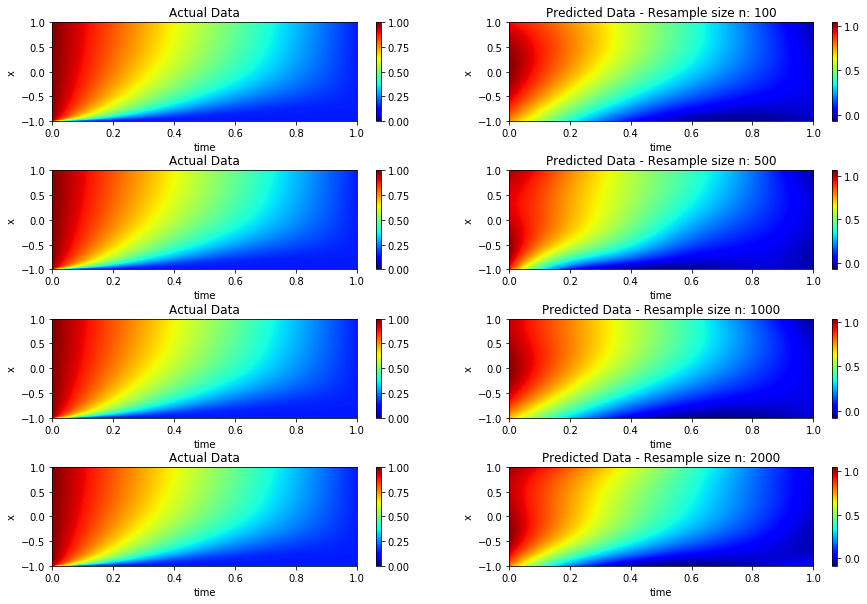

In [210]:
vis.plot_all_subplots(preds, [100, 500, 1000, 2000])

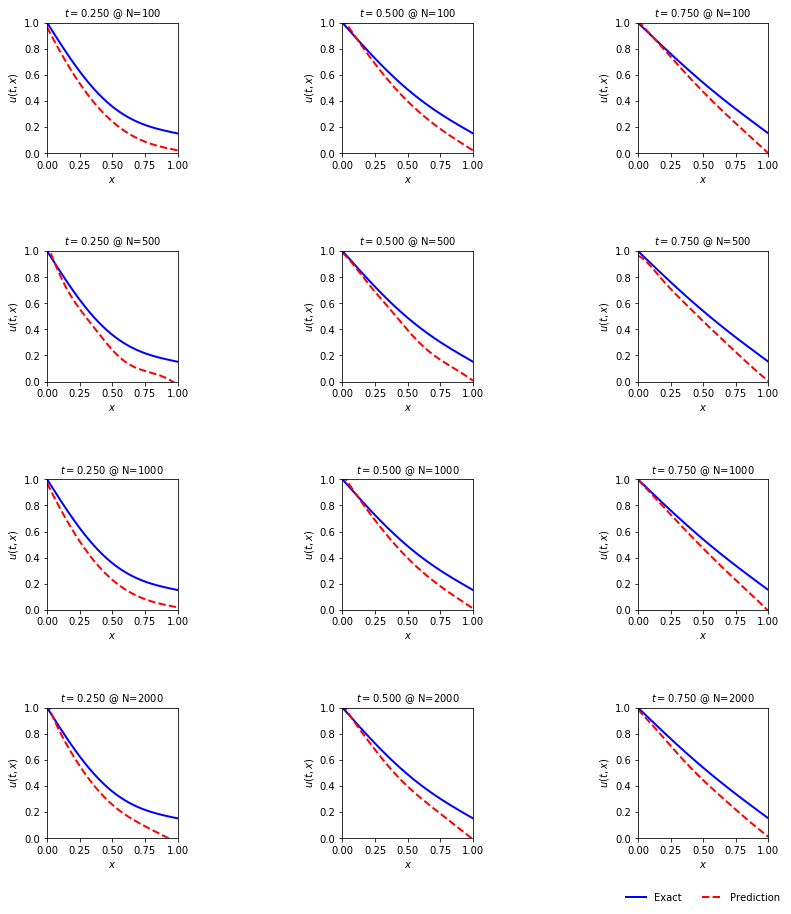

In [211]:
vis.plot_all_actual_vs_predicted(preds, [100, 500, 1000, 2000])

In [814]:
preds.shape

(4, 1500000)

In [815]:
for p in preds:
    model.evaluate(p.reshape(1000, -1), p_data.reshape(1000, -1))

Mean Squared Error: 0.01024013113363062
Mean Squared Error: 0.011152538743250203
Mean Squared Error: 0.011404557355613187
Mean Squared Error: 0.010854389696172584


In [836]:
lambdas.reshape(-1, 2)

array([[-0.68622977,  1.5798556 ],
       [-3.81557   ,  0.05815635],
       [ 0.00998648,  0.76568735],
       [-2.101534  ,  0.38610974]], dtype=float32)

In [840]:
for index, l in enumerate(lambdas.reshape(-1, 2)):
    print(f'Iteration # {index}')
    l1, l2 = l[0], l[1]
    model.evaluate_lambdas(l1, l2, 1.0, reservoir.nu)
    
    print('\n')
    print('-----------------------------------------')


Iteration # 0
Expected / Predicted Lambda1: 1.0 / 0.5034707188606262
Root Square Error: 24.65413270287833% 

------------------------------------------------
Expected / Predicted Lambda2: 0.0016334081056890734 / 1.5798555612564087
Root Square Error: 249.07851646956937%


-----------------------------------------
Iteration # 1
Expected / Predicted Lambda1: 1.0 / 0.022025154903531075
Root Square Error: 95.64347976414625% 

------------------------------------------------
Expected / Predicted Lambda2: 0.0016334081056890734 / 0.05815634876489639
Root Square Error: 0.3194842820764272%


-----------------------------------------
Iteration # 2
Expected / Predicted Lambda1: 1.0 / 1.0100364685058594
Root Square Error: 0.010073070006910712% 

------------------------------------------------
Expected / Predicted Lambda2: 0.0016334081056890734 / 0.7656873464584351
Root Square Error: 58.37784207123416%


-----------------------------------------
Iteration # 3
Expected / Predicted Lambda1: 1.0 / 0.1

### Increasing Sample Size

In [213]:
# Changing Resampling Size to Increasing Sample Size
pred_list = []
lambdas_list = []
for n in [500, 1000, 2000]:
    preds, lambdas = run_resample(100, train_obj, data, 500, n)
    pred_list.append(preds)
    lambdas_list.append(lambdas)

It: 0, Loss: 1.886e-01, Lambda_1: 4.212, Lambda_2: 1.006343, Time: 4.35
It: 10, Loss: 1.441e-01, Lambda_1: 4.211, Lambda_2: 1.005651, Time: 8.16
It: 20, Loss: 1.098e-01, Lambda_1: 4.193, Lambda_2: 1.000169, Time: 8.51
It: 30, Loss: 9.540e-02, Lambda_1: 4.153, Lambda_2: 0.989910, Time: 8.88
It: 40, Loss: 9.605e-02, Lambda_1: 4.103, Lambda_2: 0.977328, Time: 9.22
It: 50, Loss: 9.405e-02, Lambda_1: 4.042, Lambda_2: 0.962380, Time: 9.58
It: 60, Loss: 9.337e-02, Lambda_1: 3.980, Lambda_2: 0.946775, Time: 9.91
It: 70, Loss: 9.168e-02, Lambda_1: 3.913, Lambda_2: 0.929857, Time: 10.28
It: 80, Loss: 8.870e-02, Lambda_1: 3.847, Lambda_2: 0.914360, Time: 10.64
It: 90, Loss: 8.443e-02, Lambda_1: 3.774, Lambda_2: 0.902804, Time: 11.00
Loss: 7.876505e-02, l1: 3.70779, l2: 0.89023
Loss: 3.042056e+00, l1: 3.44040, l2: 0.86368
Loss: 7.732441e-02, l1: 3.70076, l2: 0.88956
Loss: 7.643126e-02, l1: 3.69110, l2: 0.88852
Loss: 7.316607e-02, l1: 3.65271, l2: 0.88435
Loss: 2.858668e+00, l1: 3.10285, l2: 0.8248

Loss: 6.649768e-03, l1: 1.20611, l2: 1.06250
Loss: 6.635999e-03, l1: 1.20650, l2: 1.06250
Loss: 6.614416e-03, l1: 1.18425, l2: 1.06792
Loss: 6.597025e-03, l1: 1.17634, l2: 1.06943
Loss: 6.572217e-03, l1: 1.16766, l2: 1.07133
Loss: 6.843116e-03, l1: 1.10848, l2: 1.08413
Loss: 6.547020e-03, l1: 1.15076, l2: 1.07492
Loss: 6.863994e-03, l1: 1.10236, l2: 1.08557
Loss: 6.513011e-03, l1: 1.13655, l2: 1.07800
Loss: 6.471186e-03, l1: 1.12522, l2: 1.08068
Loss: 6.478495e-03, l1: 1.13046, l2: 1.07981
Loss: 6.447389e-03, l1: 1.12760, l2: 1.08029
Loss: 6.430256e-03, l1: 1.12245, l2: 1.08171
Loss: 6.411954e-03, l1: 1.11537, l2: 1.08327
Loss: 6.394850e-03, l1: 1.09998, l2: 1.08724
Loss: 6.388264e-03, l1: 1.09911, l2: 1.08760
Loss: 6.395094e-03, l1: 1.07811, l2: 1.09295
Loss: 6.369949e-03, l1: 1.08913, l2: 1.09013
Loss: 6.370441e-03, l1: 1.07014, l2: 1.09557
Loss: 6.359230e-03, l1: 1.07914, l2: 1.09298
Loss: 6.350494e-03, l1: 1.07307, l2: 1.09487
Loss: 6.335732e-03, l1: 1.06007, l2: 1.09854
Loss: 6.32

Loss: 2.818785e-03, l1: 0.71537, l2: 1.30422
Loss: 2.827188e-03, l1: 0.71507, l2: 1.30333
Loss: 2.803853e-03, l1: 0.71523, l2: 1.30382
Loss: 2.796528e-03, l1: 0.71170, l2: 1.30318
Loss: 2.793846e-03, l1: 0.70843, l2: 1.30317
Loss: 2.788943e-03, l1: 0.70989, l2: 1.30304
Loss: 2.786811e-03, l1: 0.70972, l2: 1.30239
Loss: 2.780056e-03, l1: 0.70804, l2: 1.30200
Loss: 2.768941e-03, l1: 0.70521, l2: 1.30070
Loss: 2.763585e-03, l1: 0.70508, l2: 1.30035
Loss: 2.786416e-03, l1: 0.69797, l2: 1.29892
Loss: 2.757597e-03, l1: 0.70262, l2: 1.29986
Loss: 2.753724e-03, l1: 0.70027, l2: 1.29891
Loss: 2.748124e-03, l1: 0.70057, l2: 1.29905
Loss: 2.744503e-03, l1: 0.69972, l2: 1.29851
Loss: 2.742712e-03, l1: 0.69923, l2: 1.29767
Loss: 2.741019e-03, l1: 0.69960, l2: 1.29693
Loss: 2.738794e-03, l1: 0.70045, l2: 1.29556
Loss: 2.739153e-03, l1: 0.70045, l2: 1.29411
Loss: 2.738144e-03, l1: 0.70045, l2: 1.29489
Loss: 2.737795e-03, l1: 0.70096, l2: 1.29461
Loss: 2.737311e-03, l1: 0.70089, l2: 1.29454
Loss: 2.73

Loss: 1.991022e-03, l1: 0.57910, l2: 1.28904
Loss: 1.988970e-03, l1: 0.57894, l2: 1.28911
Loss: 1.985419e-03, l1: 0.57796, l2: 1.28935
Loss: 1.982399e-03, l1: 0.57705, l2: 1.28967
Loss: 1.979487e-03, l1: 0.57498, l2: 1.29053
Loss: 1.976101e-03, l1: 0.57312, l2: 1.29172
Loss: 1.973512e-03, l1: 0.57331, l2: 1.29166
Loss: 1.970616e-03, l1: 0.57433, l2: 1.29115
Loss: 1.967639e-03, l1: 0.57360, l2: 1.29155
Loss: 1.962634e-03, l1: 0.57332, l2: 1.29181
Loss: 1.957990e-03, l1: 0.57365, l2: 1.29159
Loss: 1.958636e-03, l1: 0.57275, l2: 1.29202
Loss: 1.955149e-03, l1: 0.57319, l2: 1.29181
Loss: 1.950332e-03, l1: 0.57279, l2: 1.29234
Loss: 1.945809e-03, l1: 0.57114, l2: 1.29340
Loss: 1.941492e-03, l1: 0.56995, l2: 1.29435
Loss: 2.709519e-03, l1: 0.56380, l2: 1.29917
Loss: 1.937129e-03, l1: 0.56895, l2: 1.29513
Loss: 1.945055e-03, l1: 0.56573, l2: 1.29639
Loss: 1.935071e-03, l1: 0.56789, l2: 1.29554
Loss: 1.931208e-03, l1: 0.56767, l2: 1.29522
Loss: 1.930903e-03, l1: 0.56606, l2: 1.29552
Loss: 1.92

Loss: 1.701000e-03, l1: 0.45538, l2: 1.30971
Loss: 1.700191e-03, l1: 0.45533, l2: 1.30987
Loss: 1.699470e-03, l1: 0.45488, l2: 1.30994
Loss: 1.698370e-03, l1: 0.45312, l2: 1.31011
Loss: 1.697602e-03, l1: 0.45314, l2: 1.31013
Loss: 1.696705e-03, l1: 0.45266, l2: 1.31024
Loss: 1.751041e-03, l1: 0.44925, l2: 1.31056
Loss: 1.695257e-03, l1: 0.45194, l2: 1.31031
Loss: 1.694179e-03, l1: 0.45132, l2: 1.31034
Loss: 1.692531e-03, l1: 0.45208, l2: 1.31021
Loss: 1.691375e-03, l1: 0.45148, l2: 1.31035
Loss: 1.690657e-03, l1: 0.45092, l2: 1.31044
Loss: 1.688950e-03, l1: 0.45125, l2: 1.31046
Loss: 1.686753e-03, l1: 0.45151, l2: 1.31059
Loss: 1.684274e-03, l1: 0.45222, l2: 1.31068
Loss: 1.684044e-03, l1: 0.45187, l2: 1.31063
Loss: 1.684925e-03, l1: 0.45290, l2: 1.31067
Loss: 1.682347e-03, l1: 0.45236, l2: 1.31065
Loss: 1.679656e-03, l1: 0.45366, l2: 1.31040
Loss: 1.677043e-03, l1: 0.45431, l2: 1.31073
Loss: 1.671836e-03, l1: 0.45448, l2: 1.31112
Loss: 1.680142e-03, l1: 0.45431, l2: 1.31162
Loss: 1.66

Loss: 1.487387e-03, l1: 0.46046, l2: 1.31100
Loss: 1.486762e-03, l1: 0.45948, l2: 1.31135
Loss: 1.486903e-03, l1: 0.45840, l2: 1.31197
Loss: 1.486125e-03, l1: 0.45899, l2: 1.31163
Loss: 1.485885e-03, l1: 0.45628, l2: 1.31248
Loss: 1.485449e-03, l1: 0.45810, l2: 1.31191
Loss: 1.537173e-03, l1: 0.45022, l2: 1.31436
Loss: 1.484889e-03, l1: 0.45674, l2: 1.31233
Loss: 1.484685e-03, l1: 0.45459, l2: 1.31293
Loss: 1.484335e-03, l1: 0.45561, l2: 1.31264
Loss: 1.483668e-03, l1: 0.45413, l2: 1.31309
Loss: 1.482608e-03, l1: 0.45151, l2: 1.31387
Loss: 1.482588e-03, l1: 0.45055, l2: 1.31400
Loss: 1.482338e-03, l1: 0.45102, l2: 1.31394
Loss: 1.483464e-03, l1: 0.44736, l2: 1.31500
Loss: 1.481973e-03, l1: 0.44970, l2: 1.31432
Loss: 1.483220e-03, l1: 0.44667, l2: 1.31562
Loss: 1.481782e-03, l1: 0.44884, l2: 1.31469
Loss: 1.481401e-03, l1: 0.44771, l2: 1.31489
Loss: 1.480470e-03, l1: 0.44749, l2: 1.31485
Loss: 1.479246e-03, l1: 0.44505, l2: 1.31526
Loss: 1.477759e-03, l1: 0.44287, l2: 1.31547
Loss: 1.47

Loss: 7.892216e-03, l1: 1.45252, l2: -0.29649
Loss: 7.889017e-03, l1: 1.45306, l2: -0.29562
Loss: 7.883930e-03, l1: 1.45831, l2: -0.29376
Loss: 7.880406e-03, l1: 1.46360, l2: -0.29176
Loss: 7.876435e-03, l1: 1.46635, l2: -0.29011
Loss: 7.875022e-03, l1: 1.47475, l2: -0.28543
Loss: 7.873757e-03, l1: 1.47050, l2: -0.28780
Loss: 7.868265e-03, l1: 1.47320, l2: -0.28488
Loss: 7.860268e-03, l1: 1.47575, l2: -0.28136
Loss: 7.824937e-03, l1: 1.47998, l2: -0.26634
Loss: 7.767510e-03, l1: 1.46581, l2: -0.23950
Loss: 8.171821e-03, l1: 1.45689, l2: -0.20324
Loss: 7.752361e-03, l1: 1.46418, l2: -0.23289
Loss: 7.609226e-03, l1: 1.43628, l2: -0.20033
Loss: 7.354005e-03, l1: 1.40678, l2: -0.18357
Loss: 7.227719e-03, l1: 1.37791, l2: -0.16374
Loss: 7.648984e-03, l1: 1.32839, l2: -0.15565
Loss: 7.119139e-03, l1: 1.36217, l2: -0.16120
Loss: 6.988679e-03, l1: 1.34446, l2: -0.15191
Loss: 7.382496e-03, l1: 1.28758, l2: -0.12547
Loss: 6.930826e-03, l1: 1.32781, l2: -0.14429
Loss: 6.825816e-03, l1: 1.29976, l

Loss: 4.263646e-03, l1: 0.70627, l2: 0.53473
Loss: 4.257258e-03, l1: 0.70604, l2: 0.53333
Loss: 4.255589e-03, l1: 0.70257, l2: 0.53839
Loss: 4.251270e-03, l1: 0.70474, l2: 0.53522
Loss: 4.275062e-03, l1: 0.69550, l2: 0.54786
Loss: 4.238111e-03, l1: 0.70094, l2: 0.54040
Loss: 4.217554e-03, l1: 0.69367, l2: 0.55117
Loss: 4.213132e-03, l1: 0.68018, l2: 0.56512
Loss: 4.198795e-03, l1: 0.68829, l2: 0.55670
Loss: 4.297456e-03, l1: 0.66516, l2: 0.58135
Loss: 4.168641e-03, l1: 0.68043, l2: 0.56498
Loss: 4.306406e-03, l1: 0.66375, l2: 0.58361
Loss: 4.147642e-03, l1: 0.67536, l2: 0.57060
Loss: 4.111627e-03, l1: 0.67228, l2: 0.57290
Loss: 4.078899e-03, l1: 0.66873, l2: 0.57527
Loss: 4.062126e-03, l1: 0.66003, l2: 0.57574
Loss: 4.049859e-03, l1: 0.66414, l2: 0.57552
Loss: 4.780311e-03, l1: 0.63747, l2: 0.59743
Loss: 4.034478e-03, l1: 0.65901, l2: 0.57966
Loss: 4.869028e-03, l1: 0.62351, l2: 0.60681
Loss: 4.010215e-03, l1: 0.65117, l2: 0.58553
Loss: 3.988226e-03, l1: 0.64553, l2: 0.58709
Loss: 4.02

Loss: 1.952326e-03, l1: 0.40670, l2: 0.97419
Loss: 1.992912e-03, l1: 0.40275, l2: 0.98050
Loss: 1.950909e-03, l1: 0.40594, l2: 0.97539
Loss: 1.946310e-03, l1: 0.40440, l2: 0.97772
Loss: 1.938905e-03, l1: 0.40312, l2: 0.97921
Loss: 1.936867e-03, l1: 0.40021, l2: 0.98276
Loss: 1.935328e-03, l1: 0.40172, l2: 0.98091
Loss: 1.928419e-03, l1: 0.39970, l2: 0.98304
Loss: 1.986954e-03, l1: 0.39539, l2: 0.98795
Loss: 1.925453e-03, l1: 0.39875, l2: 0.98412
Loss: 1.918869e-03, l1: 0.39781, l2: 0.98461
Loss: 1.907947e-03, l1: 0.39858, l2: 0.98262
Loss: 1.903324e-03, l1: 0.39841, l2: 0.98013
Loss: 1.923086e-03, l1: 0.39974, l2: 0.97627
Loss: 1.897943e-03, l1: 0.39882, l2: 0.97892
Loss: 1.894654e-03, l1: 0.39837, l2: 0.98046
Loss: 1.887792e-03, l1: 0.39772, l2: 0.98068
Loss: 1.886131e-03, l1: 0.39745, l2: 0.98042
Loss: 1.883774e-03, l1: 0.39728, l2: 0.98046
Loss: 1.881407e-03, l1: 0.39730, l2: 0.98010
Loss: 1.880426e-03, l1: 0.39753, l2: 0.97996
Loss: 1.879719e-03, l1: 0.39755, l2: 0.97963
Loss: 1.87

Loss: 1.706823e-03, l1: 0.39152, l2: 1.18592
Loss: 1.705678e-03, l1: 0.39098, l2: 1.18675
Loss: 1.704430e-03, l1: 0.39135, l2: 1.18900
Loss: 1.705054e-03, l1: 0.39208, l2: 1.18566
Loss: 1.703777e-03, l1: 0.39166, l2: 1.18759
Loss: 1.703387e-03, l1: 0.39177, l2: 1.18710
Loss: 1.703016e-03, l1: 0.39223, l2: 1.18594
Loss: 1.702265e-03, l1: 0.39290, l2: 1.18446
Loss: 1.700317e-03, l1: 0.39420, l2: 1.18207
Loss: 1.697724e-03, l1: 0.39456, l2: 1.18146
Loss: 1.690672e-03, l1: 0.39417, l2: 1.18391
Loss: 1.679114e-03, l1: 0.39180, l2: 1.19130
Loss: 1.844644e-03, l1: 0.39024, l2: 1.19909
Loss: 1.676232e-03, l1: 0.39158, l2: 1.19243
Loss: 1.659620e-03, l1: 0.38519, l2: 1.20929
Loss: 1.724357e-03, l1: 0.37851, l2: 1.23178
Loss: 1.648219e-03, l1: 0.38317, l2: 1.21607
Loss: 1.653480e-03, l1: 0.38184, l2: 1.21890
Loss: 1.638231e-03, l1: 0.38256, l2: 1.21736
Loss: 1.664505e-03, l1: 0.38033, l2: 1.22082
Loss: 1.632088e-03, l1: 0.38187, l2: 1.21842
Loss: 1.633584e-03, l1: 0.38058, l2: 1.22308
Loss: 1.63

Loss: 1.546324e-03, l1: 0.38585, l2: 1.19946
Loss: 1.546297e-03, l1: 0.38571, l2: 1.19972
Loss: 1.546239e-03, l1: 0.38576, l2: 1.19920
Loss: 1.546107e-03, l1: 0.38596, l2: 1.19724
Loss: 1.546023e-03, l1: 0.38619, l2: 1.19539
Loss: 1.546309e-03, l1: 0.38631, l2: 1.19382
Loss: 1.546007e-03, l1: 0.38621, l2: 1.19509
Loss: 1.545943e-03, l1: 0.38636, l2: 1.19381
Loss: 1.545893e-03, l1: 0.38640, l2: 1.19330
Loss: 1.545842e-03, l1: 0.38647, l2: 1.19238
Loss: 1.545749e-03, l1: 0.38641, l2: 1.19212
Loss: 1.545582e-03, l1: 0.38635, l2: 1.19059
Loss: 1.545589e-03, l1: 0.38616, l2: 1.19076
Loss: 1.545511e-03, l1: 0.38626, l2: 1.19067
Loss: 1.546292e-03, l1: 0.38631, l2: 1.18674
Loss: 1.545398e-03, l1: 0.38627, l2: 1.18953
Loss: 1.545410e-03, l1: 0.38616, l2: 1.18775
Loss: 1.545315e-03, l1: 0.38622, l2: 1.18864
Loss: 1.545231e-03, l1: 0.38603, l2: 1.18872
Loss: 1.545168e-03, l1: 0.38557, l2: 1.18789
Loss: 1.545133e-03, l1: 0.38569, l2: 1.18839
Loss: 1.545128e-03, l1: 0.38571, l2: 1.18805
Loss: 1.54

Loss: 5.001924e-03, l1: 0.54828, l2: 0.22910
Loss: 4.999618e-03, l1: 0.54780, l2: 0.23047
Loss: 4.992892e-03, l1: 0.54623, l2: 0.23430
Loss: 4.973548e-03, l1: 0.54141, l2: 0.24446
Loss: 4.906042e-03, l1: 0.52505, l2: 0.27776
Loss: 1.034768e-02, l1: 0.44744, l2: 0.44576
Loss: 4.835785e-03, l1: 0.50750, l2: 0.31347
Loss: 6.015967e-03, l1: 0.46386, l2: 0.40831
Loss: 4.773254e-03, l1: 0.49633, l2: 0.33694
Loss: 5.139060e-03, l1: 0.47165, l2: 0.39373
Loss: 4.678650e-03, l1: 0.48761, l2: 0.35668
Loss: 4.554906e-03, l1: 0.47558, l2: 0.38815
Loss: 5.125679e-03, l1: 0.48833, l2: 0.36295
Loss: 4.474429e-03, l1: 0.47867, l2: 0.38198
Loss: 4.449401e-03, l1: 0.48309, l2: 0.37379
Loss: 4.384356e-03, l1: 0.47364, l2: 0.39177
Loss: 4.370430e-03, l1: 0.46678, l2: 0.40665
Loss: 4.317996e-03, l1: 0.46418, l2: 0.41056
Loss: 4.287777e-03, l1: 0.45624, l2: 0.42879
Loss: 4.239268e-03, l1: 0.45353, l2: 0.43731
Loss: 4.216594e-03, l1: 0.44624, l2: 0.45502
Loss: 4.207595e-03, l1: 0.44393, l2: 0.46219
Loss: 4.20

Loss: 2.217695e-03, l1: 0.28300, l2: 0.75739
Loss: 2.171232e-03, l1: 0.28508, l2: 0.74735
Loss: 2.167039e-03, l1: 0.27997, l2: 0.75952
Loss: 2.155752e-03, l1: 0.28262, l2: 0.75318
Loss: 2.137642e-03, l1: 0.28051, l2: 0.75499
Loss: 2.122705e-03, l1: 0.27856, l2: 0.76043
Loss: 2.116434e-03, l1: 0.27755, l2: 0.76425
Loss: 2.095824e-03, l1: 0.27194, l2: 0.78377
Loss: 2.093227e-03, l1: 0.26843, l2: 0.79966
Loss: 2.089204e-03, l1: 0.27030, l2: 0.79119
Loss: 2.138847e-03, l1: 0.26870, l2: 0.80129
Loss: 2.087127e-03, l1: 0.27003, l2: 0.79288
Loss: 2.086793e-03, l1: 0.26604, l2: 0.80707
Loss: 2.084116e-03, l1: 0.26840, l2: 0.79867
Loss: 2.084200e-03, l1: 0.26634, l2: 0.80657
Loss: 2.083037e-03, l1: 0.26736, l2: 0.80264
Loss: 2.082429e-03, l1: 0.26665, l2: 0.80504
Loss: 2.082088e-03, l1: 0.26659, l2: 0.80559
Loss: 2.081789e-03, l1: 0.26627, l2: 0.80699
Loss: 2.081617e-03, l1: 0.26618, l2: 0.80737
Loss: 2.081360e-03, l1: 0.26616, l2: 0.80759
Loss: 2.080969e-03, l1: 0.26605, l2: 0.80854
Loss: 2.08

Loss: 1.844072e-03, l1: 0.25662, l2: 0.76094
Loss: 1.843896e-03, l1: 0.25656, l2: 0.76092
Loss: 1.843807e-03, l1: 0.25637, l2: 0.76088
Loss: 1.843718e-03, l1: 0.25611, l2: 0.76182
Loss: 1.843558e-03, l1: 0.25606, l2: 0.76174
Loss: 1.843528e-03, l1: 0.25599, l2: 0.76176
Loss: 1.843503e-03, l1: 0.25591, l2: 0.76191
Loss: 1.843476e-03, l1: 0.25584, l2: 0.76195
Loss: 1.843445e-03, l1: 0.25578, l2: 0.76215
Loss: 1.843455e-03, l1: 0.25567, l2: 0.76234
Loss: 1.843441e-03, l1: 0.25574, l2: 0.76223
Loss: 1.843428e-03, l1: 0.25577, l2: 0.76210
Loss: 1.843423e-03, l1: 0.25582, l2: 0.76198
Loss: 1.843410e-03, l1: 0.25591, l2: 0.76167
Loss: 1.843392e-03, l1: 0.25600, l2: 0.76124
Loss: 1.843364e-03, l1: 0.25609, l2: 0.76081
Loss: 1.843325e-03, l1: 0.25608, l2: 0.76040
Loss: 1.843270e-03, l1: 0.25606, l2: 0.75996
Loss: 1.843212e-03, l1: 0.25592, l2: 0.75972
Loss: 1.843078e-03, l1: 0.25566, l2: 0.76010
Loss: 1.842969e-03, l1: 0.25538, l2: 0.75982
Loss: 1.842863e-03, l1: 0.25528, l2: 0.75947
Loss: 1.84

Loss: 1.628315e-03, l1: 0.21432, l2: 0.63896
Loss: 1.627870e-03, l1: 0.21398, l2: 0.63730
Loss: 1.627602e-03, l1: 0.21412, l2: 0.63557
Loss: 1.628288e-03, l1: 0.21350, l2: 0.63177
Loss: 1.627384e-03, l1: 0.21390, l2: 0.63421
Loss: 1.627232e-03, l1: 0.21371, l2: 0.63291
Loss: 1.627065e-03, l1: 0.21380, l2: 0.63298
Loss: 1.626875e-03, l1: 0.21380, l2: 0.63194
Loss: 1.626614e-03, l1: 0.21365, l2: 0.63062
Loss: 1.626380e-03, l1: 0.21313, l2: 0.62976
Loss: 1.626383e-03, l1: 0.21310, l2: 0.62970
Loss: 1.626246e-03, l1: 0.21311, l2: 0.62973
Loss: 1.626145e-03, l1: 0.21314, l2: 0.62904
Loss: 1.625998e-03, l1: 0.21327, l2: 0.62811
Loss: 1.625929e-03, l1: 0.21335, l2: 0.62729
Loss: 1.625862e-03, l1: 0.21351, l2: 0.62679
Loss: 1.625774e-03, l1: 0.21377, l2: 0.62576
Loss: 1.625698e-03, l1: 0.21392, l2: 0.62607
Loss: 1.625594e-03, l1: 0.21420, l2: 0.62674
Loss: 1.625551e-03, l1: 0.21421, l2: 0.62708
Loss: 1.625532e-03, l1: 0.21418, l2: 0.62751
Loss: 1.625506e-03, l1: 0.21419, l2: 0.62780
Loss: 1.62

In [214]:
predictions = np.array(pred_list).ravel()
lambdas = np.array(lambdas_list).ravel()

In [843]:
np.savetxt('./data/preds1.txt', predictions, delimiter = '\t')
np.savetxt('./data/lambdas1.txt', lambdas, delimiter = '\t')

In [215]:
preds = predictions.reshape(3, -1)

In [216]:
x = X_data[:, 0].reshape(1000, 1500)[0, :]
vis = Visualization(x, p_data.reshape(1000, 1500), preds[0].reshape(1000, 1500), [250, 500, 750])

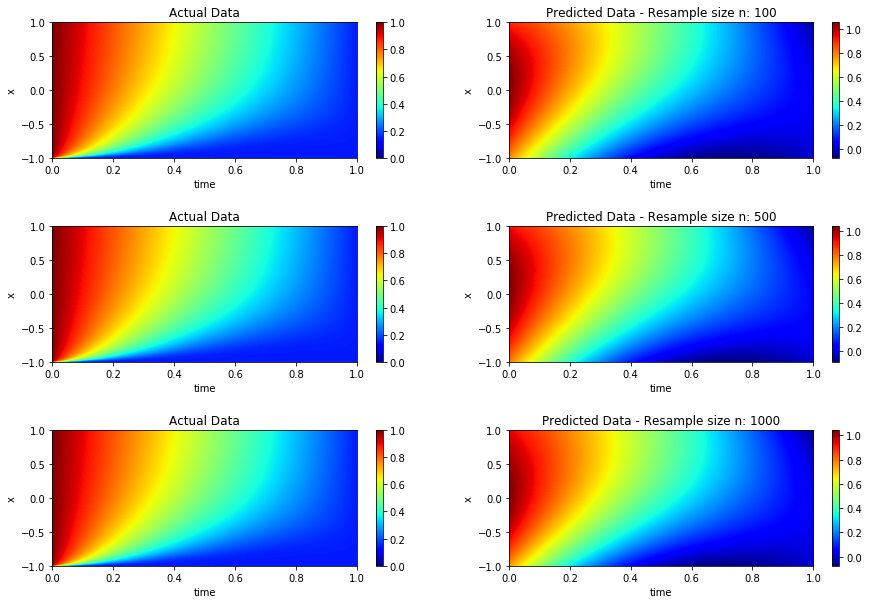

In [217]:
vis.plot_all_subplots(preds, [100, 500, 1000, 2000], 'increase_sample_subplots')

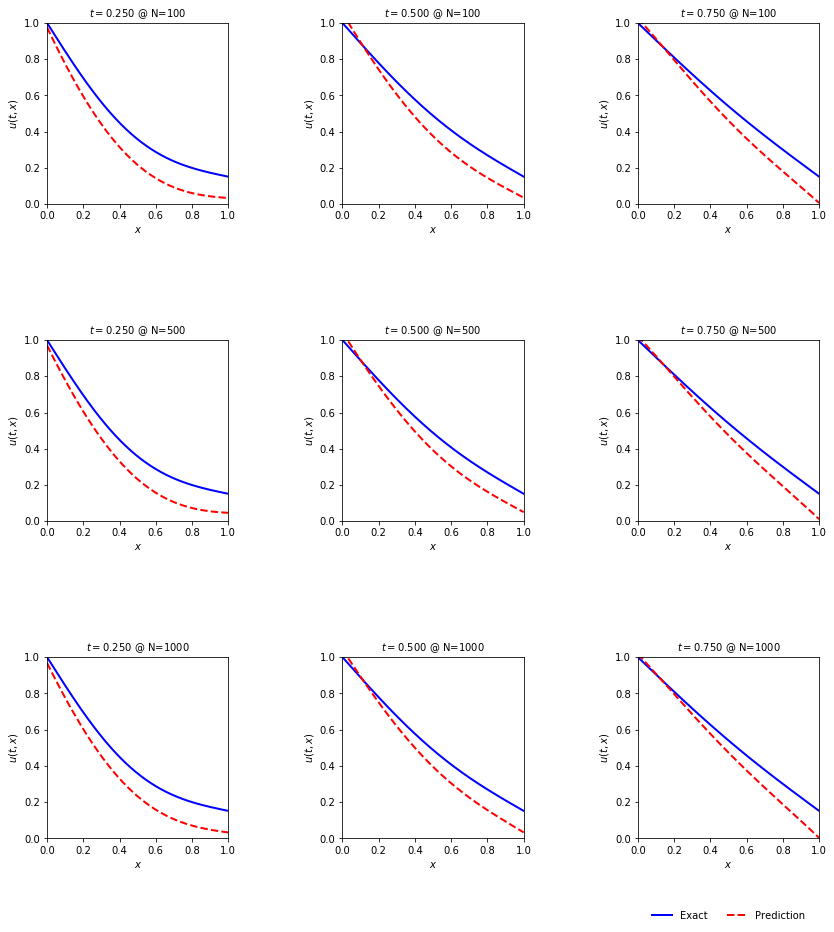

In [218]:
vis.plot_all_actual_vs_predicted(preds, [100, 500, 1000, 2000], 'increase_sample_actualvspredicted')

In [859]:
for p in preds:
    model.evaluate(p.reshape(1000, -1), p_data.reshape(1000, -1))

Mean Squared Error: 0.01129516781100773
Mean Squared Error: 0.011258829661448203
Mean Squared Error: 0.00982832749071136


### Changing Layer Parameters

In [871]:
LAYERS = [2, 100, 100, 100, 1]

In [872]:
train_obj = TrainingDataFrame(data)

In [873]:
# Running Change in layers with 100 data points

In [874]:
preds, lambdas = run_resample(1000, train_obj, data, 1000, 2000)

[ 0.08001656 -0.84390099]
It: 0, Loss: 1.035e-01, Lambda_1: 1.082, Lambda_2: -0.842901, Time: 10.89
It: 10, Loss: 3.653e-02, Lambda_1: 1.079, Lambda_2: -0.836005, Time: 38.72
It: 20, Loss: 2.226e-02, Lambda_1: 1.069, Lambda_2: -0.832622, Time: 39.18
It: 30, Loss: 1.788e-02, Lambda_1: 1.062, Lambda_2: -0.828939, Time: 39.70
It: 40, Loss: 1.541e-02, Lambda_1: 1.058, Lambda_2: -0.825835, Time: 40.37
It: 50, Loss: 1.347e-02, Lambda_1: 1.054, Lambda_2: -0.822867, Time: 40.86
It: 60, Loss: 1.169e-02, Lambda_1: 1.052, Lambda_2: -0.819643, Time: 41.35
It: 70, Loss: 1.028e-02, Lambda_1: 1.051, Lambda_2: -0.816482, Time: 41.86
It: 80, Loss: 9.619e-03, Lambda_1: 1.051, Lambda_2: -0.813622, Time: 42.56
It: 90, Loss: 9.478e-03, Lambda_1: 1.051, Lambda_2: -0.810924, Time: 43.05
It: 100, Loss: 9.347e-03, Lambda_1: 1.052, Lambda_2: -0.808207, Time: 43.56
It: 110, Loss: 9.253e-03, Lambda_1: 1.053, Lambda_2: -0.805405, Time: 44.07
It: 120, Loss: 9.195e-03, Lambda_1: 1.055, Lambda_2: -0.802627, Time: 44.

Loss: 5.910684e-03, l1: 1.40340, l2: -0.29656
Loss: 5.887607e-03, l1: 1.49000, l2: -0.14615
Loss: 5.838924e-03, l1: 1.43631, l2: -0.23834
Loss: 5.763619e-03, l1: 1.48423, l2: -0.15539
Loss: 5.733798e-03, l1: 1.46744, l2: -0.18345
Loss: 5.709610e-03, l1: 1.47646, l2: -0.16781
Loss: 5.683914e-03, l1: 1.48555, l2: -0.15167
Loss: 5.646346e-03, l1: 1.49121, l2: -0.14088
Loss: 5.562029e-03, l1: 1.50803, l2: -0.10973
Loss: 5.478242e-03, l1: 1.53621, l2: -0.05953
Loss: 5.446066e-03, l1: 1.53469, l2: -0.06174
Loss: 5.417080e-03, l1: 1.53794, l2: -0.05671
Loss: 5.381586e-03, l1: 1.54849, l2: -0.04010
Loss: 5.338248e-03, l1: 1.55868, l2: -0.02345
Loss: 5.324999e-03, l1: 1.60012, l2: 0.04443
Loss: 5.310714e-03, l1: 1.57914, l2: 0.01029
Loss: 5.290205e-03, l1: 1.59681, l2: 0.04219
Loss: 5.239424e-03, l1: 1.58745, l2: 0.03026
Loss: 5.210836e-03, l1: 1.58999, l2: 0.03876
Loss: 5.193071e-03, l1: 1.58799, l2: 0.04128
Loss: 5.194573e-03, l1: 1.59962, l2: 0.06429
Loss: 5.188997e-03, l1: 1.59346, l2: 0.05

Loss: 2.463708e-03, l1: 0.64302, l2: 1.95503
Loss: 2.448905e-03, l1: 0.65355, l2: 1.94817
Loss: 2.436170e-03, l1: 0.65804, l2: 1.94710
Loss: 2.420244e-03, l1: 0.65916, l2: 1.94247
Loss: 2.407933e-03, l1: 0.66055, l2: 1.94188
Loss: 2.401813e-03, l1: 0.65553, l2: 1.94135
Loss: 2.385997e-03, l1: 0.64490, l2: 1.91265
Loss: 2.369618e-03, l1: 0.63326, l2: 1.87131
Loss: 2.343524e-03, l1: 0.61341, l2: 1.78248
Loss: 2.313007e-03, l1: 0.58891, l2: 1.68794
Loss: 2.276097e-03, l1: 0.58062, l2: 1.61211
Loss: 2.253143e-03, l1: 0.56424, l2: 1.57252
Loss: 2.239199e-03, l1: 0.54801, l2: 1.52548
Loss: 2.246694e-03, l1: 0.54784, l2: 1.53860
Loss: 2.231829e-03, l1: 0.54794, l2: 1.53091
Loss: 2.221246e-03, l1: 0.53689, l2: 1.49359
Loss: 2.211414e-03, l1: 0.51260, l2: 1.42336
Loss: 2.201201e-03, l1: 0.51394, l2: 1.43429
Loss: 2.191236e-03, l1: 0.50069, l2: 1.39634
Loss: 2.210479e-03, l1: 0.46649, l2: 1.25465
Loss: 2.182110e-03, l1: 0.48690, l2: 1.34039
Loss: 2.169129e-03, l1: 0.47388, l2: 1.28249
Loss: 2.13

Loss: 2.257479e-04, l1: 0.00421, l2: 0.00984
Loss: 2.242526e-04, l1: 0.00416, l2: 0.00981
Loss: 2.203118e-04, l1: 0.00413, l2: 0.00995
Loss: 2.180071e-04, l1: 0.00414, l2: 0.00993
Loss: 2.162440e-04, l1: 0.00416, l2: 0.00996
Loss: 2.149651e-04, l1: 0.00408, l2: 0.00955
Loss: 2.144278e-04, l1: 0.00412, l2: 0.00948
Loss: 2.141453e-04, l1: 0.00400, l2: 0.00921
Loss: 2.139046e-04, l1: 0.00400, l2: 0.00921
Loss: 2.136909e-04, l1: 0.00400, l2: 0.00923
Loss: 2.134738e-04, l1: 0.00398, l2: 0.00918
Loss: 2.132459e-04, l1: 0.00395, l2: 0.00910
Loss: 2.127519e-04, l1: 0.00391, l2: 0.00901
Loss: 2.120409e-04, l1: 0.00381, l2: 0.00870
Loss: 2.109655e-04, l1: 0.00374, l2: 0.00842
Loss: 2.089946e-04, l1: 0.00358, l2: 0.00785
Loss: 2.063421e-04, l1: 0.00341, l2: 0.00745
Loss: 2.134564e-04, l1: 0.00308, l2: 0.00644
Loss: 2.052281e-04, l1: 0.00331, l2: 0.00717
Loss: 2.026590e-04, l1: 0.00325, l2: 0.00698
Loss: 2.036231e-04, l1: 0.00312, l2: 0.00673
Loss: 2.000957e-04, l1: 0.00319, l2: 0.00686
Loss: 1.96

Loss: 6.026897e-05, l1: 0.00019, l2: 0.00000
Loss: 6.020732e-05, l1: 0.00019, l2: 0.00001
Loss: 6.017722e-05, l1: 0.00019, l2: 0.00004
Loss: 6.011389e-05, l1: 0.00019, l2: 0.00007
Loss: 6.002849e-05, l1: 0.00019, l2: 0.00004
Loss: 5.990038e-05, l1: 0.00019, l2: 0.00001
Loss: 5.972397e-05, l1: 0.00018, l2: -0.00001
Loss: 5.958538e-05, l1: 0.00018, l2: -0.00000
Loss: 5.920135e-05, l1: 0.00018, l2: 0.00002
Loss: 5.893158e-05, l1: 0.00018, l2: 0.00009
Loss: 5.850360e-05, l1: 0.00017, l2: 0.00016
Loss: 5.802367e-05, l1: 0.00017, l2: 0.00018
Loss: 5.719929e-05, l1: 0.00017, l2: 0.00019
Loss: 5.677604e-05, l1: 0.00016, l2: 0.00016
Loss: 5.671941e-05, l1: 0.00017, l2: 0.00007
Loss: 5.648300e-05, l1: 0.00017, l2: 0.00012
Loss: 5.587203e-05, l1: 0.00016, l2: 0.00007
Loss: 5.539538e-05, l1: 0.00016, l2: 0.00005
Loss: 5.483443e-05, l1: 0.00016, l2: 0.00011
Loss: 5.473902e-05, l1: 0.00016, l2: 0.00014
Loss: 5.440754e-05, l1: 0.00016, l2: 0.00010
Loss: 5.436693e-05, l1: 0.00015, l2: 0.00008
Loss: 5.

Loss: 4.123620e-05, l1: 0.00008, l2: 0.00007
Loss: 4.116813e-05, l1: 0.00008, l2: 0.00010
Loss: 4.104675e-05, l1: 0.00008, l2: 0.00011
Loss: 4.081083e-05, l1: 0.00008, l2: 0.00011
Loss: 4.062100e-05, l1: 0.00008, l2: 0.00011
Loss: 4.042210e-05, l1: 0.00008, l2: 0.00011
Loss: 4.041754e-05, l1: 0.00008, l2: 0.00010
Loss: 4.028483e-05, l1: 0.00008, l2: 0.00010
Loss: 4.006653e-05, l1: 0.00008, l2: 0.00013
Loss: 3.987960e-05, l1: 0.00008, l2: 0.00012
Loss: 3.988659e-05, l1: 0.00008, l2: 0.00016
Loss: 3.976817e-05, l1: 0.00008, l2: 0.00014
Loss: 3.953970e-05, l1: 0.00007, l2: 0.00016
Loss: 3.926319e-05, l1: 0.00007, l2: 0.00014
Loss: 3.907636e-05, l1: 0.00007, l2: 0.00009
Loss: 3.944477e-05, l1: 0.00007, l2: 0.00008
Loss: 3.895284e-05, l1: 0.00007, l2: 0.00009
Loss: 3.890484e-05, l1: 0.00007, l2: 0.00010
Loss: 3.880293e-05, l1: 0.00007, l2: 0.00009
Loss: 3.866497e-05, l1: 0.00007, l2: 0.00009
Loss: 3.851697e-05, l1: 0.00007, l2: 0.00007
Loss: 3.847961e-05, l1: 0.00007, l2: 0.00004
Loss: 3.83

Loss: 2.744641e-05, l1: 0.00006, l2: 0.00001
Loss: 2.742908e-05, l1: 0.00006, l2: 0.00000
Loss: 2.738405e-05, l1: 0.00006, l2: -0.00000
Loss: 2.734948e-05, l1: 0.00006, l2: 0.00001
Loss: 2.735296e-05, l1: 0.00006, l2: 0.00001
Loss: 2.733464e-05, l1: 0.00006, l2: 0.00001
Loss: 2.731536e-05, l1: 0.00006, l2: 0.00001
Loss: 2.729105e-05, l1: 0.00006, l2: 0.00001
Loss: 2.726915e-05, l1: 0.00006, l2: 0.00002
Loss: 2.724305e-05, l1: 0.00005, l2: 0.00002
Loss: 2.720995e-05, l1: 0.00005, l2: 0.00003
Loss: 2.718236e-05, l1: 0.00005, l2: 0.00003
Loss: 2.717926e-05, l1: 0.00005, l2: 0.00003
Loss: 2.711930e-05, l1: 0.00005, l2: 0.00003
Loss: 2.712189e-05, l1: 0.00005, l2: 0.00002
Loss: 2.709368e-05, l1: 0.00005, l2: 0.00002
Loss: 2.704257e-05, l1: 0.00005, l2: 0.00003
Loss: 2.709158e-05, l1: 0.00005, l2: 0.00002
Loss: 2.699022e-05, l1: 0.00005, l2: 0.00002
Loss: 2.694044e-05, l1: 0.00005, l2: 0.00002
Loss: 2.690406e-05, l1: 0.00005, l2: 0.00003
Loss: 2.685132e-05, l1: 0.00005, l2: 0.00001
Loss: 2.6

In [875]:
model.evaluate(preds, p_data)

Mean Squared Error: 0.007105543229637264


0.007105543229637264

In [876]:
model.evaluate_lambdas(lambdas[0], lambdas[1], 1.0, reservoir.nu)

Expected / Predicted Lambda1: 1.0 / 5.2708604926010594e-05
Root Square Error: 99.98945855683449% 

------------------------------------------------
Expected / Predicted Lambda2: 0.0016334081056890734 / -1.6177799579963903e-06
Root Square Error: 0.0002673309646735985%


(0.999894585568345, 2.673309646735985e-06)

In [900]:
LAYERS = [2, 50, 50, 50, 50, 50, 50, 50, 50, 50, 1]

In [901]:
train_obj = TrainingDataFrame(data)

In [902]:
# Running Change in layers with 200 data points

In [903]:
preds, lambdas = run_resample(1000, train_obj, data, 1000, 2000)

[-1.28367626 -0.09725448]
It: 0, Loss: 1.421e-01, Lambda_1: 0.277, Lambda_2: -0.096978, Time: 15.31
It: 10, Loss: 9.129e-02, Lambda_1: 0.276, Lambda_2: -0.101038, Time: 47.21
It: 20, Loss: 5.721e-02, Lambda_1: 0.274, Lambda_2: -0.097527, Time: 48.07
It: 30, Loss: 3.241e-02, Lambda_1: 0.271, Lambda_2: -0.096552, Time: 49.09
It: 40, Loss: 2.217e-02, Lambda_1: 0.269, Lambda_2: -0.085011, Time: 49.97
It: 50, Loss: 1.670e-02, Lambda_1: 0.267, Lambda_2: -0.072081, Time: 51.00
It: 60, Loss: 1.297e-02, Lambda_1: 0.265, Lambda_2: -0.062434, Time: 51.86
It: 70, Loss: 1.151e-02, Lambda_1: 0.264, Lambda_2: -0.051593, Time: 52.75
It: 80, Loss: 1.074e-02, Lambda_1: 0.263, Lambda_2: -0.042439, Time: 53.85
It: 90, Loss: 1.078e-02, Lambda_1: 0.262, Lambda_2: -0.034582, Time: 54.80
It: 100, Loss: 1.005e-02, Lambda_1: 0.261, Lambda_2: -0.028023, Time: 55.93
It: 110, Loss: 9.897e-03, Lambda_1: 0.260, Lambda_2: -0.022506, Time: 56.95
It: 120, Loss: 9.719e-03, Lambda_1: 0.260, Lambda_2: -0.017496, Time: 58.

Loss: 2.958452e-03, l1: 0.20758, l2: 0.39154
Loss: 2.915711e-03, l1: 0.20590, l2: 0.39827
Loss: 2.895843e-03, l1: 0.20486, l2: 0.40194
Loss: 2.887801e-03, l1: 0.20501, l2: 0.40111
Loss: 2.884332e-03, l1: 0.20516, l2: 0.40035
Loss: 2.871190e-03, l1: 0.20513, l2: 0.39972
Loss: 2.847454e-03, l1: 0.20460, l2: 0.40007
Loss: 2.821272e-03, l1: 0.20367, l2: 0.40177
Loss: 2.765564e-03, l1: 0.20102, l2: 0.40702
Loss: 2.719664e-03, l1: 0.19854, l2: 0.41197
Loss: 2.670024e-03, l1: 0.19585, l2: 0.41691
Loss: 2.617155e-03, l1: 0.19374, l2: 0.42026
Loss: 2.553599e-03, l1: 0.18916, l2: 0.42928
Loss: 2.480702e-03, l1: 0.18790, l2: 0.42951
Loss: 2.422429e-03, l1: 0.18627, l2: 0.43295
Loss: 2.385929e-03, l1: 0.18326, l2: 0.43822
Loss: 2.374751e-03, l1: 0.18238, l2: 0.43952
Loss: 2.361758e-03, l1: 0.18036, l2: 0.44286
Loss: 2.343868e-03, l1: 0.17781, l2: 0.44733
Loss: 2.306707e-03, l1: 0.17246, l2: 0.45716
Loss: 2.261719e-03, l1: 0.16454, l2: 0.47249
Loss: 2.228417e-03, l1: 0.16608, l2: 0.46967
Loss: 2.19

Loss: 1.200029e-03, l1: 0.04810, l2: 0.12947
Loss: 1.187783e-03, l1: 0.04955, l2: 0.13495
Loss: 1.192310e-03, l1: 0.04783, l2: 0.12777
Loss: 1.186090e-03, l1: 0.04891, l2: 0.13231
Loss: 1.185964e-03, l1: 0.04800, l2: 0.13010
Loss: 1.184911e-03, l1: 0.04849, l2: 0.13130
Loss: 1.183356e-03, l1: 0.04810, l2: 0.13072
Loss: 1.180149e-03, l1: 0.04674, l2: 0.12594
Loss: 1.177684e-03, l1: 0.04630, l2: 0.12535
Loss: 1.172048e-03, l1: 0.04595, l2: 0.12352
Loss: 1.191554e-03, l1: 0.04331, l2: 0.11389
Loss: 1.169219e-03, l1: 0.04515, l2: 0.12065
Loss: 1.164491e-03, l1: 0.04349, l2: 0.11522
Loss: 1.156545e-03, l1: 0.04282, l2: 0.11415
Loss: 1.238207e-03, l1: 0.03909, l2: 0.10318
Loss: 1.152819e-03, l1: 0.04195, l2: 0.11170
Loss: 1.151497e-03, l1: 0.03966, l2: 0.10355
Loss: 1.148355e-03, l1: 0.04096, l2: 0.10821
Loss: 1.143222e-03, l1: 0.03940, l2: 0.10354
Loss: 1.150121e-03, l1: 0.03793, l2: 0.09890
Loss: 1.139522e-03, l1: 0.03885, l2: 0.10182
Loss: 1.139513e-03, l1: 0.03717, l2: 0.09754
Loss: 1.13

Loss: 8.922936e-04, l1: 0.02283, l2: 0.06249
Loss: 8.918926e-04, l1: 0.02293, l2: 0.06279
Loss: 8.917174e-04, l1: 0.02291, l2: 0.06288
Loss: 8.913965e-04, l1: 0.02292, l2: 0.06284
Loss: 8.911402e-04, l1: 0.02296, l2: 0.06294
Loss: 8.908861e-04, l1: 0.02301, l2: 0.06299
Loss: 8.907790e-04, l1: 0.02304, l2: 0.06323
Loss: 8.906722e-04, l1: 0.02305, l2: 0.06349
Loss: 8.904816e-04, l1: 0.02305, l2: 0.06379
Loss: 8.901792e-04, l1: 0.02300, l2: 0.06397
Loss: 8.902530e-04, l1: 0.02294, l2: 0.06411
Loss: 8.900195e-04, l1: 0.02297, l2: 0.06404
Loss: 8.897646e-04, l1: 0.02284, l2: 0.06360
Loss: 8.896111e-04, l1: 0.02283, l2: 0.06342
Loss: 8.893657e-04, l1: 0.02280, l2: 0.06278
Loss: 8.892865e-04, l1: 0.02276, l2: 0.06274
Loss: 8.891611e-04, l1: 0.02276, l2: 0.06295
Loss: 8.890153e-04, l1: 0.02273, l2: 0.06308
Loss: 8.888598e-04, l1: 0.02268, l2: 0.06302
Loss: 8.887239e-04, l1: 0.02260, l2: 0.06275
Loss: 8.887159e-04, l1: 0.02258, l2: 0.06249
Loss: 8.886846e-04, l1: 0.02259, l2: 0.06262
Loss: 8.88

Loss: 7.181732e-04, l1: 0.02326, l2: 0.06201
Loss: 7.172094e-04, l1: 0.02311, l2: 0.06211
Loss: 7.159514e-04, l1: 0.02286, l2: 0.06215
Loss: 7.149638e-04, l1: 0.02281, l2: 0.06181
Loss: 7.142980e-04, l1: 0.02268, l2: 0.06129
Loss: 7.143722e-04, l1: 0.02276, l2: 0.06090
Loss: 7.133502e-04, l1: 0.02272, l2: 0.06110
Loss: 7.118332e-04, l1: 0.02264, l2: 0.06074
Loss: 7.103463e-04, l1: 0.02252, l2: 0.06013
Loss: 7.089030e-04, l1: 0.02241, l2: 0.05958
Loss: 7.081404e-04, l1: 0.02239, l2: 0.05910
Loss: 7.074897e-04, l1: 0.02226, l2: 0.05873
Loss: 7.071899e-04, l1: 0.02226, l2: 0.05868
Loss: 7.068563e-04, l1: 0.02224, l2: 0.05835
Loss: 7.064709e-04, l1: 0.02216, l2: 0.05806
Loss: 7.059919e-04, l1: 0.02207, l2: 0.05756
Loss: 7.053295e-04, l1: 0.02178, l2: 0.05613
Loss: 7.051677e-04, l1: 0.02168, l2: 0.05586
Loss: 7.047806e-04, l1: 0.02182, l2: 0.05651
Loss: 7.045089e-04, l1: 0.02180, l2: 0.05653
Loss: 7.042657e-04, l1: 0.02174, l2: 0.05636
Loss: 7.034482e-04, l1: 0.02157, l2: 0.05588
Loss: 7.02

Loss: 6.675735e-04, l1: 0.01767, l2: 0.04741
Loss: 6.673684e-04, l1: 0.01770, l2: 0.04748
Loss: 6.683005e-04, l1: 0.01768, l2: 0.04763
Loss: 6.666568e-04, l1: 0.01769, l2: 0.04754
Loss: 6.702695e-04, l1: 0.01750, l2: 0.04710
Loss: 6.659893e-04, l1: 0.01763, l2: 0.04740
Loss: 6.661975e-04, l1: 0.01752, l2: 0.04734
Loss: 6.656776e-04, l1: 0.01758, l2: 0.04737
Loss: 6.653322e-04, l1: 0.01756, l2: 0.04736
Loss: 6.651168e-04, l1: 0.01757, l2: 0.04737
Loss: 6.649618e-04, l1: 0.01758, l2: 0.04736
Loss: 6.648207e-04, l1: 0.01759, l2: 0.04723
Loss: 6.646895e-04, l1: 0.01761, l2: 0.04713
Loss: 6.645346e-04, l1: 0.01761, l2: 0.04698
Loss: 6.643314e-04, l1: 0.01762, l2: 0.04672
Loss: 6.641210e-04, l1: 0.01760, l2: 0.04647
Loss: 6.639093e-04, l1: 0.01758, l2: 0.04624
Loss: 6.636056e-04, l1: 0.01753, l2: 0.04602
Loss: 6.630615e-04, l1: 0.01745, l2: 0.04590
Loss: 6.620800e-04, l1: 0.01732, l2: 0.04576
Loss: 6.613840e-04, l1: 0.01724, l2: 0.04559
Loss: 6.641900e-04, l1: 0.01714, l2: 0.04583
Loss: 6.61

Loss: 5.398202e-04, l1: 0.01123, l2: 0.03049
Loss: 5.385139e-04, l1: 0.01120, l2: 0.03032
Loss: 5.378231e-04, l1: 0.01117, l2: 0.03017
Loss: 5.384420e-04, l1: 0.01119, l2: 0.03053
Loss: 5.369127e-04, l1: 0.01118, l2: 0.03033
Loss: 5.363896e-04, l1: 0.01118, l2: 0.03027
Loss: 5.359230e-04, l1: 0.01117, l2: 0.03011
Loss: 5.355650e-04, l1: 0.01117, l2: 0.03008
Loss: 5.350941e-04, l1: 0.01116, l2: 0.03012
Loss: 5.341554e-04, l1: 0.01110, l2: 0.03036
Loss: 5.330630e-04, l1: 0.01107, l2: 0.03065
Loss: 5.307064e-04, l1: 0.01100, l2: 0.03096
Loss: 5.321370e-04, l1: 0.01082, l2: 0.03163
Loss: 5.291796e-04, l1: 0.01092, l2: 0.03126
Loss: 5.282450e-04, l1: 0.01087, l2: 0.03169
Loss: 5.268206e-04, l1: 0.01085, l2: 0.03156
Loss: 5.255835e-04, l1: 0.01086, l2: 0.03115
Loss: 5.237234e-04, l1: 0.01080, l2: 0.03045
Loss: 5.221341e-04, l1: 0.01079, l2: 0.02964
Loss: 5.209008e-04, l1: 0.01070, l2: 0.02962
Loss: 5.214642e-04, l1: 0.01061, l2: 0.02952
Loss: 5.198926e-04, l1: 0.01066, l2: 0.02957
Loss: 5.18

In [904]:
model.evaluate(preds, p_data)

Mean Squared Error: 0.010088258506301465


0.010088258506301465

In [905]:
LAYERS = [2, 200, 200, 200, 1]

# 1D Diffusivity (Homogeneous) - Part V

In [239]:
import seaborn as sns

In [219]:
res = Reservoir(0.2, 100, 3e-5, 100, 1000, 5000, 2000)

In [223]:
res.set_num_terms_for_fourier()

Setting number of expansion terms to: 50


In [251]:
x = np.linspace(0, 1000, 2000)
t = np.linspace(0, 100, 2000)

X, T = np.meshgrid(x, t)

In [252]:
p = res.pressure_profile(X, T)

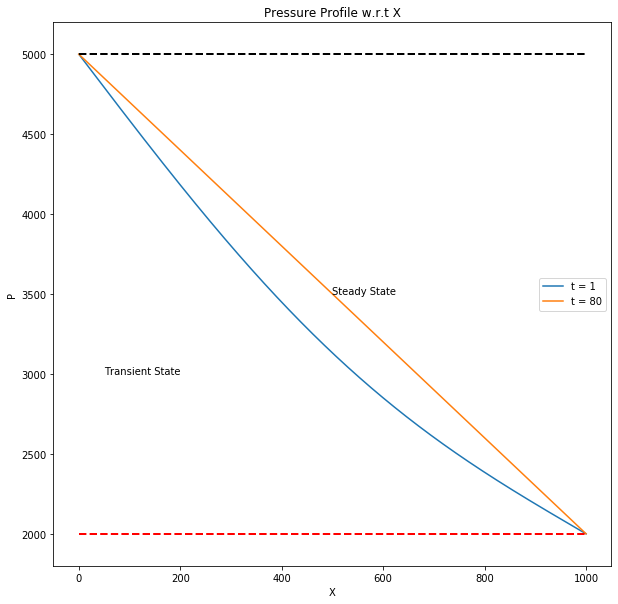

In [254]:
res.plot_pressure_profile(100, 2000, 2000)